## Infer cellular trajectories

This notebook demonstrates how to infer cell trajectories after estimating the underlying distributions.

In [1]:
import os
###########################################
# set path to the downloaded UOTReg folder
###########################################
folder_path = '/Users/binghao/Desktop/Research/OT-singlecell/UOTReg/'
os.chdir(folder_path)
print("Current working directory:", os.getcwd())

# basic math package
import pandas as pd
import numpy as np

# loading data
import scanpy as sc

# some practical packages
import warnings
warnings.filterwarnings('ignore')
import gc
from IPython.display import clear_output

# packages for DL
import torch
from torch import nn
from torch.nn import functional as F
import torch.optim as optim
import torch.distributions as distrib
import torch.distributions.transforms as transform
from torch.distributions import constraints
import tqdm
from tqdm import tqdm, tqdm_notebook
from copy import deepcopy

# package for matrix operation
from sklearn.decomposition import PCA
from sklearn.datasets import make_spd_matrix

# load OT functions
from UOTReg.tools import ewma, freeze, unfreeze
from UOTReg import distributions
from UOTReg.models import FFNN, Seperate_D, Seperate_T, Gnet, Encoder, Discriminator
from UOTReg.tools import tensorDataset, tensorSampler
from UOTReg.tools import weights_init, calculate_moments, calculate_weights, random_sample
from UOTReg.train_models import optimize_T_and_D, optimize_G, optimize_T_and_D_UOT, optimize_T_and_D_UOT_new
from UOTReg.UOT import UOT_relax_on_2


# for plotting
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import umap

Current working directory: /Users/binghao/Desktop/Research/OT-singlecell/UOTReg


## Set up Data

## ACC case

In [3]:
# loading the learned generators
size = 100
DIM = 2
dropout_rate = 0.05
G1 = Gnet(input_dim=DIM, output_dim=DIM, size=size, num_layers=4, dropout_rate=dropout_rate)
G2 = Gnet(input_dim=DIM, output_dim=DIM, size=size, num_layers=4, dropout_rate=dropout_rate)
G3 = Gnet(input_dim=DIM, output_dim=DIM, size=size, num_layers=4, dropout_rate=dropout_rate)
G4 = Gnet(input_dim=DIM, output_dim=DIM, size=size, num_layers=4, dropout_rate=dropout_rate)
G5 = Gnet(input_dim=DIM, output_dim=DIM, size=size, num_layers=4, dropout_rate=dropout_rate)
G6 = Gnet(input_dim=DIM, output_dim=DIM, size=size, num_layers=4, dropout_rate=dropout_rate)
G7 = Gnet(input_dim=DIM, output_dim=DIM, size=size, num_layers=4, dropout_rate=dropout_rate)
G8 = Gnet(input_dim=DIM, output_dim=DIM, size=size, num_layers=4, dropout_rate=dropout_rate)
Z_sampler = distributions.StandardNormalSampler(dim=DIM, device="cpu")

print('G params:', np.sum([np.prod(p.shape) for p in G1.parameters()]))

###########################################
# set path to the downloaded UOTReg folder
###########################################
result_folder = "/Users/binghao/Desktop/Research/OT-singlecell/UOTReg/"
G1.load_state_dict(torch.load(result_folder+"results/simu/noisy/cc/Gnew/G_100_acc_1.pth"))
G2.load_state_dict(torch.load(result_folder+"results/simu/noisy/cc/Gnew/G_100_acc_2.pth"))
G3.load_state_dict(torch.load(result_folder+"results/simu/noisy/cc/Gnew/G_100_acc_3.pth"))
G4.load_state_dict(torch.load(result_folder+"results/simu/noisy/cc/Gnew/G_100_acc_4.pth"))
G5.load_state_dict(torch.load(result_folder+"results/simu/noisy/cc/Gnew/G_100_acc_5.pth"))
G6.load_state_dict(torch.load(result_folder+"results/simu/noisy/cc/Gnew/G_100_acc_6.pth"))
G7.load_state_dict(torch.load(result_folder+"results/simu/noisy/cc/Gnew/G_100_acc_7.pth"))
G8.load_state_dict(torch.load(result_folder+"results/simu/noisy/cc/Gnew/G_100_acc_8.pth"))
Gs = [G1,G2, G3, G4, G5, G6, G7, G8]

G params: 30802


In [4]:
Ysamplers_acc_reg = []
# Ysamplers_nonaffine_reg = []
datasets_learned = []

for i in range(8):

    pt_data = Gs[i](Z_sampler.sample(500)).detach().numpy()

    meta_acc = pd.DataFrame(i, index=range(500), columns=['value'])
    dataset = tensorDataset(pd.DataFrame(pt_data),meta_acc)
    print(len(dataset))
    Ysamplers_acc_reg.append(tensorSampler(dataset, device="cpu"))
    datasets_learned.append(Ysamplers_acc_reg[i].sample(500).detach().numpy())

500
500
500
500
500
500
500
500


500
500
500
500
500
500
500
500
500
500


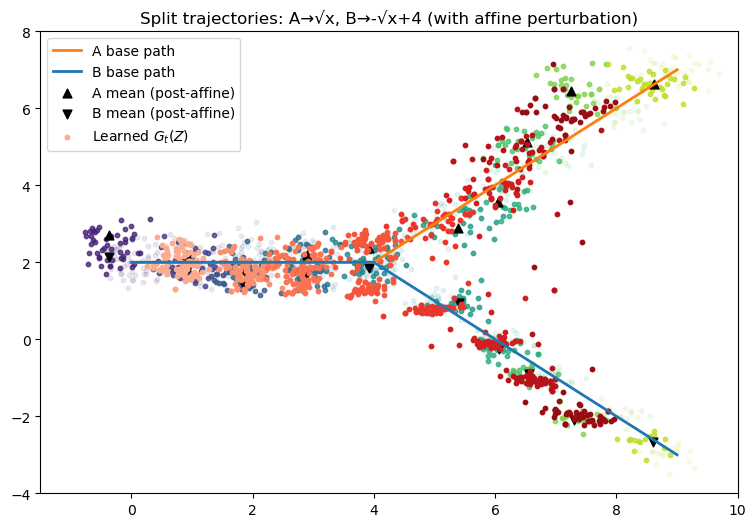

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch

# ---------------------- Affine (one-knob strength) --------------------------

def make_affine(strength=0.50, rotation_max_deg=10, scale_max=0.20, b_sigma_max=0.30):
    """
    Generate an affine map (A,b) with controllable 'strength':
      strength=0  -> A≈I, b≈0
      strength=1  -> full ranges of rotation/scale/translation
    """
    th = np.deg2rad(np.random.uniform(-rotation_max_deg*strength, rotation_max_deg*strength))
    c, s = np.cos(th), np.sin(th)
    R = np.array([[c, -s], [s, c]])

    s1 = 1.0 + strength*np.random.uniform(-scale_max, scale_max)
    s2 = 1.0 + strength*np.random.uniform(-scale_max, scale_max)

    A  = R @ np.diag([s1, s2]) @ R.T
    b  = np.random.randn(2) * (b_sigma_max*strength)
    return A, b

# ---------------------- Configuration ---------------------------------------

seed = 23
np.random.seed(seed)

x   = np.arange(10)              # 0..9
NUM = len(x)

yA_base = np.where(x <= 4, 2.0, x - 2)        # upper comp path
yB_base = np.where(x <= 4, 2.0, -x + 6.0) # lower comp path

colors = plt.cm.viridis(np.linspace(0.1, 0.9, NUM))

n_per_gauss  = 50
dataset_size = 500
pi_A         = 0.5

delta_pre  = 0.25
delta_post = 0.00

# >>> changed jitter logic
# Remove x-jitter entirely; only add small y-only jitter for t in {0..4}.
y_only_jitter_pre = 0.03  # magnitude for the early shared phase

sig_x_A, sig_y_A = 0.32, 0.30
sig_x_B, sig_y_B = 0.22, 0.20
cov_A = np.diag([sig_x_A**2, sig_y_A**2])
cov_B = np.diag([sig_x_B**2, sig_y_B**2])

strength = 0.5
per_time_affine = True

datasets_acc = []
Ysamplers_acc = []

# ---------------------- Main generation loop --------------------------------

plt.close('all')
plt.figure(figsize=(9, 6))
plt.title('Split trajectories: A→√x, B→-√x+4 (with affine perturbation)')

plt.plot(x, yA_base, color='tab:orange', linewidth=2.0, label='A base path')
plt.plot(x, yB_base, color='tab:blue',   linewidth=2.0, label='B base path')

datasets_acc = []

if not per_time_affine:
    A_global, b_global = make_affine(strength=strength)

for i in range(NUM):
    muA_center = np.array([x[i], yA_base[i]])
    muB_center = np.array([x[i], yB_base[i]])

    dA = +delta_pre  if i <= 4 else +delta_post
    dB = -delta_pre  if i <= 4 else -delta_post

    # >>> changed jitter logic (no x-jitter; only y-perturbation for t<=4)
    if i <= 4:
        jitter_y_A = np.random.randn() * y_only_jitter_pre
        jitter_y_B = np.random.randn() * y_only_jitter_pre
    else:
        jitter_y_A = 0.0
        jitter_y_B = 0.0

    mu_A = muA_center + np.array([0.0, dA + jitter_y_A])
    mu_B = muB_center + np.array([0.0, dB - jitter_y_B])  # keep B slightly lower

    counts_small = np.random.multinomial(n_per_gauss, [pi_A, 1 - pi_A])
    gt_A_small = np.random.multivariate_normal(mu_A, cov_A, counts_small[0])
    gt_B_small = np.random.multivariate_normal(mu_B, cov_B, counts_small[1])
    gt_small   = np.vstack([gt_A_small, gt_B_small])

    counts_full = np.random.multinomial(dataset_size, [pi_A, 1 - pi_A])
    gt_A = np.random.multivariate_normal(mu_A, cov_A, counts_full[0])
    gt_B = np.random.multivariate_normal(mu_B, cov_B, counts_full[1])
    gt_data = np.vstack([gt_A, gt_B])
    comp_full = np.array([0]*counts_full[0] + [1]*counts_full[1])

    if per_time_affine:
        A, b = make_affine(strength=strength)
    else:
        A, b = A_global, b_global

    pt_small = (gt_small @ A.T) + b
    pt_data  = (gt_data  @ A.T) + b

    datasets_acc.append(torch.from_numpy(pt_data).float())
    meta_acc= pd.DataFrame(i, index=range(dataset_size), columns=['value'])
    dataset = tensorDataset(pd.DataFrame(pt_data),meta_acc)
    print(len(dataset))
    Ysamplers_acc.append(tensorSampler(dataset, device="cpu"))

    mu_pt_A = A @ mu_A + b
    mu_pt_B = A @ mu_B + b

    col = colors[i]
    plt.scatter(gt_small[:,0], gt_small[:,1], color=col, s=10, alpha=0.10)
    plt.scatter(pt_small[:,0], pt_small[:,1], color=col, s=10, alpha=0.80)

    if i == 0:
        plt.scatter(*mu_pt_A, color='black', marker='^', s=40, label='A mean (post-affine)')
        plt.scatter(*mu_pt_B, color='black', marker='v', s=40, label='B mean (post-affine)')
    else:
        plt.scatter(*mu_pt_A, color='black', marker='^', s=40)
        plt.scatter(*mu_pt_B, color='black', marker='v', s=40)

import matplotlib.cm as cm
# --- overlay learned samples (second chunk) ---
ax = plt.gca()
reds = cm.Reds(np.linspace(0.3, 0.9, len(Ysamplers_acc_reg)))

for i, sampler in enumerate(Ysamplers_acc_reg):
    samples = sampler.sample(100).numpy()
    ax.scatter(
        samples[:, 0], samples[:, 1],
        color=reds[i], s=10,
        label='Learned $G_t(Z)$' if i == 0 else ''
    )

plt.xlim(-1.5, 10)   # set x-axis range
plt.ylim(-4, 8)   # set y-axis range

plt.legend()
plt.show()


Infer trajectories from denoised distributions (UOTReg):

- You can rerun the code to train your own maps; ensure the `save_path` is correctly specified.
- Trained models are also provided to reproduce the visualizations in the paper. (You don't need to train anything)

In [6]:
import torch
import os
import pickle

# Define hyperparameters
it = 0
BATCH_SIZE = 64
D_ITERS = 250
T_ITERS = 100
save_path = "Path/to/your/folder"
D_LR, T_LR = 3e-4, 3e-4

dropout_rate = 0.05
# Parameters for T and D
input_size = DIM # DIM
output_size = DIM
n_hidden = 5
task_specific_hidden_size_T = 256
task_specific_hidden_size_D = 256

# Ensure save directory exists
os.makedirs(save_path, exist_ok=True)

# Loop through the sequence to train OT maps from i -> i+1
for i in range(7):
    print(f"Training OT map from Ysamplers[{i}] to Ysamplers[{i+1}]")

    # Initialize networks
    T = FFNN(input_size, task_specific_hidden_size_T, n_hidden, output_size, bn=False, dropout_rate=dropout_rate)
    D = FFNN(input_size, task_specific_hidden_size_D, n_hidden, 1, bn=False, dropout_rate=dropout_rate)

    if i == 0 :
        T.apply(weights_init)
        D.apply(weights_init)
    else:
        Tparam = torch.load(save_path + f"/T_map_{i}_to_{i+1}.pt")
        T.load_state_dict(Tparam)
        Dparam = torch.load(save_path + f"/D_{i}_to_{i+1}.pt")
        D.load_state_dict(Dparam)

    # Define optimizers
    T_opt = optim.Adam(T.parameters(), lr=D_LR, weight_decay=1e-10)
    D_opt = optim.Adam(D.parameters(), lr=D_LR, weight_decay=1e-10)

    # Train the OT map
    it = UOT_relax_on_2(it, T, D, T_opt, D_opt, Ysamplers_acc_reg[i], Ysamplers_acc_reg[i + 1], BATCH_SIZE, D_ITERS, T_ITERS, tau=5)

    # Save the trained transport map
    map_filename_T = os.path.join(save_path, f"T_map_{i+1}_to_{i+2}.pt")
    filename_D = os.path.join(save_path, f"D_{i+1}_to_{i+2}.pt")
    torch.save(T.state_dict(), map_filename_T)
    torch.save(D.state_dict(), filename_D)

    print(f"Saved OT map from {i} to {i+1} at {map_filename_T}")

print("All OT maps have been trained and saved successfully.")

Training OT map from Ysamplers[0] to Ysamplers[1]


  0%|          | 0/250 [00:00<?, ?it/s]

UOT (relax on 2): total_iters: 0, d_iter: 0


  0%|          | 1/250 [00:00<02:10,  1.91it/s]

UOT (relax on 2): total_iters: 1, d_iter: 1


  1%|          | 2/250 [00:01<02:04,  1.99it/s]

UOT (relax on 2): total_iters: 2, d_iter: 2


  1%|          | 3/250 [00:01<02:04,  1.98it/s]

UOT (relax on 2): total_iters: 3, d_iter: 3


  2%|▏         | 4/250 [00:02<02:07,  1.92it/s]


UOT (relax on 2): total_iters: 4, d_iter: 4


KeyboardInterrupt: 

Infer trajectories from observed distributions (WOT-style):

- You can rerun the code to train your own maps; ensure the `save_path` is correctly specified.
- Trained models are also provided to reproduce the visualizations in the paper. (You don't need to train anything)

In [ ]:
import torch
import os
import pickle

# Define hyperparameters
it = 0
BATCH_SIZE = 64
D_ITERS = 250
T_ITERS = 100
save_path = "Path/to/your/folder"
D_LR, T_LR = 3e-4, 3e-4

dropout_rate = 0.05
# Parameters for T and D
input_size = DIM # DIM
output_size = DIM
n_hidden = 5
task_specific_hidden_size_T = 256
task_specific_hidden_size_D = 256

# Ensure save directory exists
os.makedirs(save_path, exist_ok=True)

# Loop through the sequence to train OT maps from i -> i+1
for i in range(7):
    print(f"Training OT map from Ysamplers[{i}] to Ysamplers[{i+1}]")

    # Initialize networks
    T = FFNN(input_size, task_specific_hidden_size_T, n_hidden, output_size, bn=False, dropout_rate=dropout_rate)
    D = FFNN(input_size, task_specific_hidden_size_D, n_hidden, 1, bn=False, dropout_rate=dropout_rate)

    if i == 0 :
        T.apply(weights_init)
        D.apply(weights_init)
    else:
        Tparam = torch.load(save_path + f"/T_map_{i}_to_{i+1}.pt")
        T.load_state_dict(Tparam)
        Dparam = torch.load(save_path + f"/D_{i}_to_{i+1}.pt")
        D.load_state_dict(Dparam)

    # Define optimizers
    T_opt = optim.Adam(T.parameters(), lr=D_LR, weight_decay=1e-10)
    D_opt = optim.Adam(D.parameters(), lr=D_LR, weight_decay=1e-10)

    # Train the OT map
    # it = OT(it, T, D, T_opt, D_opt, Ysamplers_new[i], Ysamplers_new[i + 1], BATCH_SIZE, D_ITERS, T_ITERS)
    it = UOT_relax_on_2(it, T, D, T_opt, D_opt, Ysamplers_acc[i], Ysamplers_acc[i + 1], BATCH_SIZE, D_ITERS, T_ITERS, tau=5)

    # Save the trained transport map
    map_filename_T = os.path.join(save_path, f"T_map_{i+1}_to_{i+2}.pt")
    filename_D = os.path.join(save_path, f"D_{i+1}_to_{i+2}.pt")
    torch.save(T.state_dict(), map_filename_T)
    torch.save(D.state_dict(), filename_D)

    print(f"Saved OT map from {i} to {i+1} at {map_filename_T}")

print("All OT maps have been trained and saved successfully.")

Training OT map from Ysamplers[0] to Ysamplers[1]


  0%|          | 0/250 [00:00<?, ?it/s]

UOT (relax on 2): total_iters: 0, d_iter: 0


  0%|          | 1/250 [00:00<02:42,  1.54it/s]

UOT (relax on 2): total_iters: 1, d_iter: 1


  1%|          | 2/250 [00:01<02:31,  1.64it/s]

UOT (relax on 2): total_iters: 2, d_iter: 2


  1%|          | 3/250 [00:01<02:26,  1.69it/s]

UOT (relax on 2): total_iters: 3, d_iter: 3


  2%|▏         | 4/250 [00:02<02:24,  1.70it/s]

UOT (relax on 2): total_iters: 4, d_iter: 4


  2%|▏         | 5/250 [00:02<02:23,  1.71it/s]

UOT (relax on 2): total_iters: 5, d_iter: 5


  2%|▏         | 6/250 [00:03<02:22,  1.71it/s]

UOT (relax on 2): total_iters: 6, d_iter: 6


  3%|▎         | 7/250 [00:04<02:22,  1.71it/s]

UOT (relax on 2): total_iters: 7, d_iter: 7


  3%|▎         | 8/250 [00:04<02:21,  1.71it/s]

UOT (relax on 2): total_iters: 8, d_iter: 8


  4%|▎         | 9/250 [00:05<02:21,  1.70it/s]

UOT (relax on 2): total_iters: 9, d_iter: 9


  4%|▍         | 10/250 [00:05<02:24,  1.67it/s]

UOT (relax on 2): total_iters: 10, d_iter: 10


  4%|▍         | 11/250 [00:06<02:21,  1.69it/s]

UOT (relax on 2): total_iters: 11, d_iter: 11


  5%|▍         | 12/250 [00:07<02:28,  1.60it/s]

UOT (relax on 2): total_iters: 12, d_iter: 12


  5%|▌         | 13/250 [00:07<02:25,  1.62it/s]

UOT (relax on 2): total_iters: 13, d_iter: 13


  6%|▌         | 14/250 [00:08<02:24,  1.64it/s]

UOT (relax on 2): total_iters: 14, d_iter: 14


  6%|▌         | 15/250 [00:08<02:21,  1.66it/s]

UOT (relax on 2): total_iters: 15, d_iter: 15


  6%|▋         | 16/250 [00:09<02:19,  1.67it/s]

UOT (relax on 2): total_iters: 16, d_iter: 16


  7%|▋         | 17/250 [00:10<02:18,  1.68it/s]

UOT (relax on 2): total_iters: 17, d_iter: 17


  7%|▋         | 18/250 [00:10<02:17,  1.68it/s]

UOT (relax on 2): total_iters: 18, d_iter: 18


  8%|▊         | 19/250 [00:11<02:16,  1.69it/s]

UOT (relax on 2): total_iters: 19, d_iter: 19


  8%|▊         | 20/250 [00:11<02:18,  1.67it/s]

UOT (relax on 2): total_iters: 20, d_iter: 20


  8%|▊         | 21/250 [00:12<02:17,  1.67it/s]

UOT (relax on 2): total_iters: 21, d_iter: 21


  9%|▉         | 22/250 [00:13<02:16,  1.67it/s]

UOT (relax on 2): total_iters: 22, d_iter: 22


  9%|▉         | 23/250 [00:13<02:14,  1.69it/s]

UOT (relax on 2): total_iters: 23, d_iter: 23


 10%|▉         | 24/250 [00:14<02:12,  1.71it/s]

UOT (relax on 2): total_iters: 24, d_iter: 24


 10%|█         | 25/250 [00:14<02:09,  1.74it/s]

UOT (relax on 2): total_iters: 25, d_iter: 25


 10%|█         | 26/250 [00:15<02:08,  1.75it/s]

UOT (relax on 2): total_iters: 26, d_iter: 26


 11%|█         | 27/250 [00:16<02:13,  1.67it/s]

UOT (relax on 2): total_iters: 27, d_iter: 27


 11%|█         | 28/250 [00:16<02:10,  1.70it/s]

UOT (relax on 2): total_iters: 28, d_iter: 28


 12%|█▏        | 29/250 [00:17<02:11,  1.69it/s]

UOT (relax on 2): total_iters: 29, d_iter: 29


 12%|█▏        | 30/250 [00:17<02:08,  1.71it/s]

UOT (relax on 2): total_iters: 30, d_iter: 30


 12%|█▏        | 31/250 [00:18<02:10,  1.67it/s]

UOT (relax on 2): total_iters: 31, d_iter: 31


 13%|█▎        | 32/250 [00:19<02:09,  1.68it/s]

UOT (relax on 2): total_iters: 32, d_iter: 32


 13%|█▎        | 33/250 [00:19<02:07,  1.70it/s]

UOT (relax on 2): total_iters: 33, d_iter: 33


 14%|█▎        | 34/250 [00:20<02:05,  1.71it/s]

UOT (relax on 2): total_iters: 34, d_iter: 34


 14%|█▍        | 35/250 [00:20<02:04,  1.73it/s]

UOT (relax on 2): total_iters: 35, d_iter: 35


 14%|█▍        | 36/250 [00:21<02:03,  1.74it/s]

UOT (relax on 2): total_iters: 36, d_iter: 36


 15%|█▍        | 37/250 [00:21<02:02,  1.73it/s]

UOT (relax on 2): total_iters: 37, d_iter: 37


 15%|█▌        | 38/250 [00:22<02:01,  1.75it/s]

UOT (relax on 2): total_iters: 38, d_iter: 38


 16%|█▌        | 39/250 [00:23<02:00,  1.76it/s]

UOT (relax on 2): total_iters: 39, d_iter: 39


 16%|█▌        | 40/250 [00:23<01:59,  1.76it/s]

UOT (relax on 2): total_iters: 40, d_iter: 40


 16%|█▋        | 41/250 [00:24<01:58,  1.76it/s]

UOT (relax on 2): total_iters: 41, d_iter: 41


 17%|█▋        | 42/250 [00:24<01:58,  1.76it/s]

UOT (relax on 2): total_iters: 42, d_iter: 42


 17%|█▋        | 43/250 [00:25<01:57,  1.76it/s]

UOT (relax on 2): total_iters: 43, d_iter: 43


 18%|█▊        | 44/250 [00:25<01:58,  1.74it/s]

UOT (relax on 2): total_iters: 44, d_iter: 44


 18%|█▊        | 45/250 [00:26<01:57,  1.75it/s]

UOT (relax on 2): total_iters: 45, d_iter: 45


 18%|█▊        | 46/250 [00:27<01:56,  1.75it/s]

UOT (relax on 2): total_iters: 46, d_iter: 46


 19%|█▉        | 47/250 [00:27<01:56,  1.74it/s]

UOT (relax on 2): total_iters: 47, d_iter: 47


 19%|█▉        | 48/250 [00:28<01:56,  1.73it/s]

UOT (relax on 2): total_iters: 48, d_iter: 48


 20%|█▉        | 49/250 [00:28<01:56,  1.73it/s]

UOT (relax on 2): total_iters: 49, d_iter: 49


 20%|██        | 50/250 [00:29<02:02,  1.63it/s]

UOT (relax on 2): total_iters: 50, d_iter: 50


 20%|██        | 51/250 [00:30<01:59,  1.67it/s]

UOT (relax on 2): total_iters: 51, d_iter: 51


 21%|██        | 52/250 [00:30<01:57,  1.69it/s]

UOT (relax on 2): total_iters: 52, d_iter: 52


 21%|██        | 53/250 [00:31<01:55,  1.70it/s]

UOT (relax on 2): total_iters: 53, d_iter: 53


 22%|██▏       | 54/250 [00:31<01:53,  1.72it/s]

UOT (relax on 2): total_iters: 54, d_iter: 54


 22%|██▏       | 55/250 [00:32<01:52,  1.73it/s]

UOT (relax on 2): total_iters: 55, d_iter: 55


 22%|██▏       | 56/250 [00:32<01:50,  1.76it/s]

UOT (relax on 2): total_iters: 56, d_iter: 56


 23%|██▎       | 57/250 [00:33<01:50,  1.75it/s]

UOT (relax on 2): total_iters: 57, d_iter: 57


 23%|██▎       | 58/250 [00:33<01:48,  1.77it/s]

UOT (relax on 2): total_iters: 58, d_iter: 58


 24%|██▎       | 59/250 [00:34<01:47,  1.78it/s]

UOT (relax on 2): total_iters: 59, d_iter: 59


 24%|██▍       | 60/250 [00:35<01:45,  1.79it/s]

UOT (relax on 2): total_iters: 60, d_iter: 60


 24%|██▍       | 61/250 [00:35<01:45,  1.78it/s]

UOT (relax on 2): total_iters: 61, d_iter: 61


 25%|██▍       | 62/250 [00:36<01:47,  1.75it/s]

UOT (relax on 2): total_iters: 62, d_iter: 62


 25%|██▌       | 63/250 [00:36<01:46,  1.76it/s]

UOT (relax on 2): total_iters: 63, d_iter: 63


 26%|██▌       | 64/250 [00:37<01:48,  1.72it/s]

UOT (relax on 2): total_iters: 64, d_iter: 64


 26%|██▌       | 65/250 [00:38<01:55,  1.61it/s]

UOT (relax on 2): total_iters: 65, d_iter: 65


 26%|██▋       | 66/250 [00:38<01:51,  1.65it/s]

UOT (relax on 2): total_iters: 66, d_iter: 66


 27%|██▋       | 67/250 [00:39<01:50,  1.65it/s]

UOT (relax on 2): total_iters: 67, d_iter: 67


 27%|██▋       | 68/250 [00:39<01:48,  1.68it/s]

UOT (relax on 2): total_iters: 68, d_iter: 68


 28%|██▊       | 69/250 [00:40<01:47,  1.69it/s]

UOT (relax on 2): total_iters: 69, d_iter: 69


 28%|██▊       | 70/250 [00:41<01:45,  1.70it/s]

UOT (relax on 2): total_iters: 70, d_iter: 70


 28%|██▊       | 71/250 [00:41<01:44,  1.71it/s]

UOT (relax on 2): total_iters: 71, d_iter: 71


 29%|██▉       | 72/250 [00:42<01:43,  1.72it/s]

UOT (relax on 2): total_iters: 72, d_iter: 72


 29%|██▉       | 73/250 [00:42<01:42,  1.72it/s]

UOT (relax on 2): total_iters: 73, d_iter: 73


 30%|██▉       | 74/250 [00:43<01:42,  1.72it/s]

UOT (relax on 2): total_iters: 74, d_iter: 74


 30%|███       | 75/250 [00:43<01:40,  1.73it/s]

UOT (relax on 2): total_iters: 75, d_iter: 75


 30%|███       | 76/250 [00:44<01:38,  1.76it/s]

UOT (relax on 2): total_iters: 76, d_iter: 76


 31%|███       | 77/250 [00:45<01:38,  1.76it/s]

UOT (relax on 2): total_iters: 77, d_iter: 77


 31%|███       | 78/250 [00:45<01:36,  1.78it/s]

UOT (relax on 2): total_iters: 78, d_iter: 78


 32%|███▏      | 79/250 [00:46<01:35,  1.79it/s]

UOT (relax on 2): total_iters: 79, d_iter: 79


 32%|███▏      | 80/250 [00:46<01:39,  1.71it/s]

UOT (relax on 2): total_iters: 80, d_iter: 80


 32%|███▏      | 81/250 [00:47<01:39,  1.69it/s]

UOT (relax on 2): total_iters: 81, d_iter: 81


 33%|███▎      | 82/250 [00:47<01:39,  1.68it/s]

UOT (relax on 2): total_iters: 82, d_iter: 82


 33%|███▎      | 83/250 [00:48<01:44,  1.60it/s]

UOT (relax on 2): total_iters: 83, d_iter: 83


 34%|███▎      | 84/250 [00:49<01:42,  1.63it/s]

UOT (relax on 2): total_iters: 84, d_iter: 84


 34%|███▍      | 85/250 [00:49<01:42,  1.61it/s]

UOT (relax on 2): total_iters: 85, d_iter: 85


 34%|███▍      | 86/250 [00:50<01:40,  1.63it/s]

UOT (relax on 2): total_iters: 86, d_iter: 86


 35%|███▍      | 87/250 [00:51<01:39,  1.63it/s]

UOT (relax on 2): total_iters: 87, d_iter: 87


 35%|███▌      | 88/250 [00:51<01:38,  1.65it/s]

UOT (relax on 2): total_iters: 88, d_iter: 88


 36%|███▌      | 89/250 [00:52<01:36,  1.66it/s]

UOT (relax on 2): total_iters: 89, d_iter: 89


 36%|███▌      | 90/250 [00:52<01:35,  1.68it/s]

UOT (relax on 2): total_iters: 90, d_iter: 90


 36%|███▋      | 91/250 [00:53<01:33,  1.70it/s]

UOT (relax on 2): total_iters: 91, d_iter: 91


 37%|███▋      | 92/250 [00:54<01:31,  1.73it/s]

UOT (relax on 2): total_iters: 92, d_iter: 92


 37%|███▋      | 93/250 [00:54<01:34,  1.65it/s]

UOT (relax on 2): total_iters: 93, d_iter: 93


 38%|███▊      | 94/250 [00:55<01:35,  1.64it/s]

UOT (relax on 2): total_iters: 94, d_iter: 94


 38%|███▊      | 95/250 [00:55<01:33,  1.66it/s]

UOT (relax on 2): total_iters: 95, d_iter: 95


 38%|███▊      | 96/250 [00:56<01:30,  1.69it/s]

UOT (relax on 2): total_iters: 96, d_iter: 96


 39%|███▉      | 97/250 [00:57<01:29,  1.70it/s]

UOT (relax on 2): total_iters: 97, d_iter: 97


 39%|███▉      | 98/250 [00:57<01:29,  1.69it/s]

UOT (relax on 2): total_iters: 98, d_iter: 98


 40%|███▉      | 99/250 [00:58<01:28,  1.71it/s]

UOT (relax on 2): total_iters: 99, d_iter: 99


 40%|████      | 100/250 [00:58<01:27,  1.72it/s]

UOT (relax on 2): total_iters: 100, d_iter: 100


 40%|████      | 101/250 [00:59<01:25,  1.73it/s]

UOT (relax on 2): total_iters: 101, d_iter: 101


 41%|████      | 102/250 [00:59<01:23,  1.77it/s]

UOT (relax on 2): total_iters: 102, d_iter: 102


 41%|████      | 103/250 [01:00<01:21,  1.80it/s]

UOT (relax on 2): total_iters: 103, d_iter: 103


 42%|████▏     | 104/250 [01:00<01:20,  1.82it/s]

UOT (relax on 2): total_iters: 104, d_iter: 104


 42%|████▏     | 105/250 [01:01<01:19,  1.83it/s]

UOT (relax on 2): total_iters: 105, d_iter: 105


 42%|████▏     | 106/250 [01:02<01:19,  1.82it/s]

UOT (relax on 2): total_iters: 106, d_iter: 106


 43%|████▎     | 107/250 [01:02<01:18,  1.82it/s]

UOT (relax on 2): total_iters: 107, d_iter: 107


 43%|████▎     | 108/250 [01:03<01:17,  1.84it/s]

UOT (relax on 2): total_iters: 108, d_iter: 108


 44%|████▎     | 109/250 [01:03<01:16,  1.83it/s]

UOT (relax on 2): total_iters: 109, d_iter: 109


 44%|████▍     | 110/250 [01:04<01:15,  1.84it/s]

UOT (relax on 2): total_iters: 110, d_iter: 110


 44%|████▍     | 111/250 [01:04<01:15,  1.84it/s]

UOT (relax on 2): total_iters: 111, d_iter: 111


 45%|████▍     | 112/250 [01:05<01:14,  1.84it/s]

UOT (relax on 2): total_iters: 112, d_iter: 112


 45%|████▌     | 113/250 [01:05<01:14,  1.84it/s]

UOT (relax on 2): total_iters: 113, d_iter: 113


 46%|████▌     | 114/250 [01:06<01:14,  1.82it/s]

UOT (relax on 2): total_iters: 114, d_iter: 114


 46%|████▌     | 115/250 [01:06<01:13,  1.83it/s]

UOT (relax on 2): total_iters: 115, d_iter: 115


 46%|████▋     | 116/250 [01:07<01:13,  1.82it/s]

UOT (relax on 2): total_iters: 116, d_iter: 116


 47%|████▋     | 117/250 [01:08<01:13,  1.81it/s]

UOT (relax on 2): total_iters: 117, d_iter: 117


 47%|████▋     | 118/250 [01:08<01:12,  1.82it/s]

UOT (relax on 2): total_iters: 118, d_iter: 118


 48%|████▊     | 119/250 [01:09<01:11,  1.83it/s]

UOT (relax on 2): total_iters: 119, d_iter: 119


 48%|████▊     | 120/250 [01:09<01:10,  1.83it/s]

UOT (relax on 2): total_iters: 120, d_iter: 120


 48%|████▊     | 121/250 [01:10<01:09,  1.84it/s]

UOT (relax on 2): total_iters: 121, d_iter: 121


 49%|████▉     | 122/250 [01:10<01:09,  1.84it/s]

UOT (relax on 2): total_iters: 122, d_iter: 122


 49%|████▉     | 123/250 [01:11<01:10,  1.81it/s]

UOT (relax on 2): total_iters: 123, d_iter: 123


 50%|████▉     | 124/250 [01:11<01:10,  1.78it/s]

UOT (relax on 2): total_iters: 124, d_iter: 124


 50%|█████     | 125/250 [01:12<01:12,  1.72it/s]

UOT (relax on 2): total_iters: 125, d_iter: 125


 50%|█████     | 126/250 [01:13<01:13,  1.70it/s]

UOT (relax on 2): total_iters: 126, d_iter: 126


 51%|█████     | 127/250 [01:13<01:12,  1.70it/s]

UOT (relax on 2): total_iters: 127, d_iter: 127


 51%|█████     | 128/250 [01:14<01:11,  1.71it/s]

UOT (relax on 2): total_iters: 128, d_iter: 128


 52%|█████▏    | 129/250 [01:14<01:10,  1.71it/s]

UOT (relax on 2): total_iters: 129, d_iter: 129


 52%|█████▏    | 130/250 [01:15<01:12,  1.66it/s]

UOT (relax on 2): total_iters: 130, d_iter: 130


 52%|█████▏    | 131/250 [01:16<01:10,  1.68it/s]

UOT (relax on 2): total_iters: 131, d_iter: 131


 53%|█████▎    | 132/250 [01:16<01:09,  1.70it/s]

UOT (relax on 2): total_iters: 132, d_iter: 132


 53%|█████▎    | 133/250 [01:17<01:07,  1.73it/s]

UOT (relax on 2): total_iters: 133, d_iter: 133


 54%|█████▎    | 134/250 [01:17<01:05,  1.76it/s]

UOT (relax on 2): total_iters: 134, d_iter: 134


 54%|█████▍    | 135/250 [01:18<01:06,  1.72it/s]

UOT (relax on 2): total_iters: 135, d_iter: 135


 54%|█████▍    | 136/250 [01:18<01:05,  1.75it/s]

UOT (relax on 2): total_iters: 136, d_iter: 136


 55%|█████▍    | 137/250 [01:19<01:03,  1.77it/s]

UOT (relax on 2): total_iters: 137, d_iter: 137


 55%|█████▌    | 138/250 [01:20<01:03,  1.76it/s]

UOT (relax on 2): total_iters: 138, d_iter: 138


 56%|█████▌    | 139/250 [01:20<01:02,  1.76it/s]

UOT (relax on 2): total_iters: 139, d_iter: 139


 56%|█████▌    | 140/250 [01:21<01:02,  1.77it/s]

UOT (relax on 2): total_iters: 140, d_iter: 140


 56%|█████▋    | 141/250 [01:21<01:01,  1.78it/s]

UOT (relax on 2): total_iters: 141, d_iter: 141


 57%|█████▋    | 142/250 [01:22<01:00,  1.80it/s]

UOT (relax on 2): total_iters: 142, d_iter: 142


 57%|█████▋    | 143/250 [01:22<00:59,  1.81it/s]

UOT (relax on 2): total_iters: 143, d_iter: 143


 58%|█████▊    | 144/250 [01:23<00:58,  1.82it/s]

UOT (relax on 2): total_iters: 144, d_iter: 144


 58%|█████▊    | 145/250 [01:23<00:57,  1.82it/s]

UOT (relax on 2): total_iters: 145, d_iter: 145


 58%|█████▊    | 146/250 [01:24<00:57,  1.82it/s]

UOT (relax on 2): total_iters: 146, d_iter: 146


 59%|█████▉    | 147/250 [01:25<00:56,  1.81it/s]

UOT (relax on 2): total_iters: 147, d_iter: 147


 59%|█████▉    | 148/250 [01:25<00:56,  1.81it/s]

UOT (relax on 2): total_iters: 148, d_iter: 148


 60%|█████▉    | 149/250 [01:26<00:56,  1.79it/s]

UOT (relax on 2): total_iters: 149, d_iter: 149


 60%|██████    | 150/250 [01:26<00:55,  1.81it/s]

UOT (relax on 2): total_iters: 150, d_iter: 150


 60%|██████    | 151/250 [01:27<00:58,  1.68it/s]

UOT (relax on 2): total_iters: 151, d_iter: 151


 61%|██████    | 152/250 [01:27<00:56,  1.73it/s]

UOT (relax on 2): total_iters: 152, d_iter: 152


 61%|██████    | 153/250 [01:28<00:55,  1.73it/s]

UOT (relax on 2): total_iters: 153, d_iter: 153


 62%|██████▏   | 154/250 [01:29<00:54,  1.75it/s]

UOT (relax on 2): total_iters: 154, d_iter: 154


 62%|██████▏   | 155/250 [01:29<00:53,  1.77it/s]

UOT (relax on 2): total_iters: 155, d_iter: 155


 62%|██████▏   | 156/250 [01:30<00:52,  1.78it/s]

UOT (relax on 2): total_iters: 156, d_iter: 156


 63%|██████▎   | 157/250 [01:30<00:52,  1.77it/s]

UOT (relax on 2): total_iters: 157, d_iter: 157


 63%|██████▎   | 158/250 [01:31<00:51,  1.78it/s]

UOT (relax on 2): total_iters: 158, d_iter: 158


 64%|██████▎   | 159/250 [01:31<00:50,  1.80it/s]

UOT (relax on 2): total_iters: 159, d_iter: 159


 64%|██████▍   | 160/250 [01:32<00:49,  1.82it/s]

UOT (relax on 2): total_iters: 160, d_iter: 160


 64%|██████▍   | 161/250 [01:32<00:48,  1.82it/s]

UOT (relax on 2): total_iters: 161, d_iter: 161


 65%|██████▍   | 162/250 [01:33<00:48,  1.80it/s]

UOT (relax on 2): total_iters: 162, d_iter: 162


 65%|██████▌   | 163/250 [01:34<00:48,  1.78it/s]

UOT (relax on 2): total_iters: 163, d_iter: 163


 66%|██████▌   | 164/250 [01:34<00:48,  1.77it/s]

UOT (relax on 2): total_iters: 164, d_iter: 164


 66%|██████▌   | 165/250 [01:35<00:47,  1.77it/s]

UOT (relax on 2): total_iters: 165, d_iter: 165


 66%|██████▋   | 166/250 [01:35<00:47,  1.77it/s]

UOT (relax on 2): total_iters: 166, d_iter: 166


 67%|██████▋   | 167/250 [01:36<00:46,  1.78it/s]

UOT (relax on 2): total_iters: 167, d_iter: 167


 67%|██████▋   | 168/250 [01:36<00:45,  1.80it/s]

UOT (relax on 2): total_iters: 168, d_iter: 168


 68%|██████▊   | 169/250 [01:37<00:44,  1.81it/s]

UOT (relax on 2): total_iters: 169, d_iter: 169


 68%|██████▊   | 170/250 [01:37<00:44,  1.81it/s]

UOT (relax on 2): total_iters: 170, d_iter: 170


 68%|██████▊   | 171/250 [01:38<00:43,  1.82it/s]

UOT (relax on 2): total_iters: 171, d_iter: 171


 69%|██████▉   | 172/250 [01:39<00:43,  1.81it/s]

UOT (relax on 2): total_iters: 172, d_iter: 172


 69%|██████▉   | 173/250 [01:39<00:42,  1.82it/s]

UOT (relax on 2): total_iters: 173, d_iter: 173


 70%|██████▉   | 174/250 [01:40<00:41,  1.83it/s]

UOT (relax on 2): total_iters: 174, d_iter: 174


 70%|███████   | 175/250 [01:40<00:40,  1.83it/s]

UOT (relax on 2): total_iters: 175, d_iter: 175


 70%|███████   | 176/250 [01:41<00:40,  1.81it/s]

UOT (relax on 2): total_iters: 176, d_iter: 176


 71%|███████   | 177/250 [01:41<00:40,  1.82it/s]

UOT (relax on 2): total_iters: 177, d_iter: 177


 71%|███████   | 178/250 [01:42<00:39,  1.82it/s]

UOT (relax on 2): total_iters: 178, d_iter: 178


 72%|███████▏  | 179/250 [01:42<00:39,  1.79it/s]

UOT (relax on 2): total_iters: 179, d_iter: 179


 72%|███████▏  | 180/250 [01:43<00:39,  1.79it/s]

UOT (relax on 2): total_iters: 180, d_iter: 180


 72%|███████▏  | 181/250 [01:44<00:38,  1.80it/s]

UOT (relax on 2): total_iters: 181, d_iter: 181


 73%|███████▎  | 182/250 [01:44<00:37,  1.81it/s]

UOT (relax on 2): total_iters: 182, d_iter: 182


 73%|███████▎  | 183/250 [01:45<00:37,  1.80it/s]

UOT (relax on 2): total_iters: 183, d_iter: 183


 74%|███████▎  | 184/250 [01:45<00:37,  1.75it/s]

UOT (relax on 2): total_iters: 184, d_iter: 184


 74%|███████▍  | 185/250 [01:46<00:37,  1.73it/s]

UOT (relax on 2): total_iters: 185, d_iter: 185


 74%|███████▍  | 186/250 [01:46<00:36,  1.73it/s]

UOT (relax on 2): total_iters: 186, d_iter: 186


 75%|███████▍  | 187/250 [01:47<00:36,  1.73it/s]

UOT (relax on 2): total_iters: 187, d_iter: 187


 75%|███████▌  | 188/250 [01:48<00:35,  1.75it/s]

UOT (relax on 2): total_iters: 188, d_iter: 188


 76%|███████▌  | 189/250 [01:48<00:35,  1.73it/s]

UOT (relax on 2): total_iters: 189, d_iter: 189


 76%|███████▌  | 190/250 [01:49<00:34,  1.76it/s]

UOT (relax on 2): total_iters: 190, d_iter: 190


 76%|███████▋  | 191/250 [01:49<00:34,  1.69it/s]

UOT (relax on 2): total_iters: 191, d_iter: 191


 77%|███████▋  | 192/250 [01:50<00:34,  1.67it/s]

UOT (relax on 2): total_iters: 192, d_iter: 192


 77%|███████▋  | 193/250 [01:51<00:33,  1.70it/s]

UOT (relax on 2): total_iters: 193, d_iter: 193


 78%|███████▊  | 194/250 [01:51<00:33,  1.68it/s]

UOT (relax on 2): total_iters: 194, d_iter: 194


 78%|███████▊  | 195/250 [01:52<00:32,  1.71it/s]

UOT (relax on 2): total_iters: 195, d_iter: 195


 78%|███████▊  | 196/250 [01:52<00:31,  1.73it/s]

UOT (relax on 2): total_iters: 196, d_iter: 196


 79%|███████▉  | 197/250 [01:53<00:30,  1.75it/s]

UOT (relax on 2): total_iters: 197, d_iter: 197


 79%|███████▉  | 198/250 [01:53<00:29,  1.76it/s]

UOT (relax on 2): total_iters: 198, d_iter: 198


 80%|███████▉  | 199/250 [01:54<00:28,  1.77it/s]

UOT (relax on 2): total_iters: 199, d_iter: 199


 80%|████████  | 200/250 [01:54<00:27,  1.79it/s]

UOT (relax on 2): total_iters: 200, d_iter: 200


 80%|████████  | 201/250 [01:55<00:27,  1.80it/s]

UOT (relax on 2): total_iters: 201, d_iter: 201


 81%|████████  | 202/250 [01:56<00:26,  1.79it/s]

UOT (relax on 2): total_iters: 202, d_iter: 202


 81%|████████  | 203/250 [01:56<00:26,  1.80it/s]

UOT (relax on 2): total_iters: 203, d_iter: 203


 82%|████████▏ | 204/250 [01:57<00:25,  1.80it/s]

UOT (relax on 2): total_iters: 204, d_iter: 204


 82%|████████▏ | 205/250 [01:57<00:24,  1.81it/s]

UOT (relax on 2): total_iters: 205, d_iter: 205


 82%|████████▏ | 206/250 [01:58<00:24,  1.82it/s]

UOT (relax on 2): total_iters: 206, d_iter: 206


 83%|████████▎ | 207/250 [01:58<00:23,  1.82it/s]

UOT (relax on 2): total_iters: 207, d_iter: 207


 83%|████████▎ | 208/250 [01:59<00:22,  1.83it/s]

UOT (relax on 2): total_iters: 208, d_iter: 208


 84%|████████▎ | 209/250 [01:59<00:22,  1.82it/s]

UOT (relax on 2): total_iters: 209, d_iter: 209


 84%|████████▍ | 210/250 [02:00<00:22,  1.82it/s]

UOT (relax on 2): total_iters: 210, d_iter: 210


 84%|████████▍ | 211/250 [02:01<00:21,  1.81it/s]

UOT (relax on 2): total_iters: 211, d_iter: 211


 85%|████████▍ | 212/250 [02:01<00:20,  1.82it/s]

UOT (relax on 2): total_iters: 212, d_iter: 212


 85%|████████▌ | 213/250 [02:02<00:20,  1.83it/s]

UOT (relax on 2): total_iters: 213, d_iter: 213


 86%|████████▌ | 214/250 [02:02<00:19,  1.84it/s]

UOT (relax on 2): total_iters: 214, d_iter: 214


 86%|████████▌ | 215/250 [02:03<00:19,  1.84it/s]

UOT (relax on 2): total_iters: 215, d_iter: 215


 86%|████████▋ | 216/250 [02:03<00:18,  1.83it/s]

UOT (relax on 2): total_iters: 216, d_iter: 216


 87%|████████▋ | 217/250 [02:04<00:18,  1.82it/s]

UOT (relax on 2): total_iters: 217, d_iter: 217


 87%|████████▋ | 218/250 [02:04<00:17,  1.82it/s]

UOT (relax on 2): total_iters: 218, d_iter: 218


 88%|████████▊ | 219/250 [02:05<00:17,  1.82it/s]

UOT (relax on 2): total_iters: 219, d_iter: 219


 88%|████████▊ | 220/250 [02:05<00:16,  1.80it/s]

UOT (relax on 2): total_iters: 220, d_iter: 220


 88%|████████▊ | 221/250 [02:06<00:16,  1.81it/s]

UOT (relax on 2): total_iters: 221, d_iter: 221


 89%|████████▉ | 222/250 [02:07<00:15,  1.81it/s]

UOT (relax on 2): total_iters: 222, d_iter: 222


 89%|████████▉ | 223/250 [02:07<00:14,  1.82it/s]

UOT (relax on 2): total_iters: 223, d_iter: 223


 90%|████████▉ | 224/250 [02:08<00:14,  1.79it/s]

UOT (relax on 2): total_iters: 224, d_iter: 224


 90%|█████████ | 225/250 [02:08<00:13,  1.80it/s]

UOT (relax on 2): total_iters: 225, d_iter: 225


 90%|█████████ | 226/250 [02:09<00:13,  1.81it/s]

UOT (relax on 2): total_iters: 226, d_iter: 226


 91%|█████████ | 227/250 [02:09<00:12,  1.81it/s]

UOT (relax on 2): total_iters: 227, d_iter: 227


 91%|█████████ | 228/250 [02:10<00:12,  1.82it/s]

UOT (relax on 2): total_iters: 228, d_iter: 228


 92%|█████████▏| 229/250 [02:10<00:11,  1.82it/s]

UOT (relax on 2): total_iters: 229, d_iter: 229


 92%|█████████▏| 230/250 [02:11<00:10,  1.82it/s]

UOT (relax on 2): total_iters: 230, d_iter: 230


 92%|█████████▏| 231/250 [02:12<00:10,  1.82it/s]

UOT (relax on 2): total_iters: 231, d_iter: 231


 93%|█████████▎| 232/250 [02:12<00:09,  1.82it/s]

UOT (relax on 2): total_iters: 232, d_iter: 232


 93%|█████████▎| 233/250 [02:13<00:09,  1.82it/s]

UOT (relax on 2): total_iters: 233, d_iter: 233


 94%|█████████▎| 234/250 [02:13<00:08,  1.83it/s]

UOT (relax on 2): total_iters: 234, d_iter: 234


 94%|█████████▍| 235/250 [02:14<00:08,  1.83it/s]

UOT (relax on 2): total_iters: 235, d_iter: 235


 94%|█████████▍| 236/250 [02:14<00:07,  1.82it/s]

UOT (relax on 2): total_iters: 236, d_iter: 236


 95%|█████████▍| 237/250 [02:15<00:07,  1.82it/s]

UOT (relax on 2): total_iters: 237, d_iter: 237


 95%|█████████▌| 238/250 [02:15<00:06,  1.82it/s]

UOT (relax on 2): total_iters: 238, d_iter: 238


 96%|█████████▌| 239/250 [02:16<00:06,  1.81it/s]

UOT (relax on 2): total_iters: 239, d_iter: 239


 96%|█████████▌| 240/250 [02:16<00:05,  1.82it/s]

UOT (relax on 2): total_iters: 240, d_iter: 240


 96%|█████████▋| 241/250 [02:17<00:04,  1.83it/s]

UOT (relax on 2): total_iters: 241, d_iter: 241


 97%|█████████▋| 242/250 [02:18<00:04,  1.82it/s]

UOT (relax on 2): total_iters: 242, d_iter: 242


 97%|█████████▋| 243/250 [02:18<00:03,  1.82it/s]

UOT (relax on 2): total_iters: 243, d_iter: 243


 98%|█████████▊| 244/250 [02:19<00:03,  1.82it/s]

UOT (relax on 2): total_iters: 244, d_iter: 244


 98%|█████████▊| 245/250 [02:19<00:02,  1.82it/s]

UOT (relax on 2): total_iters: 245, d_iter: 245


 98%|█████████▊| 246/250 [02:20<00:02,  1.73it/s]

UOT (relax on 2): total_iters: 246, d_iter: 246


 99%|█████████▉| 247/250 [02:20<00:01,  1.76it/s]

UOT (relax on 2): total_iters: 247, d_iter: 247


 99%|█████████▉| 248/250 [02:21<00:01,  1.77it/s]

UOT (relax on 2): total_iters: 248, d_iter: 248


100%|█████████▉| 249/250 [02:22<00:00,  1.79it/s]

UOT (relax on 2): total_iters: 249, d_iter: 249


100%|██████████| 250/250 [02:22<00:00,  1.75it/s]


Saved OT map from 0 to 1 at /Users/binghao/Desktop/Research/OT-singlecell/codes/python/real_wrapup/results/simu/noisy/cc/MapsDirectNew/T_map_1_to_2.pt
Training OT map from Ysamplers[1] to Ysamplers[2]


  0%|          | 0/250 [00:00<?, ?it/s]

UOT (relax on 2): total_iters: 250, d_iter: 0


  0%|          | 1/250 [00:00<02:23,  1.73it/s]

UOT (relax on 2): total_iters: 251, d_iter: 1


  1%|          | 2/250 [00:01<02:19,  1.78it/s]

UOT (relax on 2): total_iters: 252, d_iter: 2


  1%|          | 3/250 [00:01<02:18,  1.78it/s]

UOT (relax on 2): total_iters: 253, d_iter: 3


  2%|▏         | 4/250 [00:02<02:19,  1.77it/s]

UOT (relax on 2): total_iters: 254, d_iter: 4


  2%|▏         | 5/250 [00:02<02:17,  1.79it/s]

UOT (relax on 2): total_iters: 255, d_iter: 5


  2%|▏         | 6/250 [00:03<02:18,  1.76it/s]

UOT (relax on 2): total_iters: 256, d_iter: 6


  3%|▎         | 7/250 [00:03<02:17,  1.76it/s]

UOT (relax on 2): total_iters: 257, d_iter: 7


  3%|▎         | 8/250 [00:04<02:18,  1.74it/s]

UOT (relax on 2): total_iters: 258, d_iter: 8


  4%|▎         | 9/250 [00:05<02:18,  1.74it/s]

UOT (relax on 2): total_iters: 259, d_iter: 9


  4%|▍         | 10/250 [00:05<02:19,  1.72it/s]

UOT (relax on 2): total_iters: 260, d_iter: 10


  4%|▍         | 11/250 [00:06<02:19,  1.72it/s]

UOT (relax on 2): total_iters: 261, d_iter: 11


  5%|▍         | 12/250 [00:06<02:18,  1.72it/s]

UOT (relax on 2): total_iters: 262, d_iter: 12


  5%|▌         | 13/250 [00:07<02:13,  1.78it/s]

UOT (relax on 2): total_iters: 263, d_iter: 13


  6%|▌         | 14/250 [00:07<02:12,  1.79it/s]

UOT (relax on 2): total_iters: 264, d_iter: 14


  6%|▌         | 15/250 [00:08<02:10,  1.80it/s]

UOT (relax on 2): total_iters: 265, d_iter: 15


  6%|▋         | 16/250 [00:09<02:12,  1.77it/s]

UOT (relax on 2): total_iters: 266, d_iter: 16


  7%|▋         | 17/250 [00:09<02:10,  1.78it/s]

UOT (relax on 2): total_iters: 267, d_iter: 17


  7%|▋         | 18/250 [00:10<02:08,  1.80it/s]

UOT (relax on 2): total_iters: 268, d_iter: 18


  8%|▊         | 19/250 [00:10<02:09,  1.79it/s]

UOT (relax on 2): total_iters: 269, d_iter: 19


  8%|▊         | 20/250 [00:11<02:08,  1.80it/s]

UOT (relax on 2): total_iters: 270, d_iter: 20


  8%|▊         | 21/250 [00:11<02:06,  1.80it/s]

UOT (relax on 2): total_iters: 271, d_iter: 21


  9%|▉         | 22/250 [00:12<02:06,  1.80it/s]

UOT (relax on 2): total_iters: 272, d_iter: 22


  9%|▉         | 23/250 [00:12<02:06,  1.79it/s]

UOT (relax on 2): total_iters: 273, d_iter: 23


 10%|▉         | 24/250 [00:13<02:06,  1.78it/s]

UOT (relax on 2): total_iters: 274, d_iter: 24


 10%|█         | 25/250 [00:14<02:06,  1.78it/s]

UOT (relax on 2): total_iters: 275, d_iter: 25


 10%|█         | 26/250 [00:14<02:06,  1.77it/s]

UOT (relax on 2): total_iters: 276, d_iter: 26


 11%|█         | 27/250 [00:15<02:08,  1.74it/s]

UOT (relax on 2): total_iters: 277, d_iter: 27


 11%|█         | 28/250 [00:15<02:08,  1.73it/s]

UOT (relax on 2): total_iters: 278, d_iter: 28


 12%|█▏        | 29/250 [00:16<02:06,  1.75it/s]

UOT (relax on 2): total_iters: 279, d_iter: 29


 12%|█▏        | 30/250 [00:16<02:05,  1.75it/s]

UOT (relax on 2): total_iters: 280, d_iter: 30


 12%|█▏        | 31/250 [00:17<02:05,  1.74it/s]

UOT (relax on 2): total_iters: 281, d_iter: 31


 13%|█▎        | 32/250 [00:18<02:06,  1.73it/s]

UOT (relax on 2): total_iters: 282, d_iter: 32


 13%|█▎        | 33/250 [00:18<02:05,  1.73it/s]

UOT (relax on 2): total_iters: 283, d_iter: 33


 14%|█▎        | 34/250 [00:19<02:04,  1.73it/s]

UOT (relax on 2): total_iters: 284, d_iter: 34


 14%|█▍        | 35/250 [00:19<02:03,  1.74it/s]

UOT (relax on 2): total_iters: 285, d_iter: 35


 14%|█▍        | 36/250 [00:20<02:01,  1.77it/s]

UOT (relax on 2): total_iters: 286, d_iter: 36


 15%|█▍        | 37/250 [00:20<01:59,  1.79it/s]

UOT (relax on 2): total_iters: 287, d_iter: 37


 15%|█▌        | 38/250 [00:21<01:57,  1.81it/s]

UOT (relax on 2): total_iters: 288, d_iter: 38


 16%|█▌        | 39/250 [00:22<01:57,  1.79it/s]

UOT (relax on 2): total_iters: 289, d_iter: 39


 16%|█▌        | 40/250 [00:22<01:56,  1.80it/s]

UOT (relax on 2): total_iters: 290, d_iter: 40


 16%|█▋        | 41/250 [00:23<01:56,  1.80it/s]

UOT (relax on 2): total_iters: 291, d_iter: 41


 17%|█▋        | 42/250 [00:23<01:56,  1.79it/s]

UOT (relax on 2): total_iters: 292, d_iter: 42


 17%|█▋        | 43/250 [00:24<01:55,  1.80it/s]

UOT (relax on 2): total_iters: 293, d_iter: 43


 18%|█▊        | 44/250 [00:24<01:54,  1.80it/s]

UOT (relax on 2): total_iters: 294, d_iter: 44


 18%|█▊        | 45/250 [00:25<01:53,  1.80it/s]

UOT (relax on 2): total_iters: 295, d_iter: 45


 18%|█▊        | 46/250 [00:25<01:55,  1.77it/s]

UOT (relax on 2): total_iters: 296, d_iter: 46


 19%|█▉        | 47/250 [00:26<01:54,  1.77it/s]

UOT (relax on 2): total_iters: 297, d_iter: 47


 19%|█▉        | 48/250 [00:27<01:54,  1.77it/s]

UOT (relax on 2): total_iters: 298, d_iter: 48


 20%|█▉        | 49/250 [00:27<01:54,  1.75it/s]

UOT (relax on 2): total_iters: 299, d_iter: 49


 20%|██        | 50/250 [00:28<01:55,  1.73it/s]

UOT (relax on 2): total_iters: 300, d_iter: 50


 20%|██        | 51/250 [00:28<01:55,  1.72it/s]

UOT (relax on 2): total_iters: 301, d_iter: 51


 21%|██        | 52/250 [00:29<01:54,  1.73it/s]

UOT (relax on 2): total_iters: 302, d_iter: 52


 21%|██        | 53/250 [00:30<01:55,  1.71it/s]

UOT (relax on 2): total_iters: 303, d_iter: 53


 22%|██▏       | 54/250 [00:30<01:55,  1.70it/s]

UOT (relax on 2): total_iters: 304, d_iter: 54


 22%|██▏       | 55/250 [00:31<01:54,  1.71it/s]

UOT (relax on 2): total_iters: 305, d_iter: 55


 22%|██▏       | 56/250 [00:31<01:51,  1.73it/s]

UOT (relax on 2): total_iters: 306, d_iter: 56


 23%|██▎       | 57/250 [00:32<01:51,  1.74it/s]

UOT (relax on 2): total_iters: 307, d_iter: 57


 23%|██▎       | 58/250 [00:32<01:49,  1.76it/s]

UOT (relax on 2): total_iters: 308, d_iter: 58


 24%|██▎       | 59/250 [00:33<01:47,  1.77it/s]

UOT (relax on 2): total_iters: 309, d_iter: 59


 24%|██▍       | 60/250 [00:34<01:46,  1.79it/s]

UOT (relax on 2): total_iters: 310, d_iter: 60


 24%|██▍       | 61/250 [00:34<01:44,  1.80it/s]

UOT (relax on 2): total_iters: 311, d_iter: 61


 25%|██▍       | 62/250 [00:35<01:45,  1.78it/s]

UOT (relax on 2): total_iters: 312, d_iter: 62


 25%|██▌       | 63/250 [00:35<01:44,  1.79it/s]

UOT (relax on 2): total_iters: 313, d_iter: 63


 26%|██▌       | 64/250 [00:36<01:43,  1.79it/s]

UOT (relax on 2): total_iters: 314, d_iter: 64


 26%|██▌       | 65/250 [00:36<01:43,  1.80it/s]

UOT (relax on 2): total_iters: 315, d_iter: 65


 26%|██▋       | 66/250 [00:37<01:44,  1.76it/s]

UOT (relax on 2): total_iters: 316, d_iter: 66


 27%|██▋       | 67/250 [00:38<01:45,  1.74it/s]

UOT (relax on 2): total_iters: 317, d_iter: 67


 27%|██▋       | 68/250 [00:38<01:45,  1.73it/s]

UOT (relax on 2): total_iters: 318, d_iter: 68


 28%|██▊       | 69/250 [00:39<01:45,  1.71it/s]

UOT (relax on 2): total_iters: 319, d_iter: 69


 28%|██▊       | 70/250 [00:39<01:45,  1.70it/s]

UOT (relax on 2): total_iters: 320, d_iter: 70


 28%|██▊       | 71/250 [00:40<01:46,  1.68it/s]

UOT (relax on 2): total_iters: 321, d_iter: 71


 29%|██▉       | 72/250 [00:41<01:50,  1.61it/s]

UOT (relax on 2): total_iters: 322, d_iter: 72


 29%|██▉       | 73/250 [00:41<01:48,  1.64it/s]

UOT (relax on 2): total_iters: 323, d_iter: 73


 30%|██▉       | 74/250 [00:42<01:46,  1.66it/s]

UOT (relax on 2): total_iters: 324, d_iter: 74


 30%|███       | 75/250 [00:42<01:42,  1.70it/s]

UOT (relax on 2): total_iters: 325, d_iter: 75


 30%|███       | 76/250 [00:43<01:40,  1.73it/s]

UOT (relax on 2): total_iters: 326, d_iter: 76


 31%|███       | 77/250 [00:43<01:38,  1.76it/s]

UOT (relax on 2): total_iters: 327, d_iter: 77


 31%|███       | 78/250 [00:44<01:36,  1.78it/s]

UOT (relax on 2): total_iters: 328, d_iter: 78


 32%|███▏      | 79/250 [00:44<01:35,  1.80it/s]

UOT (relax on 2): total_iters: 329, d_iter: 79


 32%|███▏      | 80/250 [00:45<01:34,  1.81it/s]

UOT (relax on 2): total_iters: 330, d_iter: 80


 32%|███▏      | 81/250 [00:46<01:33,  1.82it/s]

UOT (relax on 2): total_iters: 331, d_iter: 81


 33%|███▎      | 82/250 [00:46<01:32,  1.82it/s]

UOT (relax on 2): total_iters: 332, d_iter: 82


 33%|███▎      | 83/250 [00:47<01:31,  1.83it/s]

UOT (relax on 2): total_iters: 333, d_iter: 83


 34%|███▎      | 84/250 [00:47<01:30,  1.83it/s]

UOT (relax on 2): total_iters: 334, d_iter: 84


 34%|███▍      | 85/250 [00:48<01:31,  1.81it/s]

UOT (relax on 2): total_iters: 335, d_iter: 85


 34%|███▍      | 86/250 [00:48<01:32,  1.78it/s]

UOT (relax on 2): total_iters: 336, d_iter: 86


 35%|███▍      | 87/250 [00:49<01:33,  1.75it/s]

UOT (relax on 2): total_iters: 337, d_iter: 87


 35%|███▌      | 88/250 [00:50<01:33,  1.74it/s]

UOT (relax on 2): total_iters: 338, d_iter: 88


 36%|███▌      | 89/250 [00:50<01:33,  1.72it/s]

UOT (relax on 2): total_iters: 339, d_iter: 89


 36%|███▌      | 90/250 [00:51<01:33,  1.71it/s]

UOT (relax on 2): total_iters: 340, d_iter: 90


 36%|███▋      | 91/250 [00:51<01:33,  1.71it/s]

UOT (relax on 2): total_iters: 341, d_iter: 91


 37%|███▋      | 92/250 [00:52<01:32,  1.70it/s]

UOT (relax on 2): total_iters: 342, d_iter: 92


 37%|███▋      | 93/250 [00:52<01:31,  1.72it/s]

UOT (relax on 2): total_iters: 343, d_iter: 93


 38%|███▊      | 94/250 [00:53<01:31,  1.71it/s]

UOT (relax on 2): total_iters: 344, d_iter: 94


 38%|███▊      | 95/250 [00:54<01:29,  1.72it/s]

UOT (relax on 2): total_iters: 345, d_iter: 95


 38%|███▊      | 96/250 [00:54<01:28,  1.74it/s]

UOT (relax on 2): total_iters: 346, d_iter: 96


 39%|███▉      | 97/250 [00:55<01:29,  1.72it/s]

UOT (relax on 2): total_iters: 347, d_iter: 97


 39%|███▉      | 98/250 [00:55<01:26,  1.75it/s]

UOT (relax on 2): total_iters: 348, d_iter: 98


 40%|███▉      | 99/250 [00:56<01:26,  1.75it/s]

UOT (relax on 2): total_iters: 349, d_iter: 99


 40%|████      | 100/250 [00:56<01:25,  1.76it/s]

UOT (relax on 2): total_iters: 350, d_iter: 100


 40%|████      | 101/250 [00:57<01:23,  1.78it/s]

UOT (relax on 2): total_iters: 351, d_iter: 101


 41%|████      | 102/250 [00:58<01:23,  1.77it/s]

UOT (relax on 2): total_iters: 352, d_iter: 102


 41%|████      | 103/250 [00:58<01:22,  1.79it/s]

UOT (relax on 2): total_iters: 353, d_iter: 103


 42%|████▏     | 104/250 [00:59<01:23,  1.76it/s]

UOT (relax on 2): total_iters: 354, d_iter: 104


 42%|████▏     | 105/250 [00:59<01:22,  1.76it/s]

UOT (relax on 2): total_iters: 355, d_iter: 105


 42%|████▏     | 106/250 [01:00<01:22,  1.74it/s]

UOT (relax on 2): total_iters: 356, d_iter: 106


 43%|████▎     | 107/250 [01:00<01:23,  1.72it/s]

UOT (relax on 2): total_iters: 357, d_iter: 107


 43%|████▎     | 108/250 [01:01<01:23,  1.70it/s]

UOT (relax on 2): total_iters: 358, d_iter: 108


 44%|████▎     | 109/250 [01:02<01:23,  1.70it/s]

UOT (relax on 2): total_iters: 359, d_iter: 109


 44%|████▍     | 110/250 [01:02<01:22,  1.70it/s]

UOT (relax on 2): total_iters: 360, d_iter: 110


 44%|████▍     | 111/250 [01:03<01:21,  1.70it/s]

UOT (relax on 2): total_iters: 361, d_iter: 111


 45%|████▍     | 112/250 [01:03<01:21,  1.70it/s]

UOT (relax on 2): total_iters: 362, d_iter: 112


 45%|████▌     | 113/250 [01:04<01:20,  1.70it/s]

UOT (relax on 2): total_iters: 363, d_iter: 113


 46%|████▌     | 114/250 [01:05<01:19,  1.71it/s]

UOT (relax on 2): total_iters: 364, d_iter: 114


 46%|████▌     | 115/250 [01:05<01:18,  1.72it/s]

UOT (relax on 2): total_iters: 365, d_iter: 115


 46%|████▋     | 116/250 [01:06<01:16,  1.75it/s]

UOT (relax on 2): total_iters: 366, d_iter: 116


 47%|████▋     | 117/250 [01:06<01:14,  1.78it/s]

UOT (relax on 2): total_iters: 367, d_iter: 117


 47%|████▋     | 118/250 [01:07<01:13,  1.79it/s]

UOT (relax on 2): total_iters: 368, d_iter: 118


 48%|████▊     | 119/250 [01:07<01:12,  1.80it/s]

UOT (relax on 2): total_iters: 369, d_iter: 119


 48%|████▊     | 120/250 [01:08<01:11,  1.81it/s]

UOT (relax on 2): total_iters: 370, d_iter: 120


 48%|████▊     | 121/250 [01:08<01:10,  1.82it/s]

UOT (relax on 2): total_iters: 371, d_iter: 121


 49%|████▉     | 122/250 [01:09<01:10,  1.82it/s]

UOT (relax on 2): total_iters: 372, d_iter: 122


 49%|████▉     | 123/250 [01:10<01:09,  1.82it/s]

UOT (relax on 2): total_iters: 373, d_iter: 123


 50%|████▉     | 124/250 [01:10<01:10,  1.79it/s]

UOT (relax on 2): total_iters: 374, d_iter: 124


 50%|█████     | 125/250 [01:11<01:11,  1.76it/s]

UOT (relax on 2): total_iters: 375, d_iter: 125


 50%|█████     | 126/250 [01:11<01:11,  1.74it/s]

UOT (relax on 2): total_iters: 376, d_iter: 126


 51%|█████     | 127/250 [01:12<01:11,  1.73it/s]

UOT (relax on 2): total_iters: 377, d_iter: 127


 51%|█████     | 128/250 [01:12<01:10,  1.72it/s]

UOT (relax on 2): total_iters: 378, d_iter: 128


 52%|█████▏    | 129/250 [01:13<01:09,  1.73it/s]

UOT (relax on 2): total_iters: 379, d_iter: 129


 52%|█████▏    | 130/250 [01:14<01:09,  1.72it/s]

UOT (relax on 2): total_iters: 380, d_iter: 130


 52%|█████▏    | 131/250 [01:14<01:09,  1.71it/s]

UOT (relax on 2): total_iters: 381, d_iter: 131


 53%|█████▎    | 132/250 [01:15<01:09,  1.71it/s]

UOT (relax on 2): total_iters: 382, d_iter: 132


 53%|█████▎    | 133/250 [01:15<01:08,  1.71it/s]

UOT (relax on 2): total_iters: 383, d_iter: 133


 54%|█████▎    | 134/250 [01:16<01:06,  1.74it/s]

UOT (relax on 2): total_iters: 384, d_iter: 134


 54%|█████▍    | 135/250 [01:17<01:05,  1.77it/s]

UOT (relax on 2): total_iters: 385, d_iter: 135


 54%|█████▍    | 136/250 [01:17<01:03,  1.79it/s]

UOT (relax on 2): total_iters: 386, d_iter: 136


 55%|█████▍    | 137/250 [01:18<01:06,  1.70it/s]

UOT (relax on 2): total_iters: 387, d_iter: 137


 55%|█████▌    | 138/250 [01:18<01:05,  1.72it/s]

UOT (relax on 2): total_iters: 388, d_iter: 138


 56%|█████▌    | 139/250 [01:19<01:03,  1.76it/s]

UOT (relax on 2): total_iters: 389, d_iter: 139


 56%|█████▌    | 140/250 [01:19<01:02,  1.76it/s]

UOT (relax on 2): total_iters: 390, d_iter: 140


 56%|█████▋    | 141/250 [01:20<01:01,  1.78it/s]

UOT (relax on 2): total_iters: 391, d_iter: 141


 57%|█████▋    | 142/250 [01:20<01:00,  1.80it/s]

UOT (relax on 2): total_iters: 392, d_iter: 142


 57%|█████▋    | 143/250 [01:21<00:59,  1.80it/s]

UOT (relax on 2): total_iters: 393, d_iter: 143


 58%|█████▊    | 144/250 [01:22<00:59,  1.79it/s]

UOT (relax on 2): total_iters: 394, d_iter: 144


 58%|█████▊    | 145/250 [01:22<01:00,  1.74it/s]

UOT (relax on 2): total_iters: 395, d_iter: 145


 58%|█████▊    | 146/250 [01:23<01:00,  1.73it/s]

UOT (relax on 2): total_iters: 396, d_iter: 146


 59%|█████▉    | 147/250 [01:23<00:59,  1.73it/s]

UOT (relax on 2): total_iters: 397, d_iter: 147


 59%|█████▉    | 148/250 [01:24<00:59,  1.72it/s]

UOT (relax on 2): total_iters: 398, d_iter: 148


 60%|█████▉    | 149/250 [01:25<00:58,  1.72it/s]

UOT (relax on 2): total_iters: 399, d_iter: 149


 60%|██████    | 150/250 [01:25<00:58,  1.72it/s]

UOT (relax on 2): total_iters: 400, d_iter: 150


 60%|██████    | 151/250 [01:26<00:57,  1.73it/s]

UOT (relax on 2): total_iters: 401, d_iter: 151


 61%|██████    | 152/250 [01:26<00:57,  1.72it/s]

UOT (relax on 2): total_iters: 402, d_iter: 152


 61%|██████    | 153/250 [01:27<00:57,  1.70it/s]

UOT (relax on 2): total_iters: 403, d_iter: 153


 62%|██████▏   | 154/250 [01:27<00:57,  1.68it/s]

UOT (relax on 2): total_iters: 404, d_iter: 154


 62%|██████▏   | 155/250 [01:28<00:55,  1.70it/s]

UOT (relax on 2): total_iters: 405, d_iter: 155


 62%|██████▏   | 156/250 [01:29<00:54,  1.74it/s]

UOT (relax on 2): total_iters: 406, d_iter: 156


 63%|██████▎   | 157/250 [01:29<00:53,  1.75it/s]

UOT (relax on 2): total_iters: 407, d_iter: 157


 63%|██████▎   | 158/250 [01:30<00:52,  1.75it/s]

UOT (relax on 2): total_iters: 408, d_iter: 158


 64%|██████▎   | 159/250 [01:30<00:52,  1.75it/s]

UOT (relax on 2): total_iters: 409, d_iter: 159


 64%|██████▍   | 160/250 [01:31<00:51,  1.76it/s]

UOT (relax on 2): total_iters: 410, d_iter: 160


 64%|██████▍   | 161/250 [01:32<00:52,  1.69it/s]

UOT (relax on 2): total_iters: 411, d_iter: 161


 65%|██████▍   | 162/250 [01:32<00:53,  1.65it/s]

UOT (relax on 2): total_iters: 412, d_iter: 162


 65%|██████▌   | 163/250 [01:33<00:52,  1.67it/s]

UOT (relax on 2): total_iters: 413, d_iter: 163


 66%|██████▌   | 164/250 [01:33<00:51,  1.67it/s]

UOT (relax on 2): total_iters: 414, d_iter: 164


 66%|██████▌   | 165/250 [01:34<00:50,  1.69it/s]

UOT (relax on 2): total_iters: 415, d_iter: 165


 66%|██████▋   | 166/250 [01:35<00:50,  1.68it/s]

UOT (relax on 2): total_iters: 416, d_iter: 166


 67%|██████▋   | 167/250 [01:35<00:49,  1.67it/s]

UOT (relax on 2): total_iters: 417, d_iter: 167


 67%|██████▋   | 168/250 [01:36<00:48,  1.69it/s]

UOT (relax on 2): total_iters: 418, d_iter: 168


 68%|██████▊   | 169/250 [01:36<00:48,  1.69it/s]

UOT (relax on 2): total_iters: 419, d_iter: 169


 68%|██████▊   | 170/250 [01:37<00:47,  1.68it/s]

UOT (relax on 2): total_iters: 420, d_iter: 170


 68%|██████▊   | 171/250 [01:37<00:46,  1.71it/s]

UOT (relax on 2): total_iters: 421, d_iter: 171


 69%|██████▉   | 172/250 [01:38<00:45,  1.71it/s]

UOT (relax on 2): total_iters: 422, d_iter: 172


 69%|██████▉   | 173/250 [01:39<00:44,  1.72it/s]

UOT (relax on 2): total_iters: 423, d_iter: 173


 70%|██████▉   | 174/250 [01:39<00:43,  1.75it/s]

UOT (relax on 2): total_iters: 424, d_iter: 174


 70%|███████   | 175/250 [01:40<00:42,  1.76it/s]

UOT (relax on 2): total_iters: 425, d_iter: 175


 70%|███████   | 176/250 [01:40<00:41,  1.77it/s]

UOT (relax on 2): total_iters: 426, d_iter: 176


 71%|███████   | 177/250 [01:41<00:41,  1.76it/s]

UOT (relax on 2): total_iters: 427, d_iter: 177


 71%|███████   | 178/250 [01:41<00:40,  1.77it/s]

UOT (relax on 2): total_iters: 428, d_iter: 178


 72%|███████▏  | 179/250 [01:42<00:40,  1.76it/s]

UOT (relax on 2): total_iters: 429, d_iter: 179


 72%|███████▏  | 180/250 [01:43<00:39,  1.76it/s]

UOT (relax on 2): total_iters: 430, d_iter: 180


 72%|███████▏  | 181/250 [01:43<00:39,  1.74it/s]

UOT (relax on 2): total_iters: 431, d_iter: 181


 73%|███████▎  | 182/250 [01:44<00:39,  1.72it/s]

UOT (relax on 2): total_iters: 432, d_iter: 182


 73%|███████▎  | 183/250 [01:44<00:39,  1.72it/s]

UOT (relax on 2): total_iters: 433, d_iter: 183


 74%|███████▎  | 184/250 [01:45<00:38,  1.74it/s]

UOT (relax on 2): total_iters: 434, d_iter: 184


 74%|███████▍  | 185/250 [01:45<00:36,  1.76it/s]

UOT (relax on 2): total_iters: 435, d_iter: 185


 74%|███████▍  | 186/250 [01:46<00:36,  1.77it/s]

UOT (relax on 2): total_iters: 436, d_iter: 186


 75%|███████▍  | 187/250 [01:47<00:35,  1.77it/s]

UOT (relax on 2): total_iters: 437, d_iter: 187


 75%|███████▌  | 188/250 [01:47<00:34,  1.78it/s]

UOT (relax on 2): total_iters: 438, d_iter: 188


 76%|███████▌  | 189/250 [01:48<00:34,  1.77it/s]

UOT (relax on 2): total_iters: 439, d_iter: 189


 76%|███████▌  | 190/250 [01:48<00:33,  1.77it/s]

UOT (relax on 2): total_iters: 440, d_iter: 190


 76%|███████▋  | 191/250 [01:49<00:33,  1.76it/s]

UOT (relax on 2): total_iters: 441, d_iter: 191


 77%|███████▋  | 192/250 [01:49<00:32,  1.77it/s]

UOT (relax on 2): total_iters: 442, d_iter: 192


 77%|███████▋  | 193/250 [01:50<00:32,  1.77it/s]

UOT (relax on 2): total_iters: 443, d_iter: 193


 78%|███████▊  | 194/250 [01:51<00:31,  1.76it/s]

UOT (relax on 2): total_iters: 444, d_iter: 194


 78%|███████▊  | 195/250 [01:51<00:31,  1.76it/s]

UOT (relax on 2): total_iters: 445, d_iter: 195


 78%|███████▊  | 196/250 [01:52<00:30,  1.78it/s]

UOT (relax on 2): total_iters: 446, d_iter: 196


 79%|███████▉  | 197/250 [01:52<00:30,  1.75it/s]

UOT (relax on 2): total_iters: 447, d_iter: 197


 79%|███████▉  | 198/250 [01:53<00:31,  1.67it/s]

UOT (relax on 2): total_iters: 448, d_iter: 198


 80%|███████▉  | 199/250 [01:53<00:30,  1.69it/s]

UOT (relax on 2): total_iters: 449, d_iter: 199


 80%|████████  | 200/250 [01:54<00:29,  1.72it/s]

UOT (relax on 2): total_iters: 450, d_iter: 200


 80%|████████  | 201/250 [01:55<00:28,  1.70it/s]

UOT (relax on 2): total_iters: 451, d_iter: 201


 81%|████████  | 202/250 [01:55<00:28,  1.69it/s]

UOT (relax on 2): total_iters: 452, d_iter: 202


 81%|████████  | 203/250 [01:56<00:27,  1.73it/s]

UOT (relax on 2): total_iters: 453, d_iter: 203


 82%|████████▏ | 204/250 [01:56<00:26,  1.73it/s]

UOT (relax on 2): total_iters: 454, d_iter: 204


 82%|████████▏ | 205/250 [01:57<00:25,  1.75it/s]

UOT (relax on 2): total_iters: 455, d_iter: 205


 82%|████████▏ | 206/250 [01:57<00:24,  1.76it/s]

UOT (relax on 2): total_iters: 456, d_iter: 206


 83%|████████▎ | 207/250 [01:58<00:24,  1.76it/s]

UOT (relax on 2): total_iters: 457, d_iter: 207


 83%|████████▎ | 208/250 [01:59<00:23,  1.77it/s]

UOT (relax on 2): total_iters: 458, d_iter: 208


 84%|████████▎ | 209/250 [01:59<00:23,  1.77it/s]

UOT (relax on 2): total_iters: 459, d_iter: 209


 84%|████████▍ | 210/250 [02:00<00:22,  1.77it/s]

UOT (relax on 2): total_iters: 460, d_iter: 210


 84%|████████▍ | 211/250 [02:00<00:21,  1.78it/s]

UOT (relax on 2): total_iters: 461, d_iter: 211


 85%|████████▍ | 212/250 [02:01<00:21,  1.79it/s]

UOT (relax on 2): total_iters: 462, d_iter: 212


 85%|████████▌ | 213/250 [02:01<00:20,  1.79it/s]

UOT (relax on 2): total_iters: 463, d_iter: 213


 86%|████████▌ | 214/250 [02:02<00:20,  1.78it/s]

UOT (relax on 2): total_iters: 464, d_iter: 214


 86%|████████▌ | 215/250 [02:03<00:19,  1.78it/s]

UOT (relax on 2): total_iters: 465, d_iter: 215


 86%|████████▋ | 216/250 [02:03<00:19,  1.78it/s]

UOT (relax on 2): total_iters: 466, d_iter: 216


 87%|████████▋ | 217/250 [02:04<00:18,  1.79it/s]

UOT (relax on 2): total_iters: 467, d_iter: 217


 87%|████████▋ | 218/250 [02:04<00:18,  1.76it/s]

UOT (relax on 2): total_iters: 468, d_iter: 218


 88%|████████▊ | 219/250 [02:05<00:17,  1.74it/s]

UOT (relax on 2): total_iters: 469, d_iter: 219


 88%|████████▊ | 220/250 [02:05<00:17,  1.75it/s]

UOT (relax on 2): total_iters: 470, d_iter: 220


 88%|████████▊ | 221/250 [02:06<00:16,  1.75it/s]

UOT (relax on 2): total_iters: 471, d_iter: 221


 89%|████████▉ | 222/250 [02:07<00:16,  1.74it/s]

UOT (relax on 2): total_iters: 472, d_iter: 222


 89%|████████▉ | 223/250 [02:07<00:15,  1.73it/s]

UOT (relax on 2): total_iters: 473, d_iter: 223


 90%|████████▉ | 224/250 [02:08<00:14,  1.74it/s]

UOT (relax on 2): total_iters: 474, d_iter: 224


 90%|█████████ | 225/250 [02:08<00:14,  1.74it/s]

UOT (relax on 2): total_iters: 475, d_iter: 225


 90%|█████████ | 226/250 [02:09<00:13,  1.75it/s]

UOT (relax on 2): total_iters: 476, d_iter: 226


 91%|█████████ | 227/250 [02:09<00:13,  1.74it/s]

UOT (relax on 2): total_iters: 477, d_iter: 227


 91%|█████████ | 228/250 [02:10<00:12,  1.76it/s]

UOT (relax on 2): total_iters: 478, d_iter: 228


 92%|█████████▏| 229/250 [02:11<00:11,  1.75it/s]

UOT (relax on 2): total_iters: 479, d_iter: 229


 92%|█████████▏| 230/250 [02:11<00:11,  1.76it/s]

UOT (relax on 2): total_iters: 480, d_iter: 230


 92%|█████████▏| 231/250 [02:12<00:10,  1.75it/s]

UOT (relax on 2): total_iters: 481, d_iter: 231


 93%|█████████▎| 232/250 [02:12<00:10,  1.73it/s]

UOT (relax on 2): total_iters: 482, d_iter: 232


 93%|█████████▎| 233/250 [02:13<00:09,  1.74it/s]

UOT (relax on 2): total_iters: 483, d_iter: 233


 94%|█████████▎| 234/250 [02:13<00:09,  1.75it/s]

UOT (relax on 2): total_iters: 484, d_iter: 234


 94%|█████████▍| 235/250 [02:14<00:08,  1.73it/s]

UOT (relax on 2): total_iters: 485, d_iter: 235


 94%|█████████▍| 236/250 [02:15<00:08,  1.71it/s]

UOT (relax on 2): total_iters: 486, d_iter: 236


 95%|█████████▍| 237/250 [02:15<00:07,  1.72it/s]

UOT (relax on 2): total_iters: 487, d_iter: 237


 95%|█████████▌| 238/250 [02:16<00:06,  1.72it/s]

UOT (relax on 2): total_iters: 488, d_iter: 238


 96%|█████████▌| 239/250 [02:16<00:06,  1.72it/s]

UOT (relax on 2): total_iters: 489, d_iter: 239


 96%|█████████▌| 240/250 [02:17<00:05,  1.73it/s]

UOT (relax on 2): total_iters: 490, d_iter: 240


 96%|█████████▋| 241/250 [02:17<00:05,  1.74it/s]

UOT (relax on 2): total_iters: 491, d_iter: 241


 97%|█████████▋| 242/250 [02:18<00:04,  1.76it/s]

UOT (relax on 2): total_iters: 492, d_iter: 242


 97%|█████████▋| 243/250 [02:19<00:03,  1.76it/s]

UOT (relax on 2): total_iters: 493, d_iter: 243


 98%|█████████▊| 244/250 [02:19<00:03,  1.74it/s]

UOT (relax on 2): total_iters: 494, d_iter: 244


 98%|█████████▊| 245/250 [02:20<00:02,  1.75it/s]

UOT (relax on 2): total_iters: 495, d_iter: 245


 98%|█████████▊| 246/250 [02:20<00:02,  1.73it/s]

UOT (relax on 2): total_iters: 496, d_iter: 246


 99%|█████████▉| 247/250 [02:21<00:01,  1.72it/s]

UOT (relax on 2): total_iters: 497, d_iter: 247


 99%|█████████▉| 248/250 [02:21<00:01,  1.73it/s]

UOT (relax on 2): total_iters: 498, d_iter: 248


100%|█████████▉| 249/250 [02:22<00:00,  1.74it/s]

UOT (relax on 2): total_iters: 499, d_iter: 249


100%|██████████| 250/250 [02:23<00:00,  1.75it/s]


Saved OT map from 1 to 2 at /Users/binghao/Desktop/Research/OT-singlecell/codes/python/real_wrapup/results/simu/noisy/cc/MapsDirectNew/T_map_2_to_3.pt
Training OT map from Ysamplers[2] to Ysamplers[3]


  0%|          | 0/250 [00:00<?, ?it/s]

UOT (relax on 2): total_iters: 500, d_iter: 0


  0%|          | 1/250 [00:00<02:17,  1.81it/s]

UOT (relax on 2): total_iters: 501, d_iter: 1


  1%|          | 2/250 [00:01<02:29,  1.66it/s]

UOT (relax on 2): total_iters: 502, d_iter: 2


  1%|          | 3/250 [00:01<02:22,  1.73it/s]

UOT (relax on 2): total_iters: 503, d_iter: 3


  2%|▏         | 4/250 [00:02<02:19,  1.76it/s]

UOT (relax on 2): total_iters: 504, d_iter: 4


  2%|▏         | 5/250 [00:02<02:18,  1.77it/s]

UOT (relax on 2): total_iters: 505, d_iter: 5


  2%|▏         | 6/250 [00:03<02:16,  1.78it/s]

UOT (relax on 2): total_iters: 506, d_iter: 6


  3%|▎         | 7/250 [00:03<02:15,  1.79it/s]

UOT (relax on 2): total_iters: 507, d_iter: 7


  3%|▎         | 8/250 [00:04<02:14,  1.80it/s]

UOT (relax on 2): total_iters: 508, d_iter: 8


  4%|▎         | 9/250 [00:05<02:13,  1.81it/s]

UOT (relax on 2): total_iters: 509, d_iter: 9


  4%|▍         | 10/250 [00:05<02:12,  1.81it/s]

UOT (relax on 2): total_iters: 510, d_iter: 10


  4%|▍         | 11/250 [00:06<02:11,  1.82it/s]

UOT (relax on 2): total_iters: 511, d_iter: 11


  5%|▍         | 12/250 [00:06<02:10,  1.82it/s]

UOT (relax on 2): total_iters: 512, d_iter: 12


  5%|▌         | 13/250 [00:07<02:11,  1.80it/s]

UOT (relax on 2): total_iters: 513, d_iter: 13


  6%|▌         | 14/250 [00:07<02:10,  1.81it/s]

UOT (relax on 2): total_iters: 514, d_iter: 14


  6%|▌         | 15/250 [00:08<02:09,  1.82it/s]

UOT (relax on 2): total_iters: 515, d_iter: 15


  6%|▋         | 16/250 [00:08<02:08,  1.82it/s]

UOT (relax on 2): total_iters: 516, d_iter: 16


  7%|▋         | 17/250 [00:09<02:07,  1.82it/s]

UOT (relax on 2): total_iters: 517, d_iter: 17


  7%|▋         | 18/250 [00:10<02:07,  1.82it/s]

UOT (relax on 2): total_iters: 518, d_iter: 18


  8%|▊         | 19/250 [00:10<02:06,  1.83it/s]

UOT (relax on 2): total_iters: 519, d_iter: 19


  8%|▊         | 20/250 [00:11<02:06,  1.82it/s]

UOT (relax on 2): total_iters: 520, d_iter: 20


  8%|▊         | 21/250 [00:11<02:05,  1.83it/s]

UOT (relax on 2): total_iters: 521, d_iter: 21


  9%|▉         | 22/250 [00:12<02:04,  1.83it/s]

UOT (relax on 2): total_iters: 522, d_iter: 22


  9%|▉         | 23/250 [00:12<02:04,  1.82it/s]

UOT (relax on 2): total_iters: 523, d_iter: 23


 10%|▉         | 24/250 [00:13<02:05,  1.81it/s]

UOT (relax on 2): total_iters: 524, d_iter: 24


 10%|█         | 25/250 [00:13<02:04,  1.81it/s]

UOT (relax on 2): total_iters: 525, d_iter: 25


 10%|█         | 26/250 [00:14<02:03,  1.81it/s]

UOT (relax on 2): total_iters: 526, d_iter: 26


 11%|█         | 27/250 [00:14<02:03,  1.81it/s]

UOT (relax on 2): total_iters: 527, d_iter: 27


 11%|█         | 28/250 [00:15<02:02,  1.82it/s]

UOT (relax on 2): total_iters: 528, d_iter: 28


 12%|█▏        | 29/250 [00:16<02:01,  1.82it/s]

UOT (relax on 2): total_iters: 529, d_iter: 29


 12%|█▏        | 30/250 [00:16<02:01,  1.82it/s]

UOT (relax on 2): total_iters: 530, d_iter: 30


 12%|█▏        | 31/250 [00:17<02:00,  1.82it/s]

UOT (relax on 2): total_iters: 531, d_iter: 31


 13%|█▎        | 32/250 [00:17<01:59,  1.83it/s]

UOT (relax on 2): total_iters: 532, d_iter: 32


 13%|█▎        | 33/250 [00:18<01:58,  1.83it/s]

UOT (relax on 2): total_iters: 533, d_iter: 33


 14%|█▎        | 34/250 [00:18<01:58,  1.83it/s]

UOT (relax on 2): total_iters: 534, d_iter: 34


 14%|█▍        | 35/250 [00:19<01:58,  1.82it/s]

UOT (relax on 2): total_iters: 535, d_iter: 35


 14%|█▍        | 36/250 [00:19<01:57,  1.82it/s]

UOT (relax on 2): total_iters: 536, d_iter: 36


 15%|█▍        | 37/250 [00:20<01:56,  1.83it/s]

UOT (relax on 2): total_iters: 537, d_iter: 37


 15%|█▌        | 38/250 [00:20<01:56,  1.82it/s]

UOT (relax on 2): total_iters: 538, d_iter: 38


 16%|█▌        | 39/250 [00:21<01:55,  1.82it/s]

UOT (relax on 2): total_iters: 539, d_iter: 39


 16%|█▌        | 40/250 [00:22<01:54,  1.83it/s]

UOT (relax on 2): total_iters: 540, d_iter: 40


 16%|█▋        | 41/250 [00:22<01:54,  1.82it/s]

UOT (relax on 2): total_iters: 541, d_iter: 41


 17%|█▋        | 42/250 [00:23<01:54,  1.82it/s]

UOT (relax on 2): total_iters: 542, d_iter: 42


 17%|█▋        | 43/250 [00:23<01:54,  1.81it/s]

UOT (relax on 2): total_iters: 543, d_iter: 43


 18%|█▊        | 44/250 [00:24<01:53,  1.82it/s]

UOT (relax on 2): total_iters: 544, d_iter: 44


 18%|█▊        | 45/250 [00:24<01:52,  1.82it/s]

UOT (relax on 2): total_iters: 545, d_iter: 45


 18%|█▊        | 46/250 [00:25<01:51,  1.83it/s]

UOT (relax on 2): total_iters: 546, d_iter: 46


 19%|█▉        | 47/250 [00:25<01:51,  1.82it/s]

UOT (relax on 2): total_iters: 547, d_iter: 47


 19%|█▉        | 48/250 [00:26<01:51,  1.81it/s]

UOT (relax on 2): total_iters: 548, d_iter: 48


 20%|█▉        | 49/250 [00:27<01:50,  1.81it/s]

UOT (relax on 2): total_iters: 549, d_iter: 49


 20%|██        | 50/250 [00:27<01:49,  1.82it/s]

UOT (relax on 2): total_iters: 550, d_iter: 50


 20%|██        | 51/250 [00:28<01:49,  1.82it/s]

UOT (relax on 2): total_iters: 551, d_iter: 51


 21%|██        | 52/250 [00:28<01:53,  1.74it/s]

UOT (relax on 2): total_iters: 552, d_iter: 52


 21%|██        | 53/250 [00:29<01:51,  1.77it/s]

UOT (relax on 2): total_iters: 553, d_iter: 53


 22%|██▏       | 54/250 [00:29<01:50,  1.78it/s]

UOT (relax on 2): total_iters: 554, d_iter: 54


 22%|██▏       | 55/250 [00:30<01:48,  1.79it/s]

UOT (relax on 2): total_iters: 555, d_iter: 55


 22%|██▏       | 56/250 [00:30<01:47,  1.80it/s]

UOT (relax on 2): total_iters: 556, d_iter: 56


 23%|██▎       | 57/250 [00:31<01:47,  1.80it/s]

UOT (relax on 2): total_iters: 557, d_iter: 57


 23%|██▎       | 58/250 [00:32<01:46,  1.81it/s]

UOT (relax on 2): total_iters: 558, d_iter: 58


 24%|██▎       | 59/250 [00:32<01:45,  1.81it/s]

UOT (relax on 2): total_iters: 559, d_iter: 59


 24%|██▍       | 60/250 [00:33<01:44,  1.81it/s]

UOT (relax on 2): total_iters: 560, d_iter: 60


 24%|██▍       | 61/250 [00:33<01:44,  1.82it/s]

UOT (relax on 2): total_iters: 561, d_iter: 61


 25%|██▍       | 62/250 [00:34<01:43,  1.81it/s]

UOT (relax on 2): total_iters: 562, d_iter: 62


 25%|██▌       | 63/250 [00:34<01:42,  1.82it/s]

UOT (relax on 2): total_iters: 563, d_iter: 63


 26%|██▌       | 64/250 [00:35<01:42,  1.81it/s]

UOT (relax on 2): total_iters: 564, d_iter: 64


 26%|██▌       | 65/250 [00:35<01:41,  1.82it/s]

UOT (relax on 2): total_iters: 565, d_iter: 65


 26%|██▋       | 66/250 [00:36<01:41,  1.82it/s]

UOT (relax on 2): total_iters: 566, d_iter: 66


 27%|██▋       | 67/250 [00:37<01:40,  1.82it/s]

UOT (relax on 2): total_iters: 567, d_iter: 67


 27%|██▋       | 68/250 [00:37<01:40,  1.82it/s]

UOT (relax on 2): total_iters: 568, d_iter: 68


 28%|██▊       | 69/250 [00:38<01:39,  1.82it/s]

UOT (relax on 2): total_iters: 569, d_iter: 69


 28%|██▊       | 70/250 [00:38<01:38,  1.82it/s]

UOT (relax on 2): total_iters: 570, d_iter: 70


 28%|██▊       | 71/250 [00:39<01:38,  1.82it/s]

UOT (relax on 2): total_iters: 571, d_iter: 71


 29%|██▉       | 72/250 [00:39<01:38,  1.81it/s]

UOT (relax on 2): total_iters: 572, d_iter: 72


 29%|██▉       | 73/250 [00:40<01:37,  1.81it/s]

UOT (relax on 2): total_iters: 573, d_iter: 73


 30%|██▉       | 74/250 [00:40<01:37,  1.81it/s]

UOT (relax on 2): total_iters: 574, d_iter: 74


 30%|███       | 75/250 [00:41<01:36,  1.81it/s]

UOT (relax on 2): total_iters: 575, d_iter: 75


 30%|███       | 76/250 [00:41<01:36,  1.80it/s]

UOT (relax on 2): total_iters: 576, d_iter: 76


 31%|███       | 77/250 [00:42<01:35,  1.81it/s]

UOT (relax on 2): total_iters: 577, d_iter: 77


 31%|███       | 78/250 [00:43<01:34,  1.81it/s]

UOT (relax on 2): total_iters: 578, d_iter: 78


 32%|███▏      | 79/250 [00:43<01:34,  1.81it/s]

UOT (relax on 2): total_iters: 579, d_iter: 79


 32%|███▏      | 80/250 [00:44<01:33,  1.82it/s]

UOT (relax on 2): total_iters: 580, d_iter: 80


 32%|███▏      | 81/250 [00:44<01:33,  1.81it/s]

UOT (relax on 2): total_iters: 581, d_iter: 81


 33%|███▎      | 82/250 [00:45<01:32,  1.81it/s]

UOT (relax on 2): total_iters: 582, d_iter: 82


 33%|███▎      | 83/250 [00:45<01:32,  1.81it/s]

UOT (relax on 2): total_iters: 583, d_iter: 83


 34%|███▎      | 84/250 [00:46<01:32,  1.80it/s]

UOT (relax on 2): total_iters: 584, d_iter: 84


 34%|███▍      | 85/250 [00:46<01:31,  1.80it/s]

UOT (relax on 2): total_iters: 585, d_iter: 85


 34%|███▍      | 86/250 [00:47<01:30,  1.81it/s]

UOT (relax on 2): total_iters: 586, d_iter: 86


 35%|███▍      | 87/250 [00:48<01:29,  1.81it/s]

UOT (relax on 2): total_iters: 587, d_iter: 87


 35%|███▌      | 88/250 [00:48<01:29,  1.82it/s]

UOT (relax on 2): total_iters: 588, d_iter: 88


 36%|███▌      | 89/250 [00:49<01:28,  1.82it/s]

UOT (relax on 2): total_iters: 589, d_iter: 89


 36%|███▌      | 90/250 [00:49<01:27,  1.82it/s]

UOT (relax on 2): total_iters: 590, d_iter: 90


 36%|███▋      | 91/250 [00:50<01:27,  1.82it/s]

UOT (relax on 2): total_iters: 591, d_iter: 91


 37%|███▋      | 92/250 [00:50<01:27,  1.80it/s]

UOT (relax on 2): total_iters: 592, d_iter: 92


 37%|███▋      | 93/250 [00:51<01:27,  1.80it/s]

UOT (relax on 2): total_iters: 593, d_iter: 93


 38%|███▊      | 94/250 [00:51<01:26,  1.81it/s]

UOT (relax on 2): total_iters: 594, d_iter: 94


 38%|███▊      | 95/250 [00:52<01:25,  1.81it/s]

UOT (relax on 2): total_iters: 595, d_iter: 95


 38%|███▊      | 96/250 [00:53<01:25,  1.80it/s]

UOT (relax on 2): total_iters: 596, d_iter: 96


 39%|███▉      | 97/250 [00:53<01:25,  1.80it/s]

UOT (relax on 2): total_iters: 597, d_iter: 97


 39%|███▉      | 98/250 [00:54<01:24,  1.80it/s]

UOT (relax on 2): total_iters: 598, d_iter: 98


 40%|███▉      | 99/250 [00:54<01:27,  1.72it/s]

UOT (relax on 2): total_iters: 599, d_iter: 99


 40%|████      | 100/250 [00:55<01:27,  1.72it/s]

UOT (relax on 2): total_iters: 600, d_iter: 100


 40%|████      | 101/250 [00:55<01:25,  1.73it/s]

UOT (relax on 2): total_iters: 601, d_iter: 101


 41%|████      | 102/250 [00:56<01:27,  1.70it/s]

UOT (relax on 2): total_iters: 602, d_iter: 102


 41%|████      | 103/250 [00:57<01:26,  1.69it/s]

UOT (relax on 2): total_iters: 603, d_iter: 103


 42%|████▏     | 104/250 [00:57<01:27,  1.67it/s]

UOT (relax on 2): total_iters: 604, d_iter: 104


 42%|████▏     | 105/250 [00:58<01:26,  1.67it/s]

UOT (relax on 2): total_iters: 605, d_iter: 105


 42%|████▏     | 106/250 [00:58<01:26,  1.67it/s]

UOT (relax on 2): total_iters: 606, d_iter: 106


 43%|████▎     | 107/250 [00:59<01:25,  1.66it/s]

UOT (relax on 2): total_iters: 607, d_iter: 107


 43%|████▎     | 108/250 [01:00<01:24,  1.67it/s]

UOT (relax on 2): total_iters: 608, d_iter: 108


 44%|████▎     | 109/250 [01:00<01:23,  1.68it/s]

UOT (relax on 2): total_iters: 609, d_iter: 109


 44%|████▍     | 110/250 [01:01<01:23,  1.68it/s]

UOT (relax on 2): total_iters: 610, d_iter: 110


 44%|████▍     | 111/250 [01:01<01:22,  1.69it/s]

UOT (relax on 2): total_iters: 611, d_iter: 111


 45%|████▍     | 112/250 [01:02<01:22,  1.67it/s]

UOT (relax on 2): total_iters: 612, d_iter: 112


 45%|████▌     | 113/250 [01:03<01:21,  1.68it/s]

UOT (relax on 2): total_iters: 613, d_iter: 113


 46%|████▌     | 114/250 [01:03<01:19,  1.71it/s]

UOT (relax on 2): total_iters: 614, d_iter: 114


 46%|████▌     | 115/250 [01:04<01:17,  1.75it/s]

UOT (relax on 2): total_iters: 615, d_iter: 115


 46%|████▋     | 116/250 [01:04<01:16,  1.76it/s]

UOT (relax on 2): total_iters: 616, d_iter: 116


 47%|████▋     | 117/250 [01:05<01:15,  1.75it/s]

UOT (relax on 2): total_iters: 617, d_iter: 117


 47%|████▋     | 118/250 [01:05<01:15,  1.75it/s]

UOT (relax on 2): total_iters: 618, d_iter: 118


 48%|████▊     | 119/250 [01:06<01:14,  1.75it/s]

UOT (relax on 2): total_iters: 619, d_iter: 119


 48%|████▊     | 120/250 [01:07<01:15,  1.73it/s]

UOT (relax on 2): total_iters: 620, d_iter: 120


 48%|████▊     | 121/250 [01:07<01:15,  1.72it/s]

UOT (relax on 2): total_iters: 621, d_iter: 121


 49%|████▉     | 122/250 [01:08<01:15,  1.71it/s]

UOT (relax on 2): total_iters: 622, d_iter: 122


 49%|████▉     | 123/250 [01:08<01:13,  1.72it/s]

UOT (relax on 2): total_iters: 623, d_iter: 123


 50%|████▉     | 124/250 [01:09<01:12,  1.74it/s]

UOT (relax on 2): total_iters: 624, d_iter: 124


 50%|█████     | 125/250 [01:10<01:15,  1.66it/s]

UOT (relax on 2): total_iters: 625, d_iter: 125


 50%|█████     | 126/250 [01:10<01:13,  1.68it/s]

UOT (relax on 2): total_iters: 626, d_iter: 126


 51%|█████     | 127/250 [01:11<01:12,  1.70it/s]

UOT (relax on 2): total_iters: 627, d_iter: 127


 51%|█████     | 128/250 [01:11<01:10,  1.72it/s]

UOT (relax on 2): total_iters: 628, d_iter: 128


 52%|█████▏    | 129/250 [01:12<01:10,  1.73it/s]

UOT (relax on 2): total_iters: 629, d_iter: 129


 52%|█████▏    | 130/250 [01:12<01:09,  1.74it/s]

UOT (relax on 2): total_iters: 630, d_iter: 130


 52%|█████▏    | 131/250 [01:13<01:08,  1.73it/s]

UOT (relax on 2): total_iters: 631, d_iter: 131


 53%|█████▎    | 132/250 [01:14<01:07,  1.75it/s]

UOT (relax on 2): total_iters: 632, d_iter: 132


 53%|█████▎    | 133/250 [01:14<01:06,  1.75it/s]

UOT (relax on 2): total_iters: 633, d_iter: 133


 54%|█████▎    | 134/250 [01:15<01:09,  1.67it/s]

UOT (relax on 2): total_iters: 634, d_iter: 134


 54%|█████▍    | 135/250 [01:15<01:08,  1.68it/s]

UOT (relax on 2): total_iters: 635, d_iter: 135


 54%|█████▍    | 136/250 [01:16<01:08,  1.66it/s]

UOT (relax on 2): total_iters: 636, d_iter: 136


 55%|█████▍    | 137/250 [01:17<01:08,  1.65it/s]

UOT (relax on 2): total_iters: 637, d_iter: 137


 55%|█████▌    | 138/250 [01:17<01:07,  1.67it/s]

UOT (relax on 2): total_iters: 638, d_iter: 138


 56%|█████▌    | 139/250 [01:18<01:05,  1.68it/s]

UOT (relax on 2): total_iters: 639, d_iter: 139


 56%|█████▌    | 140/250 [01:18<01:05,  1.68it/s]

UOT (relax on 2): total_iters: 640, d_iter: 140


 56%|█████▋    | 141/250 [01:19<01:04,  1.69it/s]

UOT (relax on 2): total_iters: 641, d_iter: 141


 57%|█████▋    | 142/250 [01:20<01:06,  1.63it/s]

UOT (relax on 2): total_iters: 642, d_iter: 142


 57%|█████▋    | 143/250 [01:20<01:04,  1.67it/s]

UOT (relax on 2): total_iters: 643, d_iter: 143


 58%|█████▊    | 144/250 [01:21<01:02,  1.70it/s]

UOT (relax on 2): total_iters: 644, d_iter: 144


 58%|█████▊    | 145/250 [01:21<01:00,  1.73it/s]

UOT (relax on 2): total_iters: 645, d_iter: 145


 58%|█████▊    | 146/250 [01:22<00:59,  1.74it/s]

UOT (relax on 2): total_iters: 646, d_iter: 146


 59%|█████▉    | 147/250 [01:22<00:58,  1.76it/s]

UOT (relax on 2): total_iters: 647, d_iter: 147


 59%|█████▉    | 148/250 [01:23<00:57,  1.76it/s]

UOT (relax on 2): total_iters: 648, d_iter: 148


 60%|█████▉    | 149/250 [01:24<00:57,  1.76it/s]

UOT (relax on 2): total_iters: 649, d_iter: 149


 60%|██████    | 150/250 [01:24<00:57,  1.75it/s]

UOT (relax on 2): total_iters: 650, d_iter: 150


 60%|██████    | 151/250 [01:25<00:56,  1.77it/s]

UOT (relax on 2): total_iters: 651, d_iter: 151


 61%|██████    | 152/250 [01:25<00:56,  1.73it/s]

UOT (relax on 2): total_iters: 652, d_iter: 152


 61%|██████    | 153/250 [01:26<00:57,  1.70it/s]

UOT (relax on 2): total_iters: 653, d_iter: 153


 62%|██████▏   | 154/250 [01:27<00:56,  1.71it/s]

UOT (relax on 2): total_iters: 654, d_iter: 154


 62%|██████▏   | 155/250 [01:27<00:55,  1.71it/s]

UOT (relax on 2): total_iters: 655, d_iter: 155


 62%|██████▏   | 156/250 [01:28<00:54,  1.74it/s]

UOT (relax on 2): total_iters: 656, d_iter: 156


 63%|██████▎   | 157/250 [01:28<00:52,  1.77it/s]

UOT (relax on 2): total_iters: 657, d_iter: 157


 63%|██████▎   | 158/250 [01:29<00:51,  1.80it/s]

UOT (relax on 2): total_iters: 658, d_iter: 158


 64%|██████▎   | 159/250 [01:29<00:50,  1.81it/s]

UOT (relax on 2): total_iters: 659, d_iter: 159


 64%|██████▍   | 160/250 [01:30<00:49,  1.81it/s]

UOT (relax on 2): total_iters: 660, d_iter: 160


 64%|██████▍   | 161/250 [01:30<00:51,  1.74it/s]

UOT (relax on 2): total_iters: 661, d_iter: 161


 65%|██████▍   | 162/250 [01:31<00:49,  1.77it/s]

UOT (relax on 2): total_iters: 662, d_iter: 162


 65%|██████▌   | 163/250 [01:32<00:48,  1.78it/s]

UOT (relax on 2): total_iters: 663, d_iter: 163


 66%|██████▌   | 164/250 [01:32<00:48,  1.78it/s]

UOT (relax on 2): total_iters: 664, d_iter: 164


 66%|██████▌   | 165/250 [01:33<00:48,  1.77it/s]

UOT (relax on 2): total_iters: 665, d_iter: 165


 66%|██████▋   | 166/250 [01:33<00:48,  1.74it/s]

UOT (relax on 2): total_iters: 666, d_iter: 166


 67%|██████▋   | 167/250 [01:34<00:48,  1.72it/s]

UOT (relax on 2): total_iters: 667, d_iter: 167


 67%|██████▋   | 168/250 [01:34<00:48,  1.71it/s]

UOT (relax on 2): total_iters: 668, d_iter: 168


 68%|██████▊   | 169/250 [01:35<00:47,  1.72it/s]

UOT (relax on 2): total_iters: 669, d_iter: 169


 68%|██████▊   | 170/250 [01:36<00:47,  1.70it/s]

UOT (relax on 2): total_iters: 670, d_iter: 170


 68%|██████▊   | 171/250 [01:36<00:46,  1.69it/s]

UOT (relax on 2): total_iters: 671, d_iter: 171


 69%|██████▉   | 172/250 [01:37<00:46,  1.66it/s]

UOT (relax on 2): total_iters: 672, d_iter: 172


 69%|██████▉   | 173/250 [01:38<00:48,  1.59it/s]

UOT (relax on 2): total_iters: 673, d_iter: 173


 70%|██████▉   | 174/250 [01:38<00:46,  1.63it/s]

UOT (relax on 2): total_iters: 674, d_iter: 174


 70%|███████   | 175/250 [01:39<00:44,  1.68it/s]

UOT (relax on 2): total_iters: 675, d_iter: 175


 70%|███████   | 176/250 [01:39<00:43,  1.71it/s]

UOT (relax on 2): total_iters: 676, d_iter: 176


 71%|███████   | 177/250 [01:40<00:42,  1.71it/s]

UOT (relax on 2): total_iters: 677, d_iter: 177


 71%|███████   | 178/250 [01:41<00:43,  1.66it/s]

UOT (relax on 2): total_iters: 678, d_iter: 178


 72%|███████▏  | 179/250 [01:41<00:42,  1.66it/s]

UOT (relax on 2): total_iters: 679, d_iter: 179


 72%|███████▏  | 180/250 [01:42<00:42,  1.65it/s]

UOT (relax on 2): total_iters: 680, d_iter: 180


 72%|███████▏  | 181/250 [01:42<00:41,  1.65it/s]

UOT (relax on 2): total_iters: 681, d_iter: 181


 73%|███████▎  | 182/250 [01:43<00:42,  1.59it/s]

UOT (relax on 2): total_iters: 682, d_iter: 182


 73%|███████▎  | 183/250 [01:44<00:41,  1.63it/s]

UOT (relax on 2): total_iters: 683, d_iter: 183


 74%|███████▎  | 184/250 [01:44<00:39,  1.66it/s]

UOT (relax on 2): total_iters: 684, d_iter: 184


 74%|███████▍  | 185/250 [01:45<00:38,  1.68it/s]

UOT (relax on 2): total_iters: 685, d_iter: 185


 74%|███████▍  | 186/250 [01:45<00:38,  1.67it/s]

UOT (relax on 2): total_iters: 686, d_iter: 186


 75%|███████▍  | 187/250 [01:46<00:37,  1.69it/s]

UOT (relax on 2): total_iters: 687, d_iter: 187


 75%|███████▌  | 188/250 [01:47<00:36,  1.71it/s]

UOT (relax on 2): total_iters: 688, d_iter: 188


 76%|███████▌  | 189/250 [01:47<00:37,  1.62it/s]

UOT (relax on 2): total_iters: 689, d_iter: 189


 76%|███████▌  | 190/250 [01:48<00:36,  1.65it/s]

UOT (relax on 2): total_iters: 690, d_iter: 190


 76%|███████▋  | 191/250 [01:48<00:35,  1.65it/s]

UOT (relax on 2): total_iters: 691, d_iter: 191


 77%|███████▋  | 192/250 [01:49<00:35,  1.65it/s]

UOT (relax on 2): total_iters: 692, d_iter: 192


 77%|███████▋  | 193/250 [01:50<00:34,  1.66it/s]

UOT (relax on 2): total_iters: 693, d_iter: 193


 78%|███████▊  | 194/250 [01:50<00:35,  1.58it/s]

UOT (relax on 2): total_iters: 694, d_iter: 194


 78%|███████▊  | 195/250 [01:51<00:33,  1.62it/s]

UOT (relax on 2): total_iters: 695, d_iter: 195


 78%|███████▊  | 196/250 [01:51<00:32,  1.64it/s]

UOT (relax on 2): total_iters: 696, d_iter: 196


 79%|███████▉  | 197/250 [01:52<00:31,  1.67it/s]

UOT (relax on 2): total_iters: 697, d_iter: 197


 79%|███████▉  | 198/250 [01:53<00:30,  1.70it/s]

UOT (relax on 2): total_iters: 698, d_iter: 198


 80%|███████▉  | 199/250 [01:53<00:29,  1.73it/s]

UOT (relax on 2): total_iters: 699, d_iter: 199


 80%|████████  | 200/250 [01:54<00:28,  1.75it/s]

UOT (relax on 2): total_iters: 700, d_iter: 200


 80%|████████  | 201/250 [01:54<00:27,  1.77it/s]

UOT (relax on 2): total_iters: 701, d_iter: 201


 81%|████████  | 202/250 [01:55<00:27,  1.76it/s]

UOT (relax on 2): total_iters: 702, d_iter: 202


 81%|████████  | 203/250 [01:55<00:26,  1.76it/s]

UOT (relax on 2): total_iters: 703, d_iter: 203


 82%|████████▏ | 204/250 [01:56<00:25,  1.78it/s]

UOT (relax on 2): total_iters: 704, d_iter: 204


 82%|████████▏ | 205/250 [01:57<00:26,  1.68it/s]

UOT (relax on 2): total_iters: 705, d_iter: 205


 82%|████████▏ | 206/250 [01:57<00:26,  1.69it/s]

UOT (relax on 2): total_iters: 706, d_iter: 206


 83%|████████▎ | 207/250 [01:58<00:25,  1.68it/s]

UOT (relax on 2): total_iters: 707, d_iter: 207


 83%|████████▎ | 208/250 [01:58<00:25,  1.68it/s]

UOT (relax on 2): total_iters: 708, d_iter: 208


 84%|████████▎ | 209/250 [01:59<00:24,  1.67it/s]

UOT (relax on 2): total_iters: 709, d_iter: 209


 84%|████████▍ | 210/250 [02:00<00:25,  1.59it/s]

UOT (relax on 2): total_iters: 710, d_iter: 210


 84%|████████▍ | 211/250 [02:00<00:24,  1.60it/s]

UOT (relax on 2): total_iters: 711, d_iter: 211


 85%|████████▍ | 212/250 [02:01<00:23,  1.64it/s]

UOT (relax on 2): total_iters: 712, d_iter: 212


 85%|████████▌ | 213/250 [02:01<00:22,  1.67it/s]

UOT (relax on 2): total_iters: 713, d_iter: 213


 86%|████████▌ | 214/250 [02:02<00:21,  1.68it/s]

UOT (relax on 2): total_iters: 714, d_iter: 214


 86%|████████▌ | 215/250 [02:03<00:20,  1.70it/s]

UOT (relax on 2): total_iters: 715, d_iter: 215


 86%|████████▋ | 216/250 [02:03<00:20,  1.64it/s]

UOT (relax on 2): total_iters: 716, d_iter: 216


 87%|████████▋ | 217/250 [02:04<00:19,  1.66it/s]

UOT (relax on 2): total_iters: 717, d_iter: 217


 87%|████████▋ | 218/250 [02:04<00:19,  1.68it/s]

UOT (relax on 2): total_iters: 718, d_iter: 218


 88%|████████▊ | 219/250 [02:05<00:18,  1.71it/s]

UOT (relax on 2): total_iters: 719, d_iter: 219


 88%|████████▊ | 220/250 [02:06<00:17,  1.71it/s]

UOT (relax on 2): total_iters: 720, d_iter: 220


 88%|████████▊ | 221/250 [02:06<00:16,  1.72it/s]

UOT (relax on 2): total_iters: 721, d_iter: 221


 89%|████████▉ | 222/250 [02:07<00:17,  1.64it/s]

UOT (relax on 2): total_iters: 722, d_iter: 222


 89%|████████▉ | 223/250 [02:07<00:16,  1.64it/s]

UOT (relax on 2): total_iters: 723, d_iter: 223


 90%|████████▉ | 224/250 [02:08<00:15,  1.63it/s]

UOT (relax on 2): total_iters: 724, d_iter: 224


 90%|█████████ | 225/250 [02:09<00:15,  1.64it/s]

UOT (relax on 2): total_iters: 725, d_iter: 225


 90%|█████████ | 226/250 [02:09<00:14,  1.68it/s]

UOT (relax on 2): total_iters: 726, d_iter: 226


 91%|█████████ | 227/250 [02:10<00:14,  1.61it/s]

UOT (relax on 2): total_iters: 727, d_iter: 227


 91%|█████████ | 228/250 [02:10<00:13,  1.67it/s]

UOT (relax on 2): total_iters: 728, d_iter: 228


 92%|█████████▏| 229/250 [02:11<00:12,  1.70it/s]

UOT (relax on 2): total_iters: 729, d_iter: 229


 92%|█████████▏| 230/250 [02:12<00:11,  1.71it/s]

UOT (relax on 2): total_iters: 730, d_iter: 230


 92%|█████████▏| 231/250 [02:12<00:11,  1.72it/s]

UOT (relax on 2): total_iters: 731, d_iter: 231


 93%|█████████▎| 232/250 [02:13<00:10,  1.73it/s]

UOT (relax on 2): total_iters: 732, d_iter: 232


 93%|█████████▎| 233/250 [02:13<00:09,  1.73it/s]

UOT (relax on 2): total_iters: 733, d_iter: 233


 94%|█████████▎| 234/250 [02:14<00:09,  1.71it/s]

UOT (relax on 2): total_iters: 734, d_iter: 234


 94%|█████████▍| 235/250 [02:15<00:08,  1.70it/s]

UOT (relax on 2): total_iters: 735, d_iter: 235


 94%|█████████▍| 236/250 [02:15<00:08,  1.70it/s]

UOT (relax on 2): total_iters: 736, d_iter: 236


 95%|█████████▍| 237/250 [02:16<00:07,  1.69it/s]

UOT (relax on 2): total_iters: 737, d_iter: 237


 95%|█████████▌| 238/250 [02:16<00:07,  1.70it/s]

UOT (relax on 2): total_iters: 738, d_iter: 238


 96%|█████████▌| 239/250 [02:17<00:06,  1.70it/s]

UOT (relax on 2): total_iters: 739, d_iter: 239


 96%|█████████▌| 240/250 [02:17<00:05,  1.69it/s]

UOT (relax on 2): total_iters: 740, d_iter: 240


 96%|█████████▋| 241/250 [02:18<00:05,  1.69it/s]

UOT (relax on 2): total_iters: 741, d_iter: 241


 97%|█████████▋| 242/250 [02:19<00:04,  1.69it/s]

UOT (relax on 2): total_iters: 742, d_iter: 242


 97%|█████████▋| 243/250 [02:19<00:04,  1.70it/s]

UOT (relax on 2): total_iters: 743, d_iter: 243


 98%|█████████▊| 244/250 [02:20<00:03,  1.72it/s]

UOT (relax on 2): total_iters: 744, d_iter: 244


 98%|█████████▊| 245/250 [02:20<00:03,  1.66it/s]

UOT (relax on 2): total_iters: 745, d_iter: 245


 98%|█████████▊| 246/250 [02:21<00:02,  1.66it/s]

UOT (relax on 2): total_iters: 746, d_iter: 246


 99%|█████████▉| 247/250 [02:22<00:01,  1.70it/s]

UOT (relax on 2): total_iters: 747, d_iter: 247


 99%|█████████▉| 248/250 [02:22<00:01,  1.72it/s]

UOT (relax on 2): total_iters: 748, d_iter: 248


100%|█████████▉| 249/250 [02:23<00:00,  1.72it/s]

UOT (relax on 2): total_iters: 749, d_iter: 249


100%|██████████| 250/250 [02:23<00:00,  1.74it/s]


Saved OT map from 2 to 3 at /Users/binghao/Desktop/Research/OT-singlecell/codes/python/real_wrapup/results/simu/noisy/cc/MapsDirectNew/T_map_3_to_4.pt
Training OT map from Ysamplers[3] to Ysamplers[4]


  0%|          | 0/250 [00:00<?, ?it/s]

UOT (relax on 2): total_iters: 750, d_iter: 0


  0%|          | 1/250 [00:00<02:27,  1.69it/s]

UOT (relax on 2): total_iters: 751, d_iter: 1


  1%|          | 2/250 [00:01<02:23,  1.73it/s]

UOT (relax on 2): total_iters: 752, d_iter: 2


  1%|          | 3/250 [00:01<02:24,  1.71it/s]

UOT (relax on 2): total_iters: 753, d_iter: 3


  2%|▏         | 4/250 [00:02<02:24,  1.70it/s]

UOT (relax on 2): total_iters: 754, d_iter: 4


  2%|▏         | 5/250 [00:02<02:22,  1.72it/s]

UOT (relax on 2): total_iters: 755, d_iter: 5


  2%|▏         | 6/250 [00:03<02:20,  1.73it/s]

UOT (relax on 2): total_iters: 756, d_iter: 6


  3%|▎         | 7/250 [00:04<02:19,  1.74it/s]

UOT (relax on 2): total_iters: 757, d_iter: 7


  3%|▎         | 8/250 [00:04<02:17,  1.76it/s]

UOT (relax on 2): total_iters: 758, d_iter: 8


  4%|▎         | 9/250 [00:05<02:15,  1.78it/s]

UOT (relax on 2): total_iters: 759, d_iter: 9


  4%|▍         | 10/250 [00:05<02:14,  1.79it/s]

UOT (relax on 2): total_iters: 760, d_iter: 10


  4%|▍         | 11/250 [00:06<02:13,  1.80it/s]

UOT (relax on 2): total_iters: 761, d_iter: 11


  5%|▍         | 12/250 [00:06<02:11,  1.81it/s]

UOT (relax on 2): total_iters: 762, d_iter: 12


  5%|▌         | 13/250 [00:07<02:09,  1.82it/s]

UOT (relax on 2): total_iters: 763, d_iter: 13


  6%|▌         | 14/250 [00:07<02:08,  1.84it/s]

UOT (relax on 2): total_iters: 764, d_iter: 14


  6%|▌         | 15/250 [00:08<02:07,  1.85it/s]

UOT (relax on 2): total_iters: 765, d_iter: 15


  6%|▋         | 16/250 [00:08<02:06,  1.85it/s]

UOT (relax on 2): total_iters: 766, d_iter: 16


  7%|▋         | 17/250 [00:09<02:09,  1.80it/s]

UOT (relax on 2): total_iters: 767, d_iter: 17


  7%|▋         | 18/250 [00:10<02:10,  1.77it/s]

UOT (relax on 2): total_iters: 768, d_iter: 18


  8%|▊         | 19/250 [00:10<02:12,  1.74it/s]

UOT (relax on 2): total_iters: 769, d_iter: 19


  8%|▊         | 20/250 [00:11<02:13,  1.72it/s]

UOT (relax on 2): total_iters: 770, d_iter: 20


  8%|▊         | 21/250 [00:11<02:13,  1.71it/s]

UOT (relax on 2): total_iters: 771, d_iter: 21


  9%|▉         | 22/250 [00:12<02:13,  1.70it/s]

UOT (relax on 2): total_iters: 772, d_iter: 22


  9%|▉         | 23/250 [00:13<02:19,  1.63it/s]

UOT (relax on 2): total_iters: 773, d_iter: 23


 10%|▉         | 24/250 [00:13<02:16,  1.65it/s]

UOT (relax on 2): total_iters: 774, d_iter: 24


 10%|█         | 25/250 [00:14<02:11,  1.71it/s]

UOT (relax on 2): total_iters: 775, d_iter: 25


 10%|█         | 26/250 [00:14<02:07,  1.75it/s]

UOT (relax on 2): total_iters: 776, d_iter: 26


 11%|█         | 27/250 [00:15<02:05,  1.78it/s]

UOT (relax on 2): total_iters: 777, d_iter: 27


 11%|█         | 28/250 [00:15<02:04,  1.78it/s]

UOT (relax on 2): total_iters: 778, d_iter: 28


 12%|█▏        | 29/250 [00:16<02:02,  1.80it/s]

UOT (relax on 2): total_iters: 779, d_iter: 29


 12%|█▏        | 30/250 [00:17<02:01,  1.81it/s]

UOT (relax on 2): total_iters: 780, d_iter: 30


 12%|█▏        | 31/250 [00:17<02:00,  1.82it/s]

UOT (relax on 2): total_iters: 781, d_iter: 31


 13%|█▎        | 32/250 [00:18<01:59,  1.82it/s]

UOT (relax on 2): total_iters: 782, d_iter: 32


 13%|█▎        | 33/250 [00:18<01:59,  1.82it/s]

UOT (relax on 2): total_iters: 783, d_iter: 33


 14%|█▎        | 34/250 [00:19<01:58,  1.82it/s]

UOT (relax on 2): total_iters: 784, d_iter: 34


 14%|█▍        | 35/250 [00:19<02:00,  1.78it/s]

UOT (relax on 2): total_iters: 785, d_iter: 35


 14%|█▍        | 36/250 [00:20<02:01,  1.75it/s]

UOT (relax on 2): total_iters: 786, d_iter: 36


 15%|█▍        | 37/250 [00:20<02:02,  1.73it/s]

UOT (relax on 2): total_iters: 787, d_iter: 37


 15%|█▌        | 38/250 [00:21<02:02,  1.74it/s]

UOT (relax on 2): total_iters: 788, d_iter: 38


 16%|█▌        | 39/250 [00:22<02:01,  1.73it/s]

UOT (relax on 2): total_iters: 789, d_iter: 39


 16%|█▌        | 40/250 [00:22<02:01,  1.73it/s]

UOT (relax on 2): total_iters: 790, d_iter: 40


 16%|█▋        | 41/250 [00:23<02:01,  1.72it/s]

UOT (relax on 2): total_iters: 791, d_iter: 41


 17%|█▋        | 42/250 [00:23<02:01,  1.72it/s]

UOT (relax on 2): total_iters: 792, d_iter: 42


 17%|█▋        | 43/250 [00:24<02:01,  1.71it/s]

UOT (relax on 2): total_iters: 793, d_iter: 43


 18%|█▊        | 44/250 [00:25<01:58,  1.74it/s]

UOT (relax on 2): total_iters: 794, d_iter: 44


 18%|█▊        | 45/250 [00:25<01:55,  1.77it/s]

UOT (relax on 2): total_iters: 795, d_iter: 45


 18%|█▊        | 46/250 [00:26<01:53,  1.80it/s]

UOT (relax on 2): total_iters: 796, d_iter: 46


 19%|█▉        | 47/250 [00:26<01:52,  1.80it/s]

UOT (relax on 2): total_iters: 797, d_iter: 47


 19%|█▉        | 48/250 [00:27<01:52,  1.80it/s]

UOT (relax on 2): total_iters: 798, d_iter: 48


 20%|█▉        | 49/250 [00:27<01:50,  1.82it/s]

UOT (relax on 2): total_iters: 799, d_iter: 49


 20%|██        | 50/250 [00:28<01:49,  1.82it/s]

UOT (relax on 2): total_iters: 800, d_iter: 50


 20%|██        | 51/250 [00:28<01:48,  1.83it/s]

UOT (relax on 2): total_iters: 801, d_iter: 51


 21%|██        | 52/250 [00:29<01:48,  1.83it/s]

UOT (relax on 2): total_iters: 802, d_iter: 52


 21%|██        | 53/250 [00:29<01:47,  1.83it/s]

UOT (relax on 2): total_iters: 803, d_iter: 53


 22%|██▏       | 54/250 [00:30<01:46,  1.83it/s]

UOT (relax on 2): total_iters: 804, d_iter: 54


 22%|██▏       | 55/250 [00:31<01:48,  1.80it/s]

UOT (relax on 2): total_iters: 805, d_iter: 55


 22%|██▏       | 56/250 [00:31<01:50,  1.75it/s]

UOT (relax on 2): total_iters: 806, d_iter: 56


 23%|██▎       | 57/250 [00:32<01:50,  1.74it/s]

UOT (relax on 2): total_iters: 807, d_iter: 57


 23%|██▎       | 58/250 [00:32<01:50,  1.74it/s]

UOT (relax on 2): total_iters: 808, d_iter: 58


 24%|██▎       | 59/250 [00:33<01:49,  1.74it/s]

UOT (relax on 2): total_iters: 809, d_iter: 59


 24%|██▍       | 60/250 [00:34<01:49,  1.73it/s]

UOT (relax on 2): total_iters: 810, d_iter: 60


 24%|██▍       | 61/250 [00:34<01:49,  1.72it/s]

UOT (relax on 2): total_iters: 811, d_iter: 61


 25%|██▍       | 62/250 [00:35<01:54,  1.65it/s]

UOT (relax on 2): total_iters: 812, d_iter: 62


 25%|██▌       | 63/250 [00:35<01:50,  1.69it/s]

UOT (relax on 2): total_iters: 813, d_iter: 63


 26%|██▌       | 64/250 [00:36<01:47,  1.73it/s]

UOT (relax on 2): total_iters: 814, d_iter: 64


 26%|██▌       | 65/250 [00:36<01:45,  1.76it/s]

UOT (relax on 2): total_iters: 815, d_iter: 65


 26%|██▋       | 66/250 [00:37<01:43,  1.78it/s]

UOT (relax on 2): total_iters: 816, d_iter: 66


 27%|██▋       | 67/250 [00:38<01:42,  1.79it/s]

UOT (relax on 2): total_iters: 817, d_iter: 67


 27%|██▋       | 68/250 [00:38<01:41,  1.79it/s]

UOT (relax on 2): total_iters: 818, d_iter: 68


 28%|██▊       | 69/250 [00:39<01:40,  1.81it/s]

UOT (relax on 2): total_iters: 819, d_iter: 69


 28%|██▊       | 70/250 [00:39<01:38,  1.82it/s]

UOT (relax on 2): total_iters: 820, d_iter: 70


 28%|██▊       | 71/250 [00:40<01:37,  1.83it/s]

UOT (relax on 2): total_iters: 821, d_iter: 71


 29%|██▉       | 72/250 [00:40<01:36,  1.84it/s]

UOT (relax on 2): total_iters: 822, d_iter: 72


 29%|██▉       | 73/250 [00:41<01:35,  1.85it/s]

UOT (relax on 2): total_iters: 823, d_iter: 73


 30%|██▉       | 74/250 [00:41<01:37,  1.80it/s]

UOT (relax on 2): total_iters: 824, d_iter: 74


 30%|███       | 75/250 [00:42<01:37,  1.80it/s]

UOT (relax on 2): total_iters: 825, d_iter: 75


 30%|███       | 76/250 [00:42<01:38,  1.77it/s]

UOT (relax on 2): total_iters: 826, d_iter: 76


 31%|███       | 77/250 [00:43<01:38,  1.75it/s]

UOT (relax on 2): total_iters: 827, d_iter: 77


 31%|███       | 78/250 [00:44<01:39,  1.73it/s]

UOT (relax on 2): total_iters: 828, d_iter: 78


 32%|███▏      | 79/250 [00:44<01:39,  1.72it/s]

UOT (relax on 2): total_iters: 829, d_iter: 79


 32%|███▏      | 80/250 [00:45<01:38,  1.73it/s]

UOT (relax on 2): total_iters: 830, d_iter: 80


 32%|███▏      | 81/250 [00:45<01:37,  1.74it/s]

UOT (relax on 2): total_iters: 831, d_iter: 81


 33%|███▎      | 82/250 [00:46<01:36,  1.74it/s]

UOT (relax on 2): total_iters: 832, d_iter: 82


 33%|███▎      | 83/250 [00:47<01:35,  1.74it/s]

UOT (relax on 2): total_iters: 833, d_iter: 83


 34%|███▎      | 84/250 [00:47<01:35,  1.74it/s]

UOT (relax on 2): total_iters: 834, d_iter: 84


 34%|███▍      | 85/250 [00:48<01:33,  1.76it/s]

UOT (relax on 2): total_iters: 835, d_iter: 85


 34%|███▍      | 86/250 [00:48<01:32,  1.77it/s]

UOT (relax on 2): total_iters: 836, d_iter: 86


 35%|███▍      | 87/250 [00:49<01:30,  1.80it/s]

UOT (relax on 2): total_iters: 837, d_iter: 87


 35%|███▌      | 88/250 [00:49<01:29,  1.82it/s]

UOT (relax on 2): total_iters: 838, d_iter: 88


 36%|███▌      | 89/250 [00:50<01:27,  1.84it/s]

UOT (relax on 2): total_iters: 839, d_iter: 89


 36%|███▌      | 90/250 [00:50<01:27,  1.84it/s]

UOT (relax on 2): total_iters: 840, d_iter: 90


 36%|███▋      | 91/250 [00:51<01:26,  1.84it/s]

UOT (relax on 2): total_iters: 841, d_iter: 91


 37%|███▋      | 92/250 [00:51<01:25,  1.85it/s]

UOT (relax on 2): total_iters: 842, d_iter: 92


 37%|███▋      | 93/250 [00:52<01:25,  1.84it/s]

UOT (relax on 2): total_iters: 843, d_iter: 93


 38%|███▊      | 94/250 [00:53<01:26,  1.81it/s]

UOT (relax on 2): total_iters: 844, d_iter: 94


 38%|███▊      | 95/250 [00:53<01:26,  1.79it/s]

UOT (relax on 2): total_iters: 845, d_iter: 95


 38%|███▊      | 96/250 [00:54<01:27,  1.77it/s]

UOT (relax on 2): total_iters: 846, d_iter: 96


 39%|███▉      | 97/250 [00:54<01:27,  1.74it/s]

UOT (relax on 2): total_iters: 847, d_iter: 97


 39%|███▉      | 98/250 [00:55<01:26,  1.76it/s]

UOT (relax on 2): total_iters: 848, d_iter: 98


 40%|███▉      | 99/250 [00:56<01:30,  1.67it/s]

UOT (relax on 2): total_iters: 849, d_iter: 99


 40%|████      | 100/250 [00:56<01:29,  1.68it/s]

UOT (relax on 2): total_iters: 850, d_iter: 100


 40%|████      | 101/250 [00:57<01:28,  1.68it/s]

UOT (relax on 2): total_iters: 851, d_iter: 101


 41%|████      | 102/250 [00:57<01:26,  1.72it/s]

UOT (relax on 2): total_iters: 852, d_iter: 102


 41%|████      | 103/250 [00:58<01:23,  1.75it/s]

UOT (relax on 2): total_iters: 853, d_iter: 103


 42%|████▏     | 104/250 [00:58<01:22,  1.77it/s]

UOT (relax on 2): total_iters: 854, d_iter: 104


 42%|████▏     | 105/250 [00:59<01:20,  1.81it/s]

UOT (relax on 2): total_iters: 855, d_iter: 105


 42%|████▏     | 106/250 [00:59<01:19,  1.81it/s]

UOT (relax on 2): total_iters: 856, d_iter: 106


 43%|████▎     | 107/250 [01:00<01:18,  1.83it/s]

UOT (relax on 2): total_iters: 857, d_iter: 107


 43%|████▎     | 108/250 [01:01<01:17,  1.84it/s]

UOT (relax on 2): total_iters: 858, d_iter: 108


 44%|████▎     | 109/250 [01:01<01:16,  1.84it/s]

UOT (relax on 2): total_iters: 859, d_iter: 109


 44%|████▍     | 110/250 [01:02<01:15,  1.84it/s]

UOT (relax on 2): total_iters: 860, d_iter: 110


 44%|████▍     | 111/250 [01:02<01:16,  1.82it/s]

UOT (relax on 2): total_iters: 861, d_iter: 111


 45%|████▍     | 112/250 [01:03<01:15,  1.83it/s]

UOT (relax on 2): total_iters: 862, d_iter: 112


 45%|████▌     | 113/250 [01:03<01:14,  1.83it/s]

UOT (relax on 2): total_iters: 863, d_iter: 113


 46%|████▌     | 114/250 [01:04<01:16,  1.79it/s]

UOT (relax on 2): total_iters: 864, d_iter: 114


 46%|████▌     | 115/250 [01:04<01:15,  1.79it/s]

UOT (relax on 2): total_iters: 865, d_iter: 115


 46%|████▋     | 116/250 [01:05<01:16,  1.76it/s]

UOT (relax on 2): total_iters: 866, d_iter: 116


 47%|████▋     | 117/250 [01:06<01:15,  1.76it/s]

UOT (relax on 2): total_iters: 867, d_iter: 117


 47%|████▋     | 118/250 [01:06<01:16,  1.73it/s]

UOT (relax on 2): total_iters: 868, d_iter: 118


 48%|████▊     | 119/250 [01:07<01:15,  1.73it/s]

UOT (relax on 2): total_iters: 869, d_iter: 119


 48%|████▊     | 120/250 [01:07<01:15,  1.73it/s]

UOT (relax on 2): total_iters: 870, d_iter: 120


 48%|████▊     | 121/250 [01:08<01:14,  1.72it/s]

UOT (relax on 2): total_iters: 871, d_iter: 121


 49%|████▉     | 122/250 [01:08<01:14,  1.71it/s]

UOT (relax on 2): total_iters: 872, d_iter: 122


 49%|████▉     | 123/250 [01:09<01:12,  1.75it/s]

UOT (relax on 2): total_iters: 873, d_iter: 123


 50%|████▉     | 124/250 [01:10<01:10,  1.78it/s]

UOT (relax on 2): total_iters: 874, d_iter: 124


 50%|█████     | 125/250 [01:10<01:09,  1.80it/s]

UOT (relax on 2): total_iters: 875, d_iter: 125


 50%|█████     | 126/250 [01:11<01:08,  1.82it/s]

UOT (relax on 2): total_iters: 876, d_iter: 126


 51%|█████     | 127/250 [01:11<01:07,  1.83it/s]

UOT (relax on 2): total_iters: 877, d_iter: 127


 51%|█████     | 128/250 [01:12<01:06,  1.83it/s]

UOT (relax on 2): total_iters: 878, d_iter: 128


 52%|█████▏    | 129/250 [01:12<01:05,  1.84it/s]

UOT (relax on 2): total_iters: 879, d_iter: 129


 52%|█████▏    | 130/250 [01:13<01:05,  1.83it/s]

UOT (relax on 2): total_iters: 880, d_iter: 130


 52%|█████▏    | 131/250 [01:13<01:04,  1.84it/s]

UOT (relax on 2): total_iters: 881, d_iter: 131


 53%|█████▎    | 132/250 [01:14<01:04,  1.84it/s]

UOT (relax on 2): total_iters: 882, d_iter: 132


 53%|█████▎    | 133/250 [01:14<01:03,  1.85it/s]

UOT (relax on 2): total_iters: 883, d_iter: 133


 54%|█████▎    | 134/250 [01:15<01:07,  1.72it/s]

UOT (relax on 2): total_iters: 884, d_iter: 134


 54%|█████▍    | 135/250 [01:16<01:06,  1.72it/s]

UOT (relax on 2): total_iters: 885, d_iter: 135


 54%|█████▍    | 136/250 [01:16<01:06,  1.72it/s]

UOT (relax on 2): total_iters: 886, d_iter: 136


 55%|█████▍    | 137/250 [01:17<01:06,  1.70it/s]

UOT (relax on 2): total_iters: 887, d_iter: 137


 55%|█████▌    | 138/250 [01:17<01:06,  1.70it/s]

UOT (relax on 2): total_iters: 888, d_iter: 138


 56%|█████▌    | 139/250 [01:18<01:05,  1.70it/s]

UOT (relax on 2): total_iters: 889, d_iter: 139


 56%|█████▌    | 140/250 [01:19<01:04,  1.70it/s]

UOT (relax on 2): total_iters: 890, d_iter: 140


 56%|█████▋    | 141/250 [01:19<01:04,  1.70it/s]

UOT (relax on 2): total_iters: 891, d_iter: 141


 57%|█████▋    | 142/250 [01:20<01:02,  1.72it/s]

UOT (relax on 2): total_iters: 892, d_iter: 142


 57%|█████▋    | 143/250 [01:20<01:00,  1.76it/s]

UOT (relax on 2): total_iters: 893, d_iter: 143


 58%|█████▊    | 144/250 [01:21<00:59,  1.77it/s]

UOT (relax on 2): total_iters: 894, d_iter: 144


 58%|█████▊    | 145/250 [01:21<00:58,  1.79it/s]

UOT (relax on 2): total_iters: 895, d_iter: 145


 58%|█████▊    | 146/250 [01:22<00:57,  1.81it/s]

UOT (relax on 2): total_iters: 896, d_iter: 146


 59%|█████▉    | 147/250 [01:23<00:56,  1.83it/s]

UOT (relax on 2): total_iters: 897, d_iter: 147


 59%|█████▉    | 148/250 [01:23<00:55,  1.83it/s]

UOT (relax on 2): total_iters: 898, d_iter: 148


 60%|█████▉    | 149/250 [01:24<00:54,  1.85it/s]

UOT (relax on 2): total_iters: 899, d_iter: 149


 60%|██████    | 150/250 [01:24<00:54,  1.85it/s]

UOT (relax on 2): total_iters: 900, d_iter: 150


 60%|██████    | 151/250 [01:25<00:53,  1.85it/s]

UOT (relax on 2): total_iters: 901, d_iter: 151


 61%|██████    | 152/250 [01:25<00:52,  1.86it/s]

UOT (relax on 2): total_iters: 902, d_iter: 152


 61%|██████    | 153/250 [01:26<00:53,  1.80it/s]

UOT (relax on 2): total_iters: 903, d_iter: 153


 62%|██████▏   | 154/250 [01:26<00:54,  1.78it/s]

UOT (relax on 2): total_iters: 904, d_iter: 154


 62%|██████▏   | 155/250 [01:27<00:54,  1.76it/s]

UOT (relax on 2): total_iters: 905, d_iter: 155


 62%|██████▏   | 156/250 [01:28<00:53,  1.75it/s]

UOT (relax on 2): total_iters: 906, d_iter: 156


 63%|██████▎   | 157/250 [01:28<00:53,  1.72it/s]

UOT (relax on 2): total_iters: 907, d_iter: 157


 63%|██████▎   | 158/250 [01:29<00:53,  1.71it/s]

UOT (relax on 2): total_iters: 908, d_iter: 158


 64%|██████▎   | 159/250 [01:29<00:53,  1.71it/s]

UOT (relax on 2): total_iters: 909, d_iter: 159


 64%|██████▍   | 160/250 [01:30<00:52,  1.72it/s]

UOT (relax on 2): total_iters: 910, d_iter: 160


 64%|██████▍   | 161/250 [01:30<00:51,  1.72it/s]

UOT (relax on 2): total_iters: 911, d_iter: 161


 65%|██████▍   | 162/250 [01:31<00:50,  1.74it/s]

UOT (relax on 2): total_iters: 912, d_iter: 162


 65%|██████▌   | 163/250 [01:32<00:49,  1.77it/s]

UOT (relax on 2): total_iters: 913, d_iter: 163


 66%|██████▌   | 164/250 [01:32<00:48,  1.79it/s]

UOT (relax on 2): total_iters: 914, d_iter: 164


 66%|██████▌   | 165/250 [01:33<00:47,  1.81it/s]

UOT (relax on 2): total_iters: 915, d_iter: 165


 66%|██████▋   | 166/250 [01:33<00:46,  1.82it/s]

UOT (relax on 2): total_iters: 916, d_iter: 166


 67%|██████▋   | 167/250 [01:34<00:45,  1.81it/s]

UOT (relax on 2): total_iters: 917, d_iter: 167


 67%|██████▋   | 168/250 [01:34<00:47,  1.72it/s]

UOT (relax on 2): total_iters: 918, d_iter: 168


 68%|██████▊   | 169/250 [01:35<00:45,  1.77it/s]

UOT (relax on 2): total_iters: 919, d_iter: 169


 68%|██████▊   | 170/250 [01:35<00:44,  1.78it/s]

UOT (relax on 2): total_iters: 920, d_iter: 170


 68%|██████▊   | 171/250 [01:36<00:44,  1.77it/s]

UOT (relax on 2): total_iters: 921, d_iter: 171


 69%|██████▉   | 172/250 [01:37<00:44,  1.75it/s]

UOT (relax on 2): total_iters: 922, d_iter: 172


 69%|██████▉   | 173/250 [01:37<00:44,  1.74it/s]

UOT (relax on 2): total_iters: 923, d_iter: 173


 70%|██████▉   | 174/250 [01:38<00:43,  1.75it/s]

UOT (relax on 2): total_iters: 924, d_iter: 174


 70%|███████   | 175/250 [01:38<00:42,  1.75it/s]

UOT (relax on 2): total_iters: 925, d_iter: 175


 70%|███████   | 176/250 [01:39<00:42,  1.76it/s]

UOT (relax on 2): total_iters: 926, d_iter: 176


 71%|███████   | 177/250 [01:40<00:42,  1.72it/s]

UOT (relax on 2): total_iters: 927, d_iter: 177


 71%|███████   | 178/250 [01:40<00:42,  1.71it/s]

UOT (relax on 2): total_iters: 928, d_iter: 178


 72%|███████▏  | 179/250 [01:41<00:41,  1.70it/s]

UOT (relax on 2): total_iters: 929, d_iter: 179


 72%|███████▏  | 180/250 [01:41<00:41,  1.69it/s]

UOT (relax on 2): total_iters: 930, d_iter: 180


 72%|███████▏  | 181/250 [01:42<00:39,  1.73it/s]

UOT (relax on 2): total_iters: 931, d_iter: 181


 73%|███████▎  | 182/250 [01:42<00:38,  1.77it/s]

UOT (relax on 2): total_iters: 932, d_iter: 182


 73%|███████▎  | 183/250 [01:43<00:37,  1.80it/s]

UOT (relax on 2): total_iters: 933, d_iter: 183


 74%|███████▎  | 184/250 [01:43<00:36,  1.82it/s]

UOT (relax on 2): total_iters: 934, d_iter: 184


 74%|███████▍  | 185/250 [01:44<00:35,  1.83it/s]

UOT (relax on 2): total_iters: 935, d_iter: 185


 74%|███████▍  | 186/250 [01:45<00:35,  1.82it/s]

UOT (relax on 2): total_iters: 936, d_iter: 186


 75%|███████▍  | 187/250 [01:45<00:34,  1.83it/s]

UOT (relax on 2): total_iters: 937, d_iter: 187


 75%|███████▌  | 188/250 [01:46<00:34,  1.82it/s]

UOT (relax on 2): total_iters: 938, d_iter: 188


 76%|███████▌  | 189/250 [01:46<00:33,  1.82it/s]

UOT (relax on 2): total_iters: 939, d_iter: 189


 76%|███████▌  | 190/250 [01:47<00:32,  1.83it/s]

UOT (relax on 2): total_iters: 940, d_iter: 190


 76%|███████▋  | 191/250 [01:47<00:32,  1.83it/s]

UOT (relax on 2): total_iters: 941, d_iter: 191


 77%|███████▋  | 192/250 [01:48<00:32,  1.78it/s]

UOT (relax on 2): total_iters: 942, d_iter: 192


 77%|███████▋  | 193/250 [01:48<00:31,  1.78it/s]

UOT (relax on 2): total_iters: 943, d_iter: 193


 78%|███████▊  | 194/250 [01:49<00:31,  1.75it/s]

UOT (relax on 2): total_iters: 944, d_iter: 194


 78%|███████▊  | 195/250 [01:50<00:31,  1.74it/s]

UOT (relax on 2): total_iters: 945, d_iter: 195


 78%|███████▊  | 196/250 [01:50<00:31,  1.73it/s]

UOT (relax on 2): total_iters: 946, d_iter: 196


 79%|███████▉  | 197/250 [01:51<00:30,  1.73it/s]

UOT (relax on 2): total_iters: 947, d_iter: 197


 79%|███████▉  | 198/250 [01:51<00:30,  1.73it/s]

UOT (relax on 2): total_iters: 948, d_iter: 198


 80%|███████▉  | 199/250 [01:52<00:29,  1.73it/s]

UOT (relax on 2): total_iters: 949, d_iter: 199


 80%|████████  | 200/250 [01:53<00:28,  1.73it/s]

UOT (relax on 2): total_iters: 950, d_iter: 200


 80%|████████  | 201/250 [01:53<00:29,  1.66it/s]

UOT (relax on 2): total_iters: 951, d_iter: 201


 81%|████████  | 202/250 [01:54<00:28,  1.70it/s]

UOT (relax on 2): total_iters: 952, d_iter: 202


 81%|████████  | 203/250 [01:54<00:26,  1.75it/s]

UOT (relax on 2): total_iters: 953, d_iter: 203


 82%|████████▏ | 204/250 [01:55<00:25,  1.78it/s]

UOT (relax on 2): total_iters: 954, d_iter: 204


 82%|████████▏ | 205/250 [01:55<00:24,  1.81it/s]

UOT (relax on 2): total_iters: 955, d_iter: 205


 82%|████████▏ | 206/250 [01:56<00:24,  1.83it/s]

UOT (relax on 2): total_iters: 956, d_iter: 206


 83%|████████▎ | 207/250 [01:56<00:23,  1.83it/s]

UOT (relax on 2): total_iters: 957, d_iter: 207


 83%|████████▎ | 208/250 [01:57<00:22,  1.83it/s]

UOT (relax on 2): total_iters: 958, d_iter: 208


 84%|████████▎ | 209/250 [01:58<00:22,  1.84it/s]

UOT (relax on 2): total_iters: 959, d_iter: 209


 84%|████████▍ | 210/250 [01:58<00:21,  1.84it/s]

UOT (relax on 2): total_iters: 960, d_iter: 210


 84%|████████▍ | 211/250 [01:59<00:21,  1.83it/s]

UOT (relax on 2): total_iters: 961, d_iter: 211


 85%|████████▍ | 212/250 [01:59<00:20,  1.83it/s]

UOT (relax on 2): total_iters: 962, d_iter: 212


 85%|████████▌ | 213/250 [02:00<00:20,  1.79it/s]

UOT (relax on 2): total_iters: 963, d_iter: 213


 86%|████████▌ | 214/250 [02:00<00:20,  1.74it/s]

UOT (relax on 2): total_iters: 964, d_iter: 214


 86%|████████▌ | 215/250 [02:01<00:20,  1.72it/s]

UOT (relax on 2): total_iters: 965, d_iter: 215


 86%|████████▋ | 216/250 [02:02<00:19,  1.72it/s]

UOT (relax on 2): total_iters: 966, d_iter: 216


 87%|████████▋ | 217/250 [02:02<00:19,  1.71it/s]

UOT (relax on 2): total_iters: 967, d_iter: 217


 87%|████████▋ | 218/250 [02:03<00:18,  1.71it/s]

UOT (relax on 2): total_iters: 968, d_iter: 218


 88%|████████▊ | 219/250 [02:03<00:17,  1.73it/s]

UOT (relax on 2): total_iters: 969, d_iter: 219


 88%|████████▊ | 220/250 [02:04<00:17,  1.73it/s]

UOT (relax on 2): total_iters: 970, d_iter: 220


 88%|████████▊ | 221/250 [02:04<00:16,  1.72it/s]

UOT (relax on 2): total_iters: 971, d_iter: 221


 89%|████████▉ | 222/250 [02:05<00:15,  1.76it/s]

UOT (relax on 2): total_iters: 972, d_iter: 222


 89%|████████▉ | 223/250 [02:06<00:15,  1.78it/s]

UOT (relax on 2): total_iters: 973, d_iter: 223


 90%|████████▉ | 224/250 [02:06<00:14,  1.80it/s]

UOT (relax on 2): total_iters: 974, d_iter: 224


 90%|█████████ | 225/250 [02:07<00:13,  1.81it/s]

UOT (relax on 2): total_iters: 975, d_iter: 225


 90%|█████████ | 226/250 [02:07<00:13,  1.82it/s]

UOT (relax on 2): total_iters: 976, d_iter: 226


 91%|█████████ | 227/250 [02:08<00:12,  1.83it/s]

UOT (relax on 2): total_iters: 977, d_iter: 227


 91%|█████████ | 228/250 [02:08<00:11,  1.84it/s]

UOT (relax on 2): total_iters: 978, d_iter: 228


 92%|█████████▏| 229/250 [02:09<00:11,  1.83it/s]

UOT (relax on 2): total_iters: 979, d_iter: 229


 92%|█████████▏| 230/250 [02:09<00:10,  1.83it/s]

UOT (relax on 2): total_iters: 980, d_iter: 230


 92%|█████████▏| 231/250 [02:10<00:10,  1.83it/s]

UOT (relax on 2): total_iters: 981, d_iter: 231


 93%|█████████▎| 232/250 [02:11<00:10,  1.75it/s]

UOT (relax on 2): total_iters: 982, d_iter: 232


 93%|█████████▎| 233/250 [02:11<00:09,  1.73it/s]

UOT (relax on 2): total_iters: 983, d_iter: 233


 94%|█████████▎| 234/250 [02:12<00:09,  1.72it/s]

UOT (relax on 2): total_iters: 984, d_iter: 234


 94%|█████████▍| 235/250 [02:12<00:08,  1.72it/s]

UOT (relax on 2): total_iters: 985, d_iter: 235


 94%|█████████▍| 236/250 [02:13<00:08,  1.71it/s]

UOT (relax on 2): total_iters: 986, d_iter: 236


 95%|█████████▍| 237/250 [02:13<00:07,  1.71it/s]

UOT (relax on 2): total_iters: 987, d_iter: 237


 95%|█████████▌| 238/250 [02:14<00:07,  1.70it/s]

UOT (relax on 2): total_iters: 988, d_iter: 238


 96%|█████████▌| 239/250 [02:15<00:06,  1.70it/s]

UOT (relax on 2): total_iters: 989, d_iter: 239


 96%|█████████▌| 240/250 [02:15<00:05,  1.71it/s]

UOT (relax on 2): total_iters: 990, d_iter: 240


 96%|█████████▋| 241/250 [02:16<00:05,  1.72it/s]

UOT (relax on 2): total_iters: 991, d_iter: 241


 97%|█████████▋| 242/250 [02:16<00:04,  1.76it/s]

UOT (relax on 2): total_iters: 992, d_iter: 242


 97%|█████████▋| 243/250 [02:17<00:03,  1.79it/s]

UOT (relax on 2): total_iters: 993, d_iter: 243


 98%|█████████▊| 244/250 [02:17<00:03,  1.80it/s]

UOT (relax on 2): total_iters: 994, d_iter: 244


 98%|█████████▊| 245/250 [02:18<00:02,  1.81it/s]

UOT (relax on 2): total_iters: 995, d_iter: 245


 98%|█████████▊| 246/250 [02:18<00:02,  1.82it/s]

UOT (relax on 2): total_iters: 996, d_iter: 246


 99%|█████████▉| 247/250 [02:19<00:01,  1.84it/s]

UOT (relax on 2): total_iters: 997, d_iter: 247


 99%|█████████▉| 248/250 [02:20<00:01,  1.83it/s]

UOT (relax on 2): total_iters: 998, d_iter: 248


100%|█████████▉| 249/250 [02:20<00:00,  1.83it/s]

UOT (relax on 2): total_iters: 999, d_iter: 249


100%|██████████| 250/250 [02:21<00:00,  1.77it/s]


Saved OT map from 3 to 4 at /Users/binghao/Desktop/Research/OT-singlecell/codes/python/real_wrapup/results/simu/noisy/cc/MapsDirectNew/T_map_4_to_5.pt
Training OT map from Ysamplers[4] to Ysamplers[5]


  0%|          | 0/250 [00:00<?, ?it/s]

UOT (relax on 2): total_iters: 1000, d_iter: 0


  0%|          | 1/250 [00:00<02:24,  1.72it/s]

UOT (relax on 2): total_iters: 1001, d_iter: 1


  1%|          | 2/250 [00:01<02:22,  1.74it/s]

UOT (relax on 2): total_iters: 1002, d_iter: 2


  1%|          | 3/250 [00:01<02:22,  1.74it/s]

UOT (relax on 2): total_iters: 1003, d_iter: 3


  2%|▏         | 4/250 [00:02<02:22,  1.73it/s]

UOT (relax on 2): total_iters: 1004, d_iter: 4


  2%|▏         | 5/250 [00:02<02:21,  1.73it/s]

UOT (relax on 2): total_iters: 1005, d_iter: 5


  2%|▏         | 6/250 [00:03<02:20,  1.73it/s]

UOT (relax on 2): total_iters: 1006, d_iter: 6


  3%|▎         | 7/250 [00:04<02:19,  1.74it/s]

UOT (relax on 2): total_iters: 1007, d_iter: 7


  3%|▎         | 8/250 [00:04<02:18,  1.75it/s]

UOT (relax on 2): total_iters: 1008, d_iter: 8


  4%|▎         | 9/250 [00:05<02:17,  1.75it/s]

UOT (relax on 2): total_iters: 1009, d_iter: 9


  4%|▍         | 10/250 [00:05<02:16,  1.76it/s]

UOT (relax on 2): total_iters: 1010, d_iter: 10


  4%|▍         | 11/250 [00:06<02:20,  1.70it/s]

UOT (relax on 2): total_iters: 1011, d_iter: 11


  5%|▍         | 12/250 [00:06<02:17,  1.73it/s]

UOT (relax on 2): total_iters: 1012, d_iter: 12


  5%|▌         | 13/250 [00:07<02:14,  1.76it/s]

UOT (relax on 2): total_iters: 1013, d_iter: 13


  6%|▌         | 14/250 [00:08<02:12,  1.78it/s]

UOT (relax on 2): total_iters: 1014, d_iter: 14


  6%|▌         | 15/250 [00:08<02:11,  1.79it/s]

UOT (relax on 2): total_iters: 1015, d_iter: 15


  6%|▋         | 16/250 [00:09<02:09,  1.81it/s]

UOT (relax on 2): total_iters: 1016, d_iter: 16


  7%|▋         | 17/250 [00:09<02:08,  1.81it/s]

UOT (relax on 2): total_iters: 1017, d_iter: 17


  7%|▋         | 18/250 [00:10<02:07,  1.82it/s]

UOT (relax on 2): total_iters: 1018, d_iter: 18


  8%|▊         | 19/250 [00:10<02:07,  1.82it/s]

UOT (relax on 2): total_iters: 1019, d_iter: 19


  8%|▊         | 20/250 [00:11<02:07,  1.80it/s]

UOT (relax on 2): total_iters: 1020, d_iter: 20


  8%|▊         | 21/250 [00:11<02:06,  1.82it/s]

UOT (relax on 2): total_iters: 1021, d_iter: 21


  9%|▉         | 22/250 [00:12<02:05,  1.82it/s]

UOT (relax on 2): total_iters: 1022, d_iter: 22


  9%|▉         | 23/250 [00:12<02:04,  1.82it/s]

UOT (relax on 2): total_iters: 1023, d_iter: 23


 10%|▉         | 24/250 [00:13<02:03,  1.83it/s]

UOT (relax on 2): total_iters: 1024, d_iter: 24


 10%|█         | 25/250 [00:14<02:03,  1.82it/s]

UOT (relax on 2): total_iters: 1025, d_iter: 25


 10%|█         | 26/250 [00:14<02:02,  1.82it/s]

UOT (relax on 2): total_iters: 1026, d_iter: 26


 11%|█         | 27/250 [00:15<02:02,  1.82it/s]

UOT (relax on 2): total_iters: 1027, d_iter: 27


 11%|█         | 28/250 [00:15<02:02,  1.82it/s]

UOT (relax on 2): total_iters: 1028, d_iter: 28


 12%|█▏        | 29/250 [00:16<02:00,  1.83it/s]

UOT (relax on 2): total_iters: 1029, d_iter: 29


 12%|█▏        | 30/250 [00:16<02:00,  1.83it/s]

UOT (relax on 2): total_iters: 1030, d_iter: 30


 12%|█▏        | 31/250 [00:17<02:00,  1.82it/s]

UOT (relax on 2): total_iters: 1031, d_iter: 31


 13%|█▎        | 32/250 [00:17<01:59,  1.83it/s]

UOT (relax on 2): total_iters: 1032, d_iter: 32


 13%|█▎        | 33/250 [00:18<01:59,  1.82it/s]

UOT (relax on 2): total_iters: 1033, d_iter: 33


 14%|█▎        | 34/250 [00:18<01:58,  1.82it/s]

UOT (relax on 2): total_iters: 1034, d_iter: 34


 14%|█▍        | 35/250 [00:19<02:04,  1.73it/s]

UOT (relax on 2): total_iters: 1035, d_iter: 35


 14%|█▍        | 36/250 [00:20<02:01,  1.76it/s]

UOT (relax on 2): total_iters: 1036, d_iter: 36


 15%|█▍        | 37/250 [00:20<01:59,  1.78it/s]

UOT (relax on 2): total_iters: 1037, d_iter: 37


 15%|█▌        | 38/250 [00:21<01:57,  1.80it/s]

UOT (relax on 2): total_iters: 1038, d_iter: 38


 16%|█▌        | 39/250 [00:21<01:57,  1.80it/s]

UOT (relax on 2): total_iters: 1039, d_iter: 39


 16%|█▌        | 40/250 [00:22<01:55,  1.81it/s]

UOT (relax on 2): total_iters: 1040, d_iter: 40


 16%|█▋        | 41/250 [00:22<01:54,  1.82it/s]

UOT (relax on 2): total_iters: 1041, d_iter: 41


 17%|█▋        | 42/250 [00:23<01:54,  1.82it/s]

UOT (relax on 2): total_iters: 1042, d_iter: 42


 17%|█▋        | 43/250 [00:23<01:53,  1.83it/s]

UOT (relax on 2): total_iters: 1043, d_iter: 43


 18%|█▊        | 44/250 [00:24<01:53,  1.81it/s]

UOT (relax on 2): total_iters: 1044, d_iter: 44


 18%|█▊        | 45/250 [00:25<01:53,  1.81it/s]

UOT (relax on 2): total_iters: 1045, d_iter: 45


 18%|█▊        | 46/250 [00:25<01:53,  1.80it/s]

UOT (relax on 2): total_iters: 1046, d_iter: 46


 19%|█▉        | 47/250 [00:26<01:53,  1.79it/s]

UOT (relax on 2): total_iters: 1047, d_iter: 47


 19%|█▉        | 48/250 [00:26<01:51,  1.80it/s]

UOT (relax on 2): total_iters: 1048, d_iter: 48


 20%|█▉        | 49/250 [00:27<01:51,  1.81it/s]

UOT (relax on 2): total_iters: 1049, d_iter: 49


 20%|██        | 50/250 [00:27<01:50,  1.82it/s]

UOT (relax on 2): total_iters: 1050, d_iter: 50


 20%|██        | 51/250 [00:28<01:49,  1.81it/s]

UOT (relax on 2): total_iters: 1051, d_iter: 51


 21%|██        | 52/250 [00:28<01:49,  1.81it/s]

UOT (relax on 2): total_iters: 1052, d_iter: 52


 21%|██        | 53/250 [00:29<01:48,  1.82it/s]

UOT (relax on 2): total_iters: 1053, d_iter: 53


 22%|██▏       | 54/250 [00:30<01:47,  1.83it/s]

UOT (relax on 2): total_iters: 1054, d_iter: 54


 22%|██▏       | 55/250 [00:30<01:46,  1.83it/s]

UOT (relax on 2): total_iters: 1055, d_iter: 55


 22%|██▏       | 56/250 [00:31<01:46,  1.83it/s]

UOT (relax on 2): total_iters: 1056, d_iter: 56


 23%|██▎       | 57/250 [00:31<01:45,  1.83it/s]

UOT (relax on 2): total_iters: 1057, d_iter: 57


 23%|██▎       | 58/250 [00:32<01:46,  1.80it/s]

UOT (relax on 2): total_iters: 1058, d_iter: 58


 24%|██▎       | 59/250 [00:32<01:45,  1.81it/s]

UOT (relax on 2): total_iters: 1059, d_iter: 59


 24%|██▍       | 60/250 [00:33<01:44,  1.82it/s]

UOT (relax on 2): total_iters: 1060, d_iter: 60


 24%|██▍       | 61/250 [00:33<01:43,  1.82it/s]

UOT (relax on 2): total_iters: 1061, d_iter: 61


 25%|██▍       | 62/250 [00:34<01:48,  1.74it/s]

UOT (relax on 2): total_iters: 1062, d_iter: 62


 25%|██▌       | 63/250 [00:35<01:46,  1.75it/s]

UOT (relax on 2): total_iters: 1063, d_iter: 63


 26%|██▌       | 64/250 [00:35<01:45,  1.77it/s]

UOT (relax on 2): total_iters: 1064, d_iter: 64


 26%|██▌       | 65/250 [00:36<01:43,  1.79it/s]

UOT (relax on 2): total_iters: 1065, d_iter: 65


 26%|██▋       | 66/250 [00:36<01:42,  1.80it/s]

UOT (relax on 2): total_iters: 1066, d_iter: 66


 27%|██▋       | 67/250 [00:37<01:42,  1.79it/s]

UOT (relax on 2): total_iters: 1067, d_iter: 67


 27%|██▋       | 68/250 [00:37<01:40,  1.81it/s]

UOT (relax on 2): total_iters: 1068, d_iter: 68


 28%|██▊       | 69/250 [00:38<01:39,  1.82it/s]

UOT (relax on 2): total_iters: 1069, d_iter: 69


 28%|██▊       | 70/250 [00:38<01:38,  1.82it/s]

UOT (relax on 2): total_iters: 1070, d_iter: 70


 28%|██▊       | 71/250 [00:39<01:38,  1.82it/s]

UOT (relax on 2): total_iters: 1071, d_iter: 71


 29%|██▉       | 72/250 [00:40<01:37,  1.82it/s]

UOT (relax on 2): total_iters: 1072, d_iter: 72


 29%|██▉       | 73/250 [00:40<01:37,  1.82it/s]

UOT (relax on 2): total_iters: 1073, d_iter: 73


 30%|██▉       | 74/250 [00:41<01:36,  1.82it/s]

UOT (relax on 2): total_iters: 1074, d_iter: 74


 30%|███       | 75/250 [00:41<01:35,  1.82it/s]

UOT (relax on 2): total_iters: 1075, d_iter: 75


 30%|███       | 76/250 [00:42<01:35,  1.83it/s]

UOT (relax on 2): total_iters: 1076, d_iter: 76


 31%|███       | 77/250 [00:42<01:35,  1.81it/s]

UOT (relax on 2): total_iters: 1077, d_iter: 77


 31%|███       | 78/250 [00:43<01:34,  1.81it/s]

UOT (relax on 2): total_iters: 1078, d_iter: 78


 32%|███▏      | 79/250 [00:43<01:34,  1.82it/s]

UOT (relax on 2): total_iters: 1079, d_iter: 79


 32%|███▏      | 80/250 [00:44<01:33,  1.82it/s]

UOT (relax on 2): total_iters: 1080, d_iter: 80


 32%|███▏      | 81/250 [00:44<01:32,  1.83it/s]

UOT (relax on 2): total_iters: 1081, d_iter: 81


 33%|███▎      | 82/250 [00:45<01:31,  1.83it/s]

UOT (relax on 2): total_iters: 1082, d_iter: 82


 33%|███▎      | 83/250 [00:46<01:31,  1.83it/s]

UOT (relax on 2): total_iters: 1083, d_iter: 83


 34%|███▎      | 84/250 [00:46<01:30,  1.82it/s]

UOT (relax on 2): total_iters: 1084, d_iter: 84


 34%|███▍      | 85/250 [00:47<01:30,  1.82it/s]

UOT (relax on 2): total_iters: 1085, d_iter: 85


 34%|███▍      | 86/250 [00:47<01:29,  1.83it/s]

UOT (relax on 2): total_iters: 1086, d_iter: 86


 35%|███▍      | 87/250 [00:48<01:28,  1.83it/s]

UOT (relax on 2): total_iters: 1087, d_iter: 87


 35%|███▌      | 88/250 [00:48<01:28,  1.82it/s]

UOT (relax on 2): total_iters: 1088, d_iter: 88


 36%|███▌      | 89/250 [00:49<01:28,  1.83it/s]

UOT (relax on 2): total_iters: 1089, d_iter: 89


 36%|███▌      | 90/250 [00:50<01:33,  1.72it/s]

UOT (relax on 2): total_iters: 1090, d_iter: 90


 36%|███▋      | 91/250 [00:50<01:32,  1.73it/s]

UOT (relax on 2): total_iters: 1091, d_iter: 91


 37%|███▋      | 92/250 [00:51<01:34,  1.68it/s]

UOT (relax on 2): total_iters: 1092, d_iter: 92


 37%|███▋      | 93/250 [00:51<01:35,  1.65it/s]

UOT (relax on 2): total_iters: 1093, d_iter: 93


 38%|███▊      | 94/250 [00:52<01:33,  1.67it/s]

UOT (relax on 2): total_iters: 1094, d_iter: 94


 38%|███▊      | 95/250 [00:53<01:34,  1.64it/s]

UOT (relax on 2): total_iters: 1095, d_iter: 95


 38%|███▊      | 96/250 [00:53<01:34,  1.62it/s]

UOT (relax on 2): total_iters: 1096, d_iter: 96


 39%|███▉      | 97/250 [00:54<01:32,  1.65it/s]

UOT (relax on 2): total_iters: 1097, d_iter: 97


 39%|███▉      | 98/250 [00:54<01:31,  1.66it/s]

UOT (relax on 2): total_iters: 1098, d_iter: 98


 40%|███▉      | 99/250 [00:55<01:26,  1.74it/s]

UOT (relax on 2): total_iters: 1099, d_iter: 99


 40%|████      | 100/250 [00:55<01:24,  1.77it/s]

UOT (relax on 2): total_iters: 1100, d_iter: 100


 40%|████      | 101/250 [00:56<01:23,  1.77it/s]

UOT (relax on 2): total_iters: 1101, d_iter: 101


 41%|████      | 102/250 [00:57<01:24,  1.76it/s]

UOT (relax on 2): total_iters: 1102, d_iter: 102


 41%|████      | 103/250 [00:57<01:23,  1.75it/s]

UOT (relax on 2): total_iters: 1103, d_iter: 103


 42%|████▏     | 104/250 [00:58<01:22,  1.77it/s]

UOT (relax on 2): total_iters: 1104, d_iter: 104


 42%|████▏     | 105/250 [00:58<01:21,  1.77it/s]

UOT (relax on 2): total_iters: 1105, d_iter: 105


 42%|████▏     | 106/250 [00:59<01:21,  1.77it/s]

UOT (relax on 2): total_iters: 1106, d_iter: 106


 43%|████▎     | 107/250 [00:59<01:20,  1.78it/s]

UOT (relax on 2): total_iters: 1107, d_iter: 107


 43%|████▎     | 108/250 [01:00<01:19,  1.79it/s]

UOT (relax on 2): total_iters: 1108, d_iter: 108


 44%|████▎     | 109/250 [01:00<01:18,  1.81it/s]

UOT (relax on 2): total_iters: 1109, d_iter: 109


 44%|████▍     | 110/250 [01:01<01:17,  1.81it/s]

UOT (relax on 2): total_iters: 1110, d_iter: 110


 44%|████▍     | 111/250 [01:02<01:16,  1.82it/s]

UOT (relax on 2): total_iters: 1111, d_iter: 111


 45%|████▍     | 112/250 [01:02<01:15,  1.83it/s]

UOT (relax on 2): total_iters: 1112, d_iter: 112


 45%|████▌     | 113/250 [01:03<01:15,  1.82it/s]

UOT (relax on 2): total_iters: 1113, d_iter: 113


 46%|████▌     | 114/250 [01:03<01:16,  1.79it/s]

UOT (relax on 2): total_iters: 1114, d_iter: 114


 46%|████▌     | 115/250 [01:04<01:15,  1.79it/s]

UOT (relax on 2): total_iters: 1115, d_iter: 115


 46%|████▋     | 116/250 [01:04<01:18,  1.72it/s]

UOT (relax on 2): total_iters: 1116, d_iter: 116


 47%|████▋     | 117/250 [01:05<01:16,  1.75it/s]

UOT (relax on 2): total_iters: 1117, d_iter: 117


 47%|████▋     | 118/250 [01:06<01:14,  1.77it/s]

UOT (relax on 2): total_iters: 1118, d_iter: 118


 48%|████▊     | 119/250 [01:06<01:14,  1.76it/s]

UOT (relax on 2): total_iters: 1119, d_iter: 119


 48%|████▊     | 120/250 [01:07<01:13,  1.77it/s]

UOT (relax on 2): total_iters: 1120, d_iter: 120


 48%|████▊     | 121/250 [01:07<01:12,  1.79it/s]

UOT (relax on 2): total_iters: 1121, d_iter: 121


 49%|████▉     | 122/250 [01:08<01:10,  1.81it/s]

UOT (relax on 2): total_iters: 1122, d_iter: 122


 49%|████▉     | 123/250 [01:08<01:10,  1.81it/s]

UOT (relax on 2): total_iters: 1123, d_iter: 123


 50%|████▉     | 124/250 [01:09<01:09,  1.82it/s]

UOT (relax on 2): total_iters: 1124, d_iter: 124


 50%|█████     | 125/250 [01:09<01:09,  1.81it/s]

UOT (relax on 2): total_iters: 1125, d_iter: 125


 50%|█████     | 126/250 [01:10<01:08,  1.80it/s]

UOT (relax on 2): total_iters: 1126, d_iter: 126


 51%|█████     | 127/250 [01:11<01:08,  1.80it/s]

UOT (relax on 2): total_iters: 1127, d_iter: 127


 51%|█████     | 128/250 [01:11<01:10,  1.73it/s]

UOT (relax on 2): total_iters: 1128, d_iter: 128


 52%|█████▏    | 129/250 [01:12<01:13,  1.65it/s]

UOT (relax on 2): total_iters: 1129, d_iter: 129


 52%|█████▏    | 130/250 [01:12<01:12,  1.65it/s]

UOT (relax on 2): total_iters: 1130, d_iter: 130


 52%|█████▏    | 131/250 [01:13<01:11,  1.66it/s]

UOT (relax on 2): total_iters: 1131, d_iter: 131


 53%|█████▎    | 132/250 [01:14<01:09,  1.70it/s]

UOT (relax on 2): total_iters: 1132, d_iter: 132


 53%|█████▎    | 133/250 [01:14<01:08,  1.72it/s]

UOT (relax on 2): total_iters: 1133, d_iter: 133


 54%|█████▎    | 134/250 [01:15<01:06,  1.74it/s]

UOT (relax on 2): total_iters: 1134, d_iter: 134


 54%|█████▍    | 135/250 [01:15<01:05,  1.76it/s]

UOT (relax on 2): total_iters: 1135, d_iter: 135


 54%|█████▍    | 136/250 [01:16<01:04,  1.78it/s]

UOT (relax on 2): total_iters: 1136, d_iter: 136


 55%|█████▍    | 137/250 [01:16<01:03,  1.79it/s]

UOT (relax on 2): total_iters: 1137, d_iter: 137


 55%|█████▌    | 138/250 [01:17<01:03,  1.77it/s]

UOT (relax on 2): total_iters: 1138, d_iter: 138


 56%|█████▌    | 139/250 [01:18<01:02,  1.78it/s]

UOT (relax on 2): total_iters: 1139, d_iter: 139


 56%|█████▌    | 140/250 [01:18<01:05,  1.69it/s]

UOT (relax on 2): total_iters: 1140, d_iter: 140


 56%|█████▋    | 141/250 [01:19<01:03,  1.72it/s]

UOT (relax on 2): total_iters: 1141, d_iter: 141


 57%|█████▋    | 142/250 [01:19<01:03,  1.70it/s]

UOT (relax on 2): total_iters: 1142, d_iter: 142


 57%|█████▋    | 143/250 [01:20<01:02,  1.72it/s]

UOT (relax on 2): total_iters: 1143, d_iter: 143


 58%|█████▊    | 144/250 [01:20<01:01,  1.74it/s]

UOT (relax on 2): total_iters: 1144, d_iter: 144


 58%|█████▊    | 145/250 [01:21<01:00,  1.74it/s]

UOT (relax on 2): total_iters: 1145, d_iter: 145


 58%|█████▊    | 146/250 [01:22<00:59,  1.75it/s]

UOT (relax on 2): total_iters: 1146, d_iter: 146


 59%|█████▉    | 147/250 [01:22<01:00,  1.70it/s]

UOT (relax on 2): total_iters: 1147, d_iter: 147


 59%|█████▉    | 148/250 [01:23<00:59,  1.70it/s]

UOT (relax on 2): total_iters: 1148, d_iter: 148


 60%|█████▉    | 149/250 [01:23<00:59,  1.71it/s]

UOT (relax on 2): total_iters: 1149, d_iter: 149


 60%|██████    | 150/250 [01:24<00:57,  1.73it/s]

UOT (relax on 2): total_iters: 1150, d_iter: 150


 60%|██████    | 151/250 [01:25<00:59,  1.67it/s]

UOT (relax on 2): total_iters: 1151, d_iter: 151


 61%|██████    | 152/250 [01:25<00:59,  1.66it/s]

UOT (relax on 2): total_iters: 1152, d_iter: 152


 61%|██████    | 153/250 [01:26<00:57,  1.67it/s]

UOT (relax on 2): total_iters: 1153, d_iter: 153


 62%|██████▏   | 154/250 [01:26<00:58,  1.65it/s]

UOT (relax on 2): total_iters: 1154, d_iter: 154


 62%|██████▏   | 155/250 [01:27<00:56,  1.69it/s]

UOT (relax on 2): total_iters: 1155, d_iter: 155


 62%|██████▏   | 156/250 [01:28<00:54,  1.72it/s]

UOT (relax on 2): total_iters: 1156, d_iter: 156


 63%|██████▎   | 157/250 [01:28<00:53,  1.75it/s]

UOT (relax on 2): total_iters: 1157, d_iter: 157


 63%|██████▎   | 158/250 [01:29<00:51,  1.78it/s]

UOT (relax on 2): total_iters: 1158, d_iter: 158


 64%|██████▎   | 159/250 [01:29<00:50,  1.80it/s]

UOT (relax on 2): total_iters: 1159, d_iter: 159


 64%|██████▍   | 160/250 [01:30<00:49,  1.81it/s]

UOT (relax on 2): total_iters: 1160, d_iter: 160


 64%|██████▍   | 161/250 [01:30<00:49,  1.80it/s]

UOT (relax on 2): total_iters: 1161, d_iter: 161


 65%|██████▍   | 162/250 [01:31<00:48,  1.81it/s]

UOT (relax on 2): total_iters: 1162, d_iter: 162


 65%|██████▌   | 163/250 [01:31<00:50,  1.72it/s]

UOT (relax on 2): total_iters: 1163, d_iter: 163


 66%|██████▌   | 164/250 [01:32<00:49,  1.75it/s]

UOT (relax on 2): total_iters: 1164, d_iter: 164


 66%|██████▌   | 165/250 [01:33<00:48,  1.76it/s]

UOT (relax on 2): total_iters: 1165, d_iter: 165


 66%|██████▋   | 166/250 [01:33<00:48,  1.74it/s]

UOT (relax on 2): total_iters: 1166, d_iter: 166


 67%|██████▋   | 167/250 [01:34<00:47,  1.76it/s]

UOT (relax on 2): total_iters: 1167, d_iter: 167


 67%|██████▋   | 168/250 [01:34<00:46,  1.76it/s]

UOT (relax on 2): total_iters: 1168, d_iter: 168


 68%|██████▊   | 169/250 [01:35<00:46,  1.74it/s]

UOT (relax on 2): total_iters: 1169, d_iter: 169


 68%|██████▊   | 170/250 [01:35<00:46,  1.73it/s]

UOT (relax on 2): total_iters: 1170, d_iter: 170


 68%|██████▊   | 171/250 [01:36<00:45,  1.75it/s]

UOT (relax on 2): total_iters: 1171, d_iter: 171


 69%|██████▉   | 172/250 [01:37<00:44,  1.73it/s]

UOT (relax on 2): total_iters: 1172, d_iter: 172


 69%|██████▉   | 173/250 [01:37<00:44,  1.73it/s]

UOT (relax on 2): total_iters: 1173, d_iter: 173


 70%|██████▉   | 174/250 [01:38<00:43,  1.74it/s]

UOT (relax on 2): total_iters: 1174, d_iter: 174


 70%|███████   | 175/250 [01:38<00:43,  1.71it/s]

UOT (relax on 2): total_iters: 1175, d_iter: 175


 70%|███████   | 176/250 [01:39<00:43,  1.69it/s]

UOT (relax on 2): total_iters: 1176, d_iter: 176


 71%|███████   | 177/250 [01:40<00:42,  1.70it/s]

UOT (relax on 2): total_iters: 1177, d_iter: 177


 71%|███████   | 178/250 [01:40<00:42,  1.69it/s]

UOT (relax on 2): total_iters: 1178, d_iter: 178


 72%|███████▏  | 179/250 [01:41<00:42,  1.67it/s]

UOT (relax on 2): total_iters: 1179, d_iter: 179


 72%|███████▏  | 180/250 [01:41<00:41,  1.68it/s]

UOT (relax on 2): total_iters: 1180, d_iter: 180


 72%|███████▏  | 181/250 [01:42<00:40,  1.69it/s]

UOT (relax on 2): total_iters: 1181, d_iter: 181


 73%|███████▎  | 182/250 [01:43<00:39,  1.71it/s]

UOT (relax on 2): total_iters: 1182, d_iter: 182


 73%|███████▎  | 183/250 [01:43<00:39,  1.71it/s]

UOT (relax on 2): total_iters: 1183, d_iter: 183


 74%|███████▎  | 184/250 [01:44<00:38,  1.72it/s]

UOT (relax on 2): total_iters: 1184, d_iter: 184


 74%|███████▍  | 185/250 [01:44<00:37,  1.74it/s]

UOT (relax on 2): total_iters: 1185, d_iter: 185


 74%|███████▍  | 186/250 [01:45<00:36,  1.77it/s]

UOT (relax on 2): total_iters: 1186, d_iter: 186


 75%|███████▍  | 187/250 [01:45<00:37,  1.66it/s]

UOT (relax on 2): total_iters: 1187, d_iter: 187


 75%|███████▌  | 188/250 [01:46<00:36,  1.70it/s]

UOT (relax on 2): total_iters: 1188, d_iter: 188


 76%|███████▌  | 189/250 [01:47<00:35,  1.73it/s]

UOT (relax on 2): total_iters: 1189, d_iter: 189


 76%|███████▌  | 190/250 [01:47<00:34,  1.72it/s]

UOT (relax on 2): total_iters: 1190, d_iter: 190


 76%|███████▋  | 191/250 [01:48<00:33,  1.75it/s]

UOT (relax on 2): total_iters: 1191, d_iter: 191


 77%|███████▋  | 192/250 [01:48<00:32,  1.76it/s]

UOT (relax on 2): total_iters: 1192, d_iter: 192


 77%|███████▋  | 193/250 [01:49<00:32,  1.78it/s]

UOT (relax on 2): total_iters: 1193, d_iter: 193


 78%|███████▊  | 194/250 [01:49<00:31,  1.75it/s]

UOT (relax on 2): total_iters: 1194, d_iter: 194


 78%|███████▊  | 195/250 [01:50<00:31,  1.73it/s]

UOT (relax on 2): total_iters: 1195, d_iter: 195


 78%|███████▊  | 196/250 [01:51<00:31,  1.72it/s]

UOT (relax on 2): total_iters: 1196, d_iter: 196


 79%|███████▉  | 197/250 [01:51<00:31,  1.70it/s]

UOT (relax on 2): total_iters: 1197, d_iter: 197


 79%|███████▉  | 198/250 [01:52<00:31,  1.67it/s]

UOT (relax on 2): total_iters: 1198, d_iter: 198


 80%|███████▉  | 199/250 [01:52<00:30,  1.66it/s]

UOT (relax on 2): total_iters: 1199, d_iter: 199


 80%|████████  | 200/250 [01:53<00:29,  1.67it/s]

UOT (relax on 2): total_iters: 1200, d_iter: 200


 80%|████████  | 201/250 [01:54<00:28,  1.71it/s]

UOT (relax on 2): total_iters: 1201, d_iter: 201


 81%|████████  | 202/250 [01:54<00:28,  1.71it/s]

UOT (relax on 2): total_iters: 1202, d_iter: 202


 81%|████████  | 203/250 [01:55<00:27,  1.74it/s]

UOT (relax on 2): total_iters: 1203, d_iter: 203


 82%|████████▏ | 204/250 [01:55<00:25,  1.77it/s]

UOT (relax on 2): total_iters: 1204, d_iter: 204


 82%|████████▏ | 205/250 [01:56<00:25,  1.77it/s]

UOT (relax on 2): total_iters: 1205, d_iter: 205


 82%|████████▏ | 206/250 [01:56<00:25,  1.76it/s]

UOT (relax on 2): total_iters: 1206, d_iter: 206


 83%|████████▎ | 207/250 [01:57<00:25,  1.70it/s]

UOT (relax on 2): total_iters: 1207, d_iter: 207


 83%|████████▎ | 208/250 [01:58<00:24,  1.74it/s]

UOT (relax on 2): total_iters: 1208, d_iter: 208


 84%|████████▎ | 209/250 [01:58<00:23,  1.76it/s]

UOT (relax on 2): total_iters: 1209, d_iter: 209


 84%|████████▍ | 210/250 [01:59<00:22,  1.77it/s]

UOT (relax on 2): total_iters: 1210, d_iter: 210


 84%|████████▍ | 211/250 [01:59<00:22,  1.77it/s]

UOT (relax on 2): total_iters: 1211, d_iter: 211


 85%|████████▍ | 212/250 [02:00<00:21,  1.78it/s]

UOT (relax on 2): total_iters: 1212, d_iter: 212


 85%|████████▌ | 213/250 [02:00<00:20,  1.79it/s]

UOT (relax on 2): total_iters: 1213, d_iter: 213


 86%|████████▌ | 214/250 [02:01<00:19,  1.80it/s]

UOT (relax on 2): total_iters: 1214, d_iter: 214


 86%|████████▌ | 215/250 [02:01<00:19,  1.81it/s]

UOT (relax on 2): total_iters: 1215, d_iter: 215


 86%|████████▋ | 216/250 [02:02<00:18,  1.82it/s]

UOT (relax on 2): total_iters: 1216, d_iter: 216


 87%|████████▋ | 217/250 [02:03<00:18,  1.81it/s]

UOT (relax on 2): total_iters: 1217, d_iter: 217


 87%|████████▋ | 218/250 [02:03<00:17,  1.82it/s]

UOT (relax on 2): total_iters: 1218, d_iter: 218


 88%|████████▊ | 219/250 [02:04<00:17,  1.81it/s]

UOT (relax on 2): total_iters: 1219, d_iter: 219


 88%|████████▊ | 220/250 [02:04<00:16,  1.80it/s]

UOT (relax on 2): total_iters: 1220, d_iter: 220


 88%|████████▊ | 221/250 [02:05<00:16,  1.76it/s]

UOT (relax on 2): total_iters: 1221, d_iter: 221


 89%|████████▉ | 222/250 [02:05<00:16,  1.71it/s]

UOT (relax on 2): total_iters: 1222, d_iter: 222


 89%|████████▉ | 223/250 [02:06<00:16,  1.66it/s]

UOT (relax on 2): total_iters: 1223, d_iter: 223


 90%|████████▉ | 224/250 [02:07<00:15,  1.67it/s]

UOT (relax on 2): total_iters: 1224, d_iter: 224


 90%|█████████ | 225/250 [02:07<00:14,  1.70it/s]

UOT (relax on 2): total_iters: 1225, d_iter: 225


 90%|█████████ | 226/250 [02:08<00:14,  1.71it/s]

UOT (relax on 2): total_iters: 1226, d_iter: 226


 91%|█████████ | 227/250 [02:08<00:13,  1.71it/s]

UOT (relax on 2): total_iters: 1227, d_iter: 227


 91%|█████████ | 228/250 [02:09<00:12,  1.70it/s]

UOT (relax on 2): total_iters: 1228, d_iter: 228


 92%|█████████▏| 229/250 [02:10<00:12,  1.72it/s]

UOT (relax on 2): total_iters: 1229, d_iter: 229


 92%|█████████▏| 230/250 [02:10<00:11,  1.74it/s]

UOT (relax on 2): total_iters: 1230, d_iter: 230


 92%|█████████▏| 231/250 [02:11<00:10,  1.76it/s]

UOT (relax on 2): total_iters: 1231, d_iter: 231


 93%|█████████▎| 232/250 [02:11<00:10,  1.68it/s]

UOT (relax on 2): total_iters: 1232, d_iter: 232


 93%|█████████▎| 233/250 [02:12<00:09,  1.72it/s]

UOT (relax on 2): total_iters: 1233, d_iter: 233


 94%|█████████▎| 234/250 [02:12<00:09,  1.74it/s]

UOT (relax on 2): total_iters: 1234, d_iter: 234


 94%|█████████▍| 235/250 [02:13<00:08,  1.76it/s]

UOT (relax on 2): total_iters: 1235, d_iter: 235


 94%|█████████▍| 236/250 [02:14<00:07,  1.76it/s]

UOT (relax on 2): total_iters: 1236, d_iter: 236


 95%|█████████▍| 237/250 [02:14<00:07,  1.76it/s]

UOT (relax on 2): total_iters: 1237, d_iter: 237


 95%|█████████▌| 238/250 [02:15<00:06,  1.77it/s]

UOT (relax on 2): total_iters: 1238, d_iter: 238


 96%|█████████▌| 239/250 [02:15<00:06,  1.78it/s]

UOT (relax on 2): total_iters: 1239, d_iter: 239


 96%|█████████▌| 240/250 [02:16<00:05,  1.78it/s]

UOT (relax on 2): total_iters: 1240, d_iter: 240


 96%|█████████▋| 241/250 [02:16<00:05,  1.78it/s]

UOT (relax on 2): total_iters: 1241, d_iter: 241


 97%|█████████▋| 242/250 [02:17<00:04,  1.74it/s]

UOT (relax on 2): total_iters: 1242, d_iter: 242


 97%|█████████▋| 243/250 [02:18<00:04,  1.73it/s]

UOT (relax on 2): total_iters: 1243, d_iter: 243


 98%|█████████▊| 244/250 [02:18<00:03,  1.75it/s]

UOT (relax on 2): total_iters: 1244, d_iter: 244


 98%|█████████▊| 245/250 [02:19<00:02,  1.76it/s]

UOT (relax on 2): total_iters: 1245, d_iter: 245


 98%|█████████▊| 246/250 [02:19<00:02,  1.78it/s]

UOT (relax on 2): total_iters: 1246, d_iter: 246


 99%|█████████▉| 247/250 [02:20<00:01,  1.79it/s]

UOT (relax on 2): total_iters: 1247, d_iter: 247


 99%|█████████▉| 248/250 [02:20<00:01,  1.80it/s]

UOT (relax on 2): total_iters: 1248, d_iter: 248


100%|█████████▉| 249/250 [02:21<00:00,  1.81it/s]

UOT (relax on 2): total_iters: 1249, d_iter: 249


100%|██████████| 250/250 [02:21<00:00,  1.76it/s]


Saved OT map from 4 to 5 at /Users/binghao/Desktop/Research/OT-singlecell/codes/python/real_wrapup/results/simu/noisy/cc/MapsDirectNew/T_map_5_to_6.pt
Training OT map from Ysamplers[5] to Ysamplers[6]


  0%|          | 0/250 [00:00<?, ?it/s]

UOT (relax on 2): total_iters: 1250, d_iter: 0


  0%|          | 1/250 [00:00<02:28,  1.68it/s]

UOT (relax on 2): total_iters: 1251, d_iter: 1


  1%|          | 2/250 [00:01<02:26,  1.70it/s]

UOT (relax on 2): total_iters: 1252, d_iter: 2


  1%|          | 3/250 [00:01<02:21,  1.74it/s]

UOT (relax on 2): total_iters: 1253, d_iter: 3


  2%|▏         | 4/250 [00:02<02:21,  1.74it/s]

UOT (relax on 2): total_iters: 1254, d_iter: 4


  2%|▏         | 5/250 [00:02<02:23,  1.71it/s]

UOT (relax on 2): total_iters: 1255, d_iter: 5


  2%|▏         | 6/250 [00:03<02:22,  1.71it/s]

UOT (relax on 2): total_iters: 1256, d_iter: 6


  3%|▎         | 7/250 [00:04<02:21,  1.71it/s]

UOT (relax on 2): total_iters: 1257, d_iter: 7


  3%|▎         | 8/250 [00:04<02:29,  1.62it/s]

UOT (relax on 2): total_iters: 1258, d_iter: 8


  4%|▎         | 9/250 [00:05<02:25,  1.66it/s]

UOT (relax on 2): total_iters: 1259, d_iter: 9


  4%|▍         | 10/250 [00:05<02:25,  1.65it/s]

UOT (relax on 2): total_iters: 1260, d_iter: 10


  4%|▍         | 11/250 [00:06<02:23,  1.67it/s]

UOT (relax on 2): total_iters: 1261, d_iter: 11


  5%|▍         | 12/250 [00:07<02:20,  1.70it/s]

UOT (relax on 2): total_iters: 1262, d_iter: 12


  5%|▌         | 13/250 [00:07<02:18,  1.71it/s]

UOT (relax on 2): total_iters: 1263, d_iter: 13


  6%|▌         | 14/250 [00:08<02:17,  1.71it/s]

UOT (relax on 2): total_iters: 1264, d_iter: 14


  6%|▌         | 15/250 [00:08<02:15,  1.73it/s]

UOT (relax on 2): total_iters: 1265, d_iter: 15


  6%|▋         | 16/250 [00:09<02:13,  1.75it/s]

UOT (relax on 2): total_iters: 1266, d_iter: 16


  7%|▋         | 17/250 [00:09<02:12,  1.76it/s]

UOT (relax on 2): total_iters: 1267, d_iter: 17


  7%|▋         | 18/250 [00:10<02:11,  1.77it/s]

UOT (relax on 2): total_iters: 1268, d_iter: 18


  8%|▊         | 19/250 [00:11<02:10,  1.78it/s]

UOT (relax on 2): total_iters: 1269, d_iter: 19


  8%|▊         | 20/250 [00:11<02:09,  1.78it/s]

UOT (relax on 2): total_iters: 1270, d_iter: 20


  8%|▊         | 21/250 [00:12<02:08,  1.78it/s]

UOT (relax on 2): total_iters: 1271, d_iter: 21


  9%|▉         | 22/250 [00:12<02:08,  1.77it/s]

UOT (relax on 2): total_iters: 1272, d_iter: 22


  9%|▉         | 23/250 [00:13<02:09,  1.75it/s]

UOT (relax on 2): total_iters: 1273, d_iter: 23


 10%|▉         | 24/250 [00:13<02:10,  1.74it/s]

UOT (relax on 2): total_iters: 1274, d_iter: 24


 10%|█         | 25/250 [00:14<02:08,  1.75it/s]

UOT (relax on 2): total_iters: 1275, d_iter: 25


 10%|█         | 26/250 [00:15<02:10,  1.71it/s]

UOT (relax on 2): total_iters: 1276, d_iter: 26


 11%|█         | 27/250 [00:15<02:09,  1.72it/s]

UOT (relax on 2): total_iters: 1277, d_iter: 27


 11%|█         | 28/250 [00:16<02:09,  1.71it/s]

UOT (relax on 2): total_iters: 1278, d_iter: 28


 12%|█▏        | 29/250 [00:16<02:09,  1.70it/s]

UOT (relax on 2): total_iters: 1279, d_iter: 29


 12%|█▏        | 30/250 [00:17<02:07,  1.72it/s]

UOT (relax on 2): total_iters: 1280, d_iter: 30


 12%|█▏        | 31/250 [00:18<02:11,  1.67it/s]

UOT (relax on 2): total_iters: 1281, d_iter: 31


 13%|█▎        | 32/250 [00:18<02:07,  1.71it/s]

UOT (relax on 2): total_iters: 1282, d_iter: 32


 13%|█▎        | 33/250 [00:19<02:05,  1.74it/s]

UOT (relax on 2): total_iters: 1283, d_iter: 33


 14%|█▎        | 34/250 [00:19<02:03,  1.76it/s]

UOT (relax on 2): total_iters: 1284, d_iter: 34


 14%|█▍        | 35/250 [00:20<02:01,  1.77it/s]

UOT (relax on 2): total_iters: 1285, d_iter: 35


 14%|█▍        | 36/250 [00:20<02:00,  1.78it/s]

UOT (relax on 2): total_iters: 1286, d_iter: 36


 15%|█▍        | 37/250 [00:21<01:59,  1.79it/s]

UOT (relax on 2): total_iters: 1287, d_iter: 37


 15%|█▌        | 38/250 [00:21<01:58,  1.79it/s]

UOT (relax on 2): total_iters: 1288, d_iter: 38


 16%|█▌        | 39/250 [00:22<01:59,  1.77it/s]

UOT (relax on 2): total_iters: 1289, d_iter: 39


 16%|█▌        | 40/250 [00:23<01:58,  1.78it/s]

UOT (relax on 2): total_iters: 1290, d_iter: 40


 16%|█▋        | 41/250 [00:23<01:58,  1.76it/s]

UOT (relax on 2): total_iters: 1291, d_iter: 41


 17%|█▋        | 42/250 [00:24<01:59,  1.75it/s]

UOT (relax on 2): total_iters: 1292, d_iter: 42


 17%|█▋        | 43/250 [00:24<01:58,  1.75it/s]

UOT (relax on 2): total_iters: 1293, d_iter: 43


 18%|█▊        | 44/250 [00:25<01:57,  1.75it/s]

UOT (relax on 2): total_iters: 1294, d_iter: 44


 18%|█▊        | 45/250 [00:25<01:57,  1.74it/s]

UOT (relax on 2): total_iters: 1295, d_iter: 45


 18%|█▊        | 46/250 [00:26<01:56,  1.75it/s]

UOT (relax on 2): total_iters: 1296, d_iter: 46


 19%|█▉        | 47/250 [00:27<01:58,  1.71it/s]

UOT (relax on 2): total_iters: 1297, d_iter: 47


 19%|█▉        | 48/250 [00:27<02:06,  1.60it/s]

UOT (relax on 2): total_iters: 1298, d_iter: 48


 20%|█▉        | 49/250 [00:28<02:06,  1.59it/s]

UOT (relax on 2): total_iters: 1299, d_iter: 49


 20%|██        | 50/250 [00:29<02:04,  1.61it/s]

UOT (relax on 2): total_iters: 1300, d_iter: 50


 20%|██        | 51/250 [00:29<02:02,  1.62it/s]

UOT (relax on 2): total_iters: 1301, d_iter: 51


 21%|██        | 52/250 [00:30<02:03,  1.61it/s]

UOT (relax on 2): total_iters: 1302, d_iter: 52


 21%|██        | 53/250 [00:31<02:07,  1.54it/s]

UOT (relax on 2): total_iters: 1303, d_iter: 53


 22%|██▏       | 54/250 [00:31<02:02,  1.59it/s]

UOT (relax on 2): total_iters: 1304, d_iter: 54


 22%|██▏       | 55/250 [00:32<01:59,  1.63it/s]

UOT (relax on 2): total_iters: 1305, d_iter: 55


 22%|██▏       | 56/250 [00:32<01:56,  1.66it/s]

UOT (relax on 2): total_iters: 1306, d_iter: 56


 23%|██▎       | 57/250 [00:33<01:54,  1.68it/s]

UOT (relax on 2): total_iters: 1307, d_iter: 57


 23%|██▎       | 58/250 [00:33<01:51,  1.72it/s]

UOT (relax on 2): total_iters: 1308, d_iter: 58


 24%|██▎       | 59/250 [00:34<01:50,  1.73it/s]

UOT (relax on 2): total_iters: 1309, d_iter: 59


 24%|██▍       | 60/250 [00:35<01:50,  1.72it/s]

UOT (relax on 2): total_iters: 1310, d_iter: 60


 24%|██▍       | 61/250 [00:35<01:50,  1.72it/s]

UOT (relax on 2): total_iters: 1311, d_iter: 61


 25%|██▍       | 62/250 [00:36<01:51,  1.69it/s]

UOT (relax on 2): total_iters: 1312, d_iter: 62


 25%|██▌       | 63/250 [00:36<01:51,  1.68it/s]

UOT (relax on 2): total_iters: 1313, d_iter: 63


 26%|██▌       | 64/250 [00:37<01:51,  1.67it/s]

UOT (relax on 2): total_iters: 1314, d_iter: 64


 26%|██▌       | 65/250 [00:38<01:51,  1.66it/s]

UOT (relax on 2): total_iters: 1315, d_iter: 65


 26%|██▋       | 66/250 [00:38<01:50,  1.67it/s]

UOT (relax on 2): total_iters: 1316, d_iter: 66


 27%|██▋       | 67/250 [00:39<01:49,  1.68it/s]

UOT (relax on 2): total_iters: 1317, d_iter: 67


 27%|██▋       | 68/250 [00:39<01:49,  1.66it/s]

UOT (relax on 2): total_iters: 1318, d_iter: 68


 28%|██▊       | 69/250 [00:40<01:48,  1.67it/s]

UOT (relax on 2): total_iters: 1319, d_iter: 69


 28%|██▊       | 70/250 [00:41<01:47,  1.67it/s]

UOT (relax on 2): total_iters: 1320, d_iter: 70


 28%|██▊       | 71/250 [00:41<01:47,  1.67it/s]

UOT (relax on 2): total_iters: 1321, d_iter: 71


 29%|██▉       | 72/250 [00:42<01:46,  1.67it/s]

UOT (relax on 2): total_iters: 1322, d_iter: 72


 29%|██▉       | 73/250 [00:42<01:45,  1.67it/s]

UOT (relax on 2): total_iters: 1323, d_iter: 73


 30%|██▉       | 74/250 [00:43<01:49,  1.60it/s]

UOT (relax on 2): total_iters: 1324, d_iter: 74


 30%|███       | 75/250 [00:44<01:47,  1.62it/s]

UOT (relax on 2): total_iters: 1325, d_iter: 75


 30%|███       | 76/250 [00:44<01:48,  1.60it/s]

UOT (relax on 2): total_iters: 1326, d_iter: 76


 31%|███       | 77/250 [00:45<01:50,  1.57it/s]

UOT (relax on 2): total_iters: 1327, d_iter: 77


 31%|███       | 78/250 [00:46<01:48,  1.59it/s]

UOT (relax on 2): total_iters: 1328, d_iter: 78


 32%|███▏      | 79/250 [00:46<01:44,  1.64it/s]

UOT (relax on 2): total_iters: 1329, d_iter: 79


 32%|███▏      | 80/250 [00:47<01:42,  1.66it/s]

UOT (relax on 2): total_iters: 1330, d_iter: 80


 32%|███▏      | 81/250 [00:47<01:39,  1.69it/s]

UOT (relax on 2): total_iters: 1331, d_iter: 81


 33%|███▎      | 82/250 [00:48<01:40,  1.68it/s]

UOT (relax on 2): total_iters: 1332, d_iter: 82


 33%|███▎      | 83/250 [00:49<01:42,  1.64it/s]

UOT (relax on 2): total_iters: 1333, d_iter: 83


 34%|███▎      | 84/250 [00:49<01:40,  1.65it/s]

UOT (relax on 2): total_iters: 1334, d_iter: 84


 34%|███▍      | 85/250 [00:50<01:38,  1.68it/s]

UOT (relax on 2): total_iters: 1335, d_iter: 85


 34%|███▍      | 86/250 [00:50<01:38,  1.66it/s]

UOT (relax on 2): total_iters: 1336, d_iter: 86


 35%|███▍      | 87/250 [00:51<01:36,  1.68it/s]

UOT (relax on 2): total_iters: 1337, d_iter: 87


 35%|███▌      | 88/250 [00:52<01:37,  1.67it/s]

UOT (relax on 2): total_iters: 1338, d_iter: 88


 36%|███▌      | 89/250 [00:52<01:35,  1.69it/s]

UOT (relax on 2): total_iters: 1339, d_iter: 89


 36%|███▌      | 90/250 [00:53<01:33,  1.71it/s]

UOT (relax on 2): total_iters: 1340, d_iter: 90


 36%|███▋      | 91/250 [00:53<01:32,  1.71it/s]

UOT (relax on 2): total_iters: 1341, d_iter: 91


 37%|███▋      | 92/250 [00:54<01:31,  1.73it/s]

UOT (relax on 2): total_iters: 1342, d_iter: 92


 37%|███▋      | 93/250 [00:54<01:30,  1.73it/s]

UOT (relax on 2): total_iters: 1343, d_iter: 93


 38%|███▊      | 94/250 [00:55<01:29,  1.75it/s]

UOT (relax on 2): total_iters: 1344, d_iter: 94


 38%|███▊      | 95/250 [00:56<01:27,  1.76it/s]

UOT (relax on 2): total_iters: 1345, d_iter: 95


 38%|███▊      | 96/250 [00:56<01:27,  1.77it/s]

UOT (relax on 2): total_iters: 1346, d_iter: 96


 39%|███▉      | 97/250 [00:57<01:26,  1.77it/s]

UOT (relax on 2): total_iters: 1347, d_iter: 97


 39%|███▉      | 98/250 [00:57<01:25,  1.79it/s]

UOT (relax on 2): total_iters: 1348, d_iter: 98


 40%|███▉      | 99/250 [00:58<01:29,  1.69it/s]

UOT (relax on 2): total_iters: 1349, d_iter: 99


 40%|████      | 100/250 [00:58<01:28,  1.70it/s]

UOT (relax on 2): total_iters: 1350, d_iter: 100


 40%|████      | 101/250 [00:59<01:26,  1.72it/s]

UOT (relax on 2): total_iters: 1351, d_iter: 101


 41%|████      | 102/250 [01:00<01:25,  1.73it/s]

UOT (relax on 2): total_iters: 1352, d_iter: 102


 41%|████      | 103/250 [01:00<01:25,  1.73it/s]

UOT (relax on 2): total_iters: 1353, d_iter: 103


 42%|████▏     | 104/250 [01:01<01:24,  1.73it/s]

UOT (relax on 2): total_iters: 1354, d_iter: 104


 42%|████▏     | 105/250 [01:01<01:23,  1.73it/s]

UOT (relax on 2): total_iters: 1355, d_iter: 105


 42%|████▏     | 106/250 [01:02<01:23,  1.73it/s]

UOT (relax on 2): total_iters: 1356, d_iter: 106


 43%|████▎     | 107/250 [01:02<01:22,  1.73it/s]

UOT (relax on 2): total_iters: 1357, d_iter: 107


 43%|████▎     | 108/250 [01:03<01:21,  1.73it/s]

UOT (relax on 2): total_iters: 1358, d_iter: 108


 44%|████▎     | 109/250 [01:04<01:21,  1.74it/s]

UOT (relax on 2): total_iters: 1359, d_iter: 109


 44%|████▍     | 110/250 [01:04<01:19,  1.76it/s]

UOT (relax on 2): total_iters: 1360, d_iter: 110


 44%|████▍     | 111/250 [01:05<01:19,  1.76it/s]

UOT (relax on 2): total_iters: 1361, d_iter: 111


 45%|████▍     | 112/250 [01:05<01:19,  1.74it/s]

UOT (relax on 2): total_iters: 1362, d_iter: 112


 45%|████▌     | 113/250 [01:06<01:18,  1.74it/s]

UOT (relax on 2): total_iters: 1363, d_iter: 113


 46%|████▌     | 114/250 [01:06<01:17,  1.76it/s]

UOT (relax on 2): total_iters: 1364, d_iter: 114


 46%|████▌     | 115/250 [01:07<01:16,  1.77it/s]

UOT (relax on 2): total_iters: 1365, d_iter: 115


 46%|████▋     | 116/250 [01:08<01:15,  1.77it/s]

UOT (relax on 2): total_iters: 1366, d_iter: 116


 47%|████▋     | 117/250 [01:08<01:14,  1.77it/s]

UOT (relax on 2): total_iters: 1367, d_iter: 117


 47%|████▋     | 118/250 [01:09<01:15,  1.75it/s]

UOT (relax on 2): total_iters: 1368, d_iter: 118


 48%|████▊     | 119/250 [01:09<01:14,  1.76it/s]

UOT (relax on 2): total_iters: 1369, d_iter: 119


 48%|████▊     | 120/250 [01:10<01:16,  1.69it/s]

UOT (relax on 2): total_iters: 1370, d_iter: 120


 48%|████▊     | 121/250 [01:11<01:15,  1.70it/s]

UOT (relax on 2): total_iters: 1371, d_iter: 121


 49%|████▉     | 122/250 [01:11<01:14,  1.71it/s]

UOT (relax on 2): total_iters: 1372, d_iter: 122


 49%|████▉     | 123/250 [01:12<01:13,  1.72it/s]

UOT (relax on 2): total_iters: 1373, d_iter: 123


 50%|████▉     | 124/250 [01:12<01:13,  1.72it/s]

UOT (relax on 2): total_iters: 1374, d_iter: 124


 50%|█████     | 125/250 [01:13<01:12,  1.73it/s]

UOT (relax on 2): total_iters: 1375, d_iter: 125


 50%|█████     | 126/250 [01:13<01:11,  1.73it/s]

UOT (relax on 2): total_iters: 1376, d_iter: 126


 51%|█████     | 127/250 [01:14<01:11,  1.73it/s]

UOT (relax on 2): total_iters: 1377, d_iter: 127


 51%|█████     | 128/250 [01:15<01:10,  1.73it/s]

UOT (relax on 2): total_iters: 1378, d_iter: 128


 52%|█████▏    | 129/250 [01:15<01:08,  1.75it/s]

UOT (relax on 2): total_iters: 1379, d_iter: 129


 52%|█████▏    | 130/250 [01:16<01:09,  1.72it/s]

UOT (relax on 2): total_iters: 1380, d_iter: 130


 52%|█████▏    | 131/250 [01:16<01:09,  1.72it/s]

UOT (relax on 2): total_iters: 1381, d_iter: 131


 53%|█████▎    | 132/250 [01:17<01:07,  1.74it/s]

UOT (relax on 2): total_iters: 1382, d_iter: 132


 53%|█████▎    | 133/250 [01:17<01:06,  1.75it/s]

UOT (relax on 2): total_iters: 1383, d_iter: 133


 54%|█████▎    | 134/250 [01:18<01:05,  1.76it/s]

UOT (relax on 2): total_iters: 1384, d_iter: 134


 54%|█████▍    | 135/250 [01:19<01:04,  1.77it/s]

UOT (relax on 2): total_iters: 1385, d_iter: 135


 54%|█████▍    | 136/250 [01:19<01:04,  1.76it/s]

UOT (relax on 2): total_iters: 1386, d_iter: 136


 55%|█████▍    | 137/250 [01:20<01:04,  1.77it/s]

UOT (relax on 2): total_iters: 1387, d_iter: 137


 55%|█████▌    | 138/250 [01:20<01:02,  1.78it/s]

UOT (relax on 2): total_iters: 1388, d_iter: 138


 56%|█████▌    | 139/250 [01:21<01:02,  1.79it/s]

UOT (relax on 2): total_iters: 1389, d_iter: 139


 56%|█████▌    | 140/250 [01:21<01:01,  1.80it/s]

UOT (relax on 2): total_iters: 1390, d_iter: 140


 56%|█████▋    | 141/250 [01:22<01:00,  1.79it/s]

UOT (relax on 2): total_iters: 1391, d_iter: 141


 57%|█████▋    | 142/250 [01:22<01:01,  1.77it/s]

UOT (relax on 2): total_iters: 1392, d_iter: 142


 57%|█████▋    | 143/250 [01:23<01:00,  1.78it/s]

UOT (relax on 2): total_iters: 1393, d_iter: 143


 58%|█████▊    | 144/250 [01:24<01:03,  1.68it/s]

UOT (relax on 2): total_iters: 1394, d_iter: 144


 58%|█████▊    | 145/250 [01:24<01:01,  1.70it/s]

UOT (relax on 2): total_iters: 1395, d_iter: 145


 58%|█████▊    | 146/250 [01:25<01:01,  1.70it/s]

UOT (relax on 2): total_iters: 1396, d_iter: 146


 59%|█████▉    | 147/250 [01:25<01:00,  1.69it/s]

UOT (relax on 2): total_iters: 1397, d_iter: 147


 59%|█████▉    | 148/250 [01:26<01:00,  1.69it/s]

UOT (relax on 2): total_iters: 1398, d_iter: 148


 60%|█████▉    | 149/250 [01:27<00:59,  1.70it/s]

UOT (relax on 2): total_iters: 1399, d_iter: 149


 60%|██████    | 150/250 [01:27<00:58,  1.72it/s]

UOT (relax on 2): total_iters: 1400, d_iter: 150


 60%|██████    | 151/250 [01:28<00:57,  1.73it/s]

UOT (relax on 2): total_iters: 1401, d_iter: 151


 61%|██████    | 152/250 [01:28<00:55,  1.75it/s]

UOT (relax on 2): total_iters: 1402, d_iter: 152


 61%|██████    | 153/250 [01:29<00:54,  1.76it/s]

UOT (relax on 2): total_iters: 1403, d_iter: 153


 62%|██████▏   | 154/250 [01:29<00:54,  1.75it/s]

UOT (relax on 2): total_iters: 1404, d_iter: 154


 62%|██████▏   | 155/250 [01:30<00:53,  1.77it/s]

UOT (relax on 2): total_iters: 1405, d_iter: 155


 62%|██████▏   | 156/250 [01:31<00:53,  1.77it/s]

UOT (relax on 2): total_iters: 1406, d_iter: 156


 63%|██████▎   | 157/250 [01:31<00:52,  1.78it/s]

UOT (relax on 2): total_iters: 1407, d_iter: 157


 63%|██████▎   | 158/250 [01:32<00:51,  1.79it/s]

UOT (relax on 2): total_iters: 1408, d_iter: 158


 64%|██████▎   | 159/250 [01:32<00:51,  1.77it/s]

UOT (relax on 2): total_iters: 1409, d_iter: 159


 64%|██████▍   | 160/250 [01:33<00:51,  1.75it/s]

UOT (relax on 2): total_iters: 1410, d_iter: 160


 64%|██████▍   | 161/250 [01:33<00:52,  1.69it/s]

UOT (relax on 2): total_iters: 1411, d_iter: 161


 65%|██████▍   | 162/250 [01:34<00:54,  1.62it/s]

UOT (relax on 2): total_iters: 1412, d_iter: 162


 65%|██████▌   | 163/250 [01:35<00:53,  1.62it/s]

UOT (relax on 2): total_iters: 1413, d_iter: 163


 66%|██████▌   | 164/250 [01:35<00:55,  1.54it/s]

UOT (relax on 2): total_iters: 1414, d_iter: 164


 66%|██████▌   | 165/250 [01:36<00:54,  1.57it/s]

UOT (relax on 2): total_iters: 1415, d_iter: 165


 66%|██████▋   | 166/250 [01:37<00:54,  1.54it/s]

UOT (relax on 2): total_iters: 1416, d_iter: 166


 67%|██████▋   | 167/250 [01:37<00:51,  1.60it/s]

UOT (relax on 2): total_iters: 1417, d_iter: 167


 67%|██████▋   | 168/250 [01:38<00:50,  1.63it/s]

UOT (relax on 2): total_iters: 1418, d_iter: 168


 68%|██████▊   | 169/250 [01:39<00:50,  1.61it/s]

UOT (relax on 2): total_iters: 1419, d_iter: 169


 68%|██████▊   | 170/250 [01:39<00:50,  1.58it/s]

UOT (relax on 2): total_iters: 1420, d_iter: 170


 68%|██████▊   | 171/250 [01:40<00:51,  1.54it/s]

UOT (relax on 2): total_iters: 1421, d_iter: 171


 69%|██████▉   | 172/250 [01:41<00:49,  1.56it/s]

UOT (relax on 2): total_iters: 1422, d_iter: 172


 69%|██████▉   | 173/250 [01:41<00:48,  1.59it/s]

UOT (relax on 2): total_iters: 1423, d_iter: 173


 70%|██████▉   | 174/250 [01:42<00:47,  1.62it/s]

UOT (relax on 2): total_iters: 1424, d_iter: 174


 70%|███████   | 175/250 [01:42<00:46,  1.63it/s]

UOT (relax on 2): total_iters: 1425, d_iter: 175


 70%|███████   | 176/250 [01:43<00:45,  1.64it/s]

UOT (relax on 2): total_iters: 1426, d_iter: 176


 71%|███████   | 177/250 [01:44<00:44,  1.64it/s]

UOT (relax on 2): total_iters: 1427, d_iter: 177


 71%|███████   | 178/250 [01:44<00:43,  1.65it/s]

UOT (relax on 2): total_iters: 1428, d_iter: 178


 72%|███████▏  | 179/250 [01:45<00:42,  1.68it/s]

UOT (relax on 2): total_iters: 1429, d_iter: 179


 72%|███████▏  | 180/250 [01:45<00:41,  1.68it/s]

UOT (relax on 2): total_iters: 1430, d_iter: 180


 72%|███████▏  | 181/250 [01:46<00:40,  1.70it/s]

UOT (relax on 2): total_iters: 1431, d_iter: 181


 73%|███████▎  | 182/250 [01:47<00:41,  1.66it/s]

UOT (relax on 2): total_iters: 1432, d_iter: 182


 73%|███████▎  | 183/250 [01:47<00:41,  1.61it/s]

UOT (relax on 2): total_iters: 1433, d_iter: 183


 74%|███████▎  | 184/250 [01:48<00:43,  1.51it/s]

UOT (relax on 2): total_iters: 1434, d_iter: 184


 74%|███████▍  | 185/250 [01:49<00:42,  1.55it/s]

UOT (relax on 2): total_iters: 1435, d_iter: 185


 74%|███████▍  | 186/250 [01:49<00:41,  1.53it/s]

UOT (relax on 2): total_iters: 1436, d_iter: 186


 75%|███████▍  | 187/250 [01:50<00:41,  1.53it/s]

UOT (relax on 2): total_iters: 1437, d_iter: 187


 75%|███████▌  | 188/250 [01:51<00:40,  1.54it/s]

UOT (relax on 2): total_iters: 1438, d_iter: 188


 76%|███████▌  | 189/250 [01:51<00:38,  1.58it/s]

UOT (relax on 2): total_iters: 1439, d_iter: 189


 76%|███████▌  | 190/250 [01:52<00:37,  1.62it/s]

UOT (relax on 2): total_iters: 1440, d_iter: 190


 76%|███████▋  | 191/250 [01:52<00:35,  1.67it/s]

UOT (relax on 2): total_iters: 1441, d_iter: 191


 77%|███████▋  | 192/250 [01:53<00:33,  1.71it/s]

UOT (relax on 2): total_iters: 1442, d_iter: 192


 77%|███████▋  | 193/250 [01:53<00:33,  1.73it/s]

UOT (relax on 2): total_iters: 1443, d_iter: 193


 78%|███████▊  | 194/250 [01:54<00:32,  1.74it/s]

UOT (relax on 2): total_iters: 1444, d_iter: 194


 78%|███████▊  | 195/250 [01:55<00:31,  1.75it/s]

UOT (relax on 2): total_iters: 1445, d_iter: 195


 78%|███████▊  | 196/250 [01:55<00:30,  1.76it/s]

UOT (relax on 2): total_iters: 1446, d_iter: 196


 79%|███████▉  | 197/250 [01:56<00:30,  1.76it/s]

UOT (relax on 2): total_iters: 1447, d_iter: 197


 79%|███████▉  | 198/250 [01:56<00:29,  1.76it/s]

UOT (relax on 2): total_iters: 1448, d_iter: 198


 80%|███████▉  | 199/250 [01:57<00:28,  1.76it/s]

UOT (relax on 2): total_iters: 1449, d_iter: 199


 80%|████████  | 200/250 [01:57<00:28,  1.75it/s]

UOT (relax on 2): total_iters: 1450, d_iter: 200


 80%|████████  | 201/250 [01:58<00:28,  1.75it/s]

UOT (relax on 2): total_iters: 1451, d_iter: 201


 81%|████████  | 202/250 [01:58<00:27,  1.77it/s]

UOT (relax on 2): total_iters: 1452, d_iter: 202


 81%|████████  | 203/250 [01:59<00:28,  1.67it/s]

UOT (relax on 2): total_iters: 1453, d_iter: 203


 82%|████████▏ | 204/250 [02:00<00:27,  1.68it/s]

UOT (relax on 2): total_iters: 1454, d_iter: 204


 82%|████████▏ | 205/250 [02:00<00:26,  1.70it/s]

UOT (relax on 2): total_iters: 1455, d_iter: 205


 82%|████████▏ | 206/250 [02:01<00:26,  1.69it/s]

UOT (relax on 2): total_iters: 1456, d_iter: 206


 83%|████████▎ | 207/250 [02:01<00:25,  1.70it/s]

UOT (relax on 2): total_iters: 1457, d_iter: 207


 83%|████████▎ | 208/250 [02:02<00:24,  1.73it/s]

UOT (relax on 2): total_iters: 1458, d_iter: 208


 84%|████████▎ | 209/250 [02:03<00:23,  1.73it/s]

UOT (relax on 2): total_iters: 1459, d_iter: 209


 84%|████████▍ | 210/250 [02:03<00:22,  1.74it/s]

UOT (relax on 2): total_iters: 1460, d_iter: 210


 84%|████████▍ | 211/250 [02:04<00:22,  1.71it/s]

UOT (relax on 2): total_iters: 1461, d_iter: 211


 85%|████████▍ | 212/250 [02:04<00:22,  1.67it/s]

UOT (relax on 2): total_iters: 1462, d_iter: 212


 85%|████████▌ | 213/250 [02:05<00:22,  1.66it/s]

UOT (relax on 2): total_iters: 1463, d_iter: 213


 86%|████████▌ | 214/250 [02:06<00:21,  1.64it/s]

UOT (relax on 2): total_iters: 1464, d_iter: 214


 86%|████████▌ | 215/250 [02:06<00:22,  1.59it/s]

UOT (relax on 2): total_iters: 1465, d_iter: 215


 86%|████████▋ | 216/250 [02:07<00:21,  1.58it/s]

UOT (relax on 2): total_iters: 1466, d_iter: 216


 87%|████████▋ | 217/250 [02:08<00:20,  1.61it/s]

UOT (relax on 2): total_iters: 1467, d_iter: 217


 87%|████████▋ | 218/250 [02:08<00:19,  1.64it/s]

UOT (relax on 2): total_iters: 1468, d_iter: 218


 88%|████████▊ | 219/250 [02:09<00:18,  1.67it/s]

UOT (relax on 2): total_iters: 1469, d_iter: 219


 88%|████████▊ | 220/250 [02:09<00:17,  1.68it/s]

UOT (relax on 2): total_iters: 1470, d_iter: 220


 88%|████████▊ | 221/250 [02:10<00:17,  1.69it/s]

UOT (relax on 2): total_iters: 1471, d_iter: 221


 89%|████████▉ | 222/250 [02:10<00:16,  1.70it/s]

UOT (relax on 2): total_iters: 1472, d_iter: 222


 89%|████████▉ | 223/250 [02:11<00:16,  1.63it/s]

UOT (relax on 2): total_iters: 1473, d_iter: 223


 90%|████████▉ | 224/250 [02:12<00:15,  1.66it/s]

UOT (relax on 2): total_iters: 1474, d_iter: 224


 90%|█████████ | 225/250 [02:12<00:14,  1.70it/s]

UOT (relax on 2): total_iters: 1475, d_iter: 225


 90%|█████████ | 226/250 [02:13<00:13,  1.72it/s]

UOT (relax on 2): total_iters: 1476, d_iter: 226


 91%|█████████ | 227/250 [02:13<00:13,  1.74it/s]

UOT (relax on 2): total_iters: 1477, d_iter: 227


 91%|█████████ | 228/250 [02:14<00:12,  1.75it/s]

UOT (relax on 2): total_iters: 1478, d_iter: 228


 92%|█████████▏| 229/250 [02:15<00:11,  1.77it/s]

UOT (relax on 2): total_iters: 1479, d_iter: 229


 92%|█████████▏| 230/250 [02:15<00:11,  1.77it/s]

UOT (relax on 2): total_iters: 1480, d_iter: 230


 92%|█████████▏| 231/250 [02:16<00:10,  1.78it/s]

UOT (relax on 2): total_iters: 1481, d_iter: 231


 93%|█████████▎| 232/250 [02:16<00:10,  1.76it/s]

UOT (relax on 2): total_iters: 1482, d_iter: 232


 93%|█████████▎| 233/250 [02:17<00:09,  1.76it/s]

UOT (relax on 2): total_iters: 1483, d_iter: 233


 94%|█████████▎| 234/250 [02:17<00:09,  1.77it/s]

UOT (relax on 2): total_iters: 1484, d_iter: 234


 94%|█████████▍| 235/250 [02:18<00:08,  1.76it/s]

UOT (relax on 2): total_iters: 1485, d_iter: 235


 94%|█████████▍| 236/250 [02:18<00:07,  1.76it/s]

UOT (relax on 2): total_iters: 1486, d_iter: 236


 95%|█████████▍| 237/250 [02:19<00:07,  1.77it/s]

UOT (relax on 2): total_iters: 1487, d_iter: 237


 95%|█████████▌| 238/250 [02:20<00:06,  1.76it/s]

UOT (relax on 2): total_iters: 1488, d_iter: 238


 96%|█████████▌| 239/250 [02:20<00:06,  1.75it/s]

UOT (relax on 2): total_iters: 1489, d_iter: 239


 96%|█████████▌| 240/250 [02:21<00:05,  1.75it/s]

UOT (relax on 2): total_iters: 1490, d_iter: 240


 96%|█████████▋| 241/250 [02:21<00:05,  1.75it/s]

UOT (relax on 2): total_iters: 1491, d_iter: 241


 97%|█████████▋| 242/250 [02:22<00:04,  1.72it/s]

UOT (relax on 2): total_iters: 1492, d_iter: 242


 97%|█████████▋| 243/250 [02:23<00:04,  1.67it/s]

UOT (relax on 2): total_iters: 1493, d_iter: 243


 98%|█████████▊| 244/250 [02:23<00:03,  1.70it/s]

UOT (relax on 2): total_iters: 1494, d_iter: 244


 98%|█████████▊| 245/250 [02:24<00:02,  1.73it/s]

UOT (relax on 2): total_iters: 1495, d_iter: 245


 98%|█████████▊| 246/250 [02:24<00:02,  1.76it/s]

UOT (relax on 2): total_iters: 1496, d_iter: 246


 99%|█████████▉| 247/250 [02:25<00:01,  1.76it/s]

UOT (relax on 2): total_iters: 1497, d_iter: 247


 99%|█████████▉| 248/250 [02:25<00:01,  1.77it/s]

UOT (relax on 2): total_iters: 1498, d_iter: 248


100%|█████████▉| 249/250 [02:26<00:00,  1.78it/s]

UOT (relax on 2): total_iters: 1499, d_iter: 249


100%|██████████| 250/250 [02:26<00:00,  1.70it/s]


Saved OT map from 5 to 6 at /Users/binghao/Desktop/Research/OT-singlecell/codes/python/real_wrapup/results/simu/noisy/cc/MapsDirectNew/T_map_6_to_7.pt
Training OT map from Ysamplers[6] to Ysamplers[7]


  0%|          | 0/250 [00:00<?, ?it/s]

UOT (relax on 2): total_iters: 1500, d_iter: 0


  0%|          | 1/250 [00:00<02:18,  1.80it/s]

UOT (relax on 2): total_iters: 1501, d_iter: 1


  1%|          | 2/250 [00:01<02:18,  1.79it/s]

UOT (relax on 2): total_iters: 1502, d_iter: 2


  1%|          | 3/250 [00:01<02:19,  1.78it/s]

UOT (relax on 2): total_iters: 1503, d_iter: 3


  2%|▏         | 4/250 [00:02<02:17,  1.78it/s]

UOT (relax on 2): total_iters: 1504, d_iter: 4


  2%|▏         | 5/250 [00:02<02:17,  1.78it/s]

UOT (relax on 2): total_iters: 1505, d_iter: 5


  2%|▏         | 6/250 [00:03<02:17,  1.77it/s]

UOT (relax on 2): total_iters: 1506, d_iter: 6


  3%|▎         | 7/250 [00:03<02:17,  1.76it/s]

UOT (relax on 2): total_iters: 1507, d_iter: 7


  3%|▎         | 8/250 [00:04<02:17,  1.76it/s]

UOT (relax on 2): total_iters: 1508, d_iter: 8


  4%|▎         | 9/250 [00:05<02:16,  1.77it/s]

UOT (relax on 2): total_iters: 1509, d_iter: 9


  4%|▍         | 10/250 [00:05<02:15,  1.77it/s]

UOT (relax on 2): total_iters: 1510, d_iter: 10


  4%|▍         | 11/250 [00:06<02:16,  1.75it/s]

UOT (relax on 2): total_iters: 1511, d_iter: 11


  5%|▍         | 12/250 [00:06<02:14,  1.77it/s]

UOT (relax on 2): total_iters: 1512, d_iter: 12


  5%|▌         | 13/250 [00:07<02:13,  1.78it/s]

UOT (relax on 2): total_iters: 1513, d_iter: 13


  6%|▌         | 14/250 [00:07<02:13,  1.76it/s]

UOT (relax on 2): total_iters: 1514, d_iter: 14


  6%|▌         | 15/250 [00:08<02:12,  1.77it/s]

UOT (relax on 2): total_iters: 1515, d_iter: 15


  6%|▋         | 16/250 [00:09<02:22,  1.64it/s]

UOT (relax on 2): total_iters: 1516, d_iter: 16


  7%|▋         | 17/250 [00:09<02:18,  1.68it/s]

UOT (relax on 2): total_iters: 1517, d_iter: 17


  7%|▋         | 18/250 [00:10<02:14,  1.72it/s]

UOT (relax on 2): total_iters: 1518, d_iter: 18


  8%|▊         | 19/250 [00:10<02:13,  1.73it/s]

UOT (relax on 2): total_iters: 1519, d_iter: 19


  8%|▊         | 20/250 [00:11<02:10,  1.76it/s]

UOT (relax on 2): total_iters: 1520, d_iter: 20


  8%|▊         | 21/250 [00:11<02:09,  1.77it/s]

UOT (relax on 2): total_iters: 1521, d_iter: 21


  9%|▉         | 22/250 [00:12<02:09,  1.77it/s]

UOT (relax on 2): total_iters: 1522, d_iter: 22


  9%|▉         | 23/250 [00:13<02:07,  1.78it/s]

UOT (relax on 2): total_iters: 1523, d_iter: 23


 10%|▉         | 24/250 [00:13<02:06,  1.79it/s]

UOT (relax on 2): total_iters: 1524, d_iter: 24


 10%|█         | 25/250 [00:14<02:06,  1.78it/s]

UOT (relax on 2): total_iters: 1525, d_iter: 25


 10%|█         | 26/250 [00:14<02:06,  1.77it/s]

UOT (relax on 2): total_iters: 1526, d_iter: 26


 11%|█         | 27/250 [00:15<02:06,  1.77it/s]

UOT (relax on 2): total_iters: 1527, d_iter: 27


 11%|█         | 28/250 [00:15<02:05,  1.77it/s]

UOT (relax on 2): total_iters: 1528, d_iter: 28


 12%|█▏        | 29/250 [00:16<02:06,  1.75it/s]

UOT (relax on 2): total_iters: 1529, d_iter: 29


 12%|█▏        | 30/250 [00:17<02:06,  1.75it/s]

UOT (relax on 2): total_iters: 1530, d_iter: 30


 12%|█▏        | 31/250 [00:17<02:04,  1.76it/s]

UOT (relax on 2): total_iters: 1531, d_iter: 31


 13%|█▎        | 32/250 [00:18<02:03,  1.77it/s]

UOT (relax on 2): total_iters: 1532, d_iter: 32


 13%|█▎        | 33/250 [00:18<02:02,  1.77it/s]

UOT (relax on 2): total_iters: 1533, d_iter: 33


 14%|█▎        | 34/250 [00:19<02:01,  1.77it/s]

UOT (relax on 2): total_iters: 1534, d_iter: 34


 14%|█▍        | 35/250 [00:19<02:00,  1.78it/s]

UOT (relax on 2): total_iters: 1535, d_iter: 35


 14%|█▍        | 36/250 [00:20<01:59,  1.79it/s]

UOT (relax on 2): total_iters: 1536, d_iter: 36


 15%|█▍        | 37/250 [00:21<02:04,  1.71it/s]

UOT (relax on 2): total_iters: 1537, d_iter: 37


 15%|█▌        | 38/250 [00:21<02:01,  1.74it/s]

UOT (relax on 2): total_iters: 1538, d_iter: 38


 16%|█▌        | 39/250 [00:22<02:01,  1.74it/s]

UOT (relax on 2): total_iters: 1539, d_iter: 39


 16%|█▌        | 40/250 [00:22<02:00,  1.74it/s]

UOT (relax on 2): total_iters: 1540, d_iter: 40


 16%|█▋        | 41/250 [00:23<01:58,  1.76it/s]

UOT (relax on 2): total_iters: 1541, d_iter: 41


 17%|█▋        | 42/250 [00:23<01:57,  1.76it/s]

UOT (relax on 2): total_iters: 1542, d_iter: 42


 17%|█▋        | 43/250 [00:24<01:57,  1.76it/s]

UOT (relax on 2): total_iters: 1543, d_iter: 43


 18%|█▊        | 44/250 [00:25<01:56,  1.76it/s]

UOT (relax on 2): total_iters: 1544, d_iter: 44


 18%|█▊        | 45/250 [00:25<01:58,  1.74it/s]

UOT (relax on 2): total_iters: 1545, d_iter: 45


 18%|█▊        | 46/250 [00:26<01:57,  1.74it/s]

UOT (relax on 2): total_iters: 1546, d_iter: 46


 19%|█▉        | 47/250 [00:26<01:56,  1.74it/s]

UOT (relax on 2): total_iters: 1547, d_iter: 47


 19%|█▉        | 48/250 [00:27<01:55,  1.74it/s]

UOT (relax on 2): total_iters: 1548, d_iter: 48


 20%|█▉        | 49/250 [00:27<01:54,  1.76it/s]

UOT (relax on 2): total_iters: 1549, d_iter: 49


 20%|██        | 50/250 [00:28<01:52,  1.78it/s]

UOT (relax on 2): total_iters: 1550, d_iter: 50


 20%|██        | 51/250 [00:28<01:51,  1.79it/s]

UOT (relax on 2): total_iters: 1551, d_iter: 51


 21%|██        | 52/250 [00:29<01:50,  1.79it/s]

UOT (relax on 2): total_iters: 1552, d_iter: 52


 21%|██        | 53/250 [00:30<01:49,  1.80it/s]

UOT (relax on 2): total_iters: 1553, d_iter: 53


 22%|██▏       | 54/250 [00:30<01:48,  1.81it/s]

UOT (relax on 2): total_iters: 1554, d_iter: 54


 22%|██▏       | 55/250 [00:31<01:48,  1.80it/s]

UOT (relax on 2): total_iters: 1555, d_iter: 55


 22%|██▏       | 56/250 [00:31<01:47,  1.80it/s]

UOT (relax on 2): total_iters: 1556, d_iter: 56


 23%|██▎       | 57/250 [00:32<01:47,  1.79it/s]

UOT (relax on 2): total_iters: 1557, d_iter: 57


 23%|██▎       | 58/250 [00:32<01:52,  1.70it/s]

UOT (relax on 2): total_iters: 1558, d_iter: 58


 24%|██▎       | 59/250 [00:33<01:50,  1.72it/s]

UOT (relax on 2): total_iters: 1559, d_iter: 59


 24%|██▍       | 60/250 [00:34<01:49,  1.74it/s]

UOT (relax on 2): total_iters: 1560, d_iter: 60


 24%|██▍       | 61/250 [00:34<01:48,  1.75it/s]

UOT (relax on 2): total_iters: 1561, d_iter: 61


 25%|██▍       | 62/250 [00:35<01:46,  1.77it/s]

UOT (relax on 2): total_iters: 1562, d_iter: 62


 25%|██▌       | 63/250 [00:35<01:45,  1.77it/s]

UOT (relax on 2): total_iters: 1563, d_iter: 63


 26%|██▌       | 64/250 [00:36<01:45,  1.76it/s]

UOT (relax on 2): total_iters: 1564, d_iter: 64


 26%|██▌       | 65/250 [00:36<01:45,  1.76it/s]

UOT (relax on 2): total_iters: 1565, d_iter: 65


 26%|██▋       | 66/250 [00:37<01:44,  1.76it/s]

UOT (relax on 2): total_iters: 1566, d_iter: 66


 27%|██▋       | 67/250 [00:38<01:43,  1.76it/s]

UOT (relax on 2): total_iters: 1567, d_iter: 67


 27%|██▋       | 68/250 [00:38<01:42,  1.77it/s]

UOT (relax on 2): total_iters: 1568, d_iter: 68


 28%|██▊       | 69/250 [00:39<01:41,  1.78it/s]

UOT (relax on 2): total_iters: 1569, d_iter: 69


 28%|██▊       | 70/250 [00:39<01:40,  1.78it/s]

UOT (relax on 2): total_iters: 1570, d_iter: 70


 28%|██▊       | 71/250 [00:40<01:40,  1.79it/s]

UOT (relax on 2): total_iters: 1571, d_iter: 71


 29%|██▉       | 72/250 [00:40<01:39,  1.78it/s]

UOT (relax on 2): total_iters: 1572, d_iter: 72


 29%|██▉       | 73/250 [00:41<01:39,  1.79it/s]

UOT (relax on 2): total_iters: 1573, d_iter: 73


 30%|██▉       | 74/250 [00:41<01:38,  1.78it/s]

UOT (relax on 2): total_iters: 1574, d_iter: 74


 30%|███       | 75/250 [00:42<01:38,  1.77it/s]

UOT (relax on 2): total_iters: 1575, d_iter: 75


 30%|███       | 76/250 [00:43<01:37,  1.78it/s]

UOT (relax on 2): total_iters: 1576, d_iter: 76


 31%|███       | 77/250 [00:43<01:37,  1.77it/s]

UOT (relax on 2): total_iters: 1577, d_iter: 77


 31%|███       | 78/250 [00:44<01:36,  1.78it/s]

UOT (relax on 2): total_iters: 1578, d_iter: 78


 32%|███▏      | 79/250 [00:44<01:36,  1.78it/s]

UOT (relax on 2): total_iters: 1579, d_iter: 79


 32%|███▏      | 80/250 [00:45<01:40,  1.69it/s]

UOT (relax on 2): total_iters: 1580, d_iter: 80


 32%|███▏      | 81/250 [00:46<01:38,  1.71it/s]

UOT (relax on 2): total_iters: 1581, d_iter: 81


 33%|███▎      | 82/250 [00:46<01:37,  1.73it/s]

UOT (relax on 2): total_iters: 1582, d_iter: 82


 33%|███▎      | 83/250 [00:47<01:35,  1.75it/s]

UOT (relax on 2): total_iters: 1583, d_iter: 83


 34%|███▎      | 84/250 [00:47<01:34,  1.76it/s]

UOT (relax on 2): total_iters: 1584, d_iter: 84


 34%|███▍      | 85/250 [00:48<01:33,  1.76it/s]

UOT (relax on 2): total_iters: 1585, d_iter: 85


 34%|███▍      | 86/250 [00:48<01:33,  1.76it/s]

UOT (relax on 2): total_iters: 1586, d_iter: 86


 35%|███▍      | 87/250 [00:49<01:32,  1.77it/s]

UOT (relax on 2): total_iters: 1587, d_iter: 87


 35%|███▌      | 88/250 [00:49<01:30,  1.79it/s]

UOT (relax on 2): total_iters: 1588, d_iter: 88


 36%|███▌      | 89/250 [00:50<01:30,  1.79it/s]

UOT (relax on 2): total_iters: 1589, d_iter: 89


 36%|███▌      | 90/250 [00:51<01:29,  1.78it/s]

UOT (relax on 2): total_iters: 1590, d_iter: 90


 36%|███▋      | 91/250 [00:51<01:28,  1.80it/s]

UOT (relax on 2): total_iters: 1591, d_iter: 91


 37%|███▋      | 92/250 [00:52<01:28,  1.78it/s]

UOT (relax on 2): total_iters: 1592, d_iter: 92


 37%|███▋      | 93/250 [00:52<01:28,  1.78it/s]

UOT (relax on 2): total_iters: 1593, d_iter: 93


 38%|███▊      | 94/250 [00:53<01:27,  1.79it/s]

UOT (relax on 2): total_iters: 1594, d_iter: 94


 38%|███▊      | 95/250 [00:53<01:27,  1.78it/s]

UOT (relax on 2): total_iters: 1595, d_iter: 95


 38%|███▊      | 96/250 [00:54<01:26,  1.78it/s]

UOT (relax on 2): total_iters: 1596, d_iter: 96


 39%|███▉      | 97/250 [00:55<01:26,  1.78it/s]

UOT (relax on 2): total_iters: 1597, d_iter: 97


 39%|███▉      | 98/250 [00:55<01:29,  1.70it/s]

UOT (relax on 2): total_iters: 1598, d_iter: 98


 40%|███▉      | 99/250 [00:56<01:30,  1.68it/s]

UOT (relax on 2): total_iters: 1599, d_iter: 99


 40%|████      | 100/250 [00:56<01:28,  1.70it/s]

UOT (relax on 2): total_iters: 1600, d_iter: 100


 40%|████      | 101/250 [00:57<01:26,  1.72it/s]

UOT (relax on 2): total_iters: 1601, d_iter: 101


 41%|████      | 102/250 [00:57<01:24,  1.75it/s]

UOT (relax on 2): total_iters: 1602, d_iter: 102


 41%|████      | 103/250 [00:58<01:23,  1.75it/s]

UOT (relax on 2): total_iters: 1603, d_iter: 103


 42%|████▏     | 104/250 [00:59<01:23,  1.75it/s]

UOT (relax on 2): total_iters: 1604, d_iter: 104


 42%|████▏     | 105/250 [00:59<01:22,  1.77it/s]

UOT (relax on 2): total_iters: 1605, d_iter: 105


 42%|████▏     | 106/250 [01:00<01:21,  1.77it/s]

UOT (relax on 2): total_iters: 1606, d_iter: 106


 43%|████▎     | 107/250 [01:00<01:20,  1.78it/s]

UOT (relax on 2): total_iters: 1607, d_iter: 107


 43%|████▎     | 108/250 [01:01<01:19,  1.78it/s]

UOT (relax on 2): total_iters: 1608, d_iter: 108


 44%|████▎     | 109/250 [01:01<01:19,  1.78it/s]

UOT (relax on 2): total_iters: 1609, d_iter: 109


 44%|████▍     | 110/250 [01:02<01:18,  1.77it/s]

UOT (relax on 2): total_iters: 1610, d_iter: 110


 44%|████▍     | 111/250 [01:03<01:18,  1.78it/s]

UOT (relax on 2): total_iters: 1611, d_iter: 111


 45%|████▍     | 112/250 [01:03<01:17,  1.78it/s]

UOT (relax on 2): total_iters: 1612, d_iter: 112


 45%|████▌     | 113/250 [01:04<01:17,  1.78it/s]

UOT (relax on 2): total_iters: 1613, d_iter: 113


 46%|████▌     | 114/250 [01:04<01:17,  1.77it/s]

UOT (relax on 2): total_iters: 1614, d_iter: 114


 46%|████▌     | 115/250 [01:05<01:16,  1.77it/s]

UOT (relax on 2): total_iters: 1615, d_iter: 115


 46%|████▋     | 116/250 [01:05<01:18,  1.70it/s]

UOT (relax on 2): total_iters: 1616, d_iter: 116


 47%|████▋     | 117/250 [01:06<01:17,  1.72it/s]

UOT (relax on 2): total_iters: 1617, d_iter: 117


 47%|████▋     | 118/250 [01:07<01:15,  1.75it/s]

UOT (relax on 2): total_iters: 1618, d_iter: 118


 48%|████▊     | 119/250 [01:07<01:15,  1.74it/s]

UOT (relax on 2): total_iters: 1619, d_iter: 119


 48%|████▊     | 120/250 [01:08<01:15,  1.73it/s]

UOT (relax on 2): total_iters: 1620, d_iter: 120


 48%|████▊     | 121/250 [01:08<01:14,  1.74it/s]

UOT (relax on 2): total_iters: 1621, d_iter: 121


 49%|████▉     | 122/250 [01:09<01:13,  1.74it/s]

UOT (relax on 2): total_iters: 1622, d_iter: 122


 49%|████▉     | 123/250 [01:09<01:12,  1.76it/s]

UOT (relax on 2): total_iters: 1623, d_iter: 123


 50%|████▉     | 124/250 [01:10<01:11,  1.77it/s]

UOT (relax on 2): total_iters: 1624, d_iter: 124


 50%|█████     | 125/250 [01:11<01:10,  1.77it/s]

UOT (relax on 2): total_iters: 1625, d_iter: 125


 50%|█████     | 126/250 [01:11<01:09,  1.78it/s]

UOT (relax on 2): total_iters: 1626, d_iter: 126


 51%|█████     | 127/250 [01:12<01:08,  1.78it/s]

UOT (relax on 2): total_iters: 1627, d_iter: 127


 51%|█████     | 128/250 [01:12<01:08,  1.79it/s]

UOT (relax on 2): total_iters: 1628, d_iter: 128


 52%|█████▏    | 129/250 [01:13<01:07,  1.78it/s]

UOT (relax on 2): total_iters: 1629, d_iter: 129


 52%|█████▏    | 130/250 [01:13<01:07,  1.78it/s]

UOT (relax on 2): total_iters: 1630, d_iter: 130


 52%|█████▏    | 131/250 [01:14<01:06,  1.78it/s]

UOT (relax on 2): total_iters: 1631, d_iter: 131


 53%|█████▎    | 132/250 [01:14<01:06,  1.77it/s]

UOT (relax on 2): total_iters: 1632, d_iter: 132


 53%|█████▎    | 133/250 [01:15<01:05,  1.78it/s]

UOT (relax on 2): total_iters: 1633, d_iter: 133


 54%|█████▎    | 134/250 [01:16<01:05,  1.78it/s]

UOT (relax on 2): total_iters: 1634, d_iter: 134


 54%|█████▍    | 135/250 [01:16<01:04,  1.78it/s]

UOT (relax on 2): total_iters: 1635, d_iter: 135


 54%|█████▍    | 136/250 [01:17<01:06,  1.72it/s]

UOT (relax on 2): total_iters: 1636, d_iter: 136


 55%|█████▍    | 137/250 [01:17<01:05,  1.73it/s]

UOT (relax on 2): total_iters: 1637, d_iter: 137


 55%|█████▌    | 138/250 [01:18<01:04,  1.75it/s]

UOT (relax on 2): total_iters: 1638, d_iter: 138


 56%|█████▌    | 139/250 [01:18<01:02,  1.77it/s]

UOT (relax on 2): total_iters: 1639, d_iter: 139


 56%|█████▌    | 140/250 [01:19<01:02,  1.76it/s]

UOT (relax on 2): total_iters: 1640, d_iter: 140


 56%|█████▋    | 141/250 [01:20<01:01,  1.77it/s]

UOT (relax on 2): total_iters: 1641, d_iter: 141


 57%|█████▋    | 142/250 [01:20<01:00,  1.77it/s]

UOT (relax on 2): total_iters: 1642, d_iter: 142


 57%|█████▋    | 143/250 [01:21<00:59,  1.78it/s]

UOT (relax on 2): total_iters: 1643, d_iter: 143


 58%|█████▊    | 144/250 [01:21<00:59,  1.78it/s]

UOT (relax on 2): total_iters: 1644, d_iter: 144


 58%|█████▊    | 145/250 [01:22<00:58,  1.79it/s]

UOT (relax on 2): total_iters: 1645, d_iter: 145


 58%|█████▊    | 146/250 [01:22<00:57,  1.79it/s]

UOT (relax on 2): total_iters: 1646, d_iter: 146


 59%|█████▉    | 147/250 [01:23<00:57,  1.80it/s]

UOT (relax on 2): total_iters: 1647, d_iter: 147


 59%|█████▉    | 148/250 [01:23<00:56,  1.79it/s]

UOT (relax on 2): total_iters: 1648, d_iter: 148


 60%|█████▉    | 149/250 [01:24<00:56,  1.78it/s]

UOT (relax on 2): total_iters: 1649, d_iter: 149


 60%|██████    | 150/250 [01:25<00:56,  1.78it/s]

UOT (relax on 2): total_iters: 1650, d_iter: 150


 60%|██████    | 151/250 [01:25<00:55,  1.78it/s]

UOT (relax on 2): total_iters: 1651, d_iter: 151


 61%|██████    | 152/250 [01:26<00:55,  1.77it/s]

UOT (relax on 2): total_iters: 1652, d_iter: 152


 61%|██████    | 153/250 [01:26<00:54,  1.77it/s]

UOT (relax on 2): total_iters: 1653, d_iter: 153


 62%|██████▏   | 154/250 [01:27<00:54,  1.78it/s]

UOT (relax on 2): total_iters: 1654, d_iter: 154


 62%|██████▏   | 155/250 [01:27<00:53,  1.77it/s]

UOT (relax on 2): total_iters: 1655, d_iter: 155


 62%|██████▏   | 156/250 [01:28<00:53,  1.77it/s]

UOT (relax on 2): total_iters: 1656, d_iter: 156


 63%|██████▎   | 157/250 [01:29<00:55,  1.66it/s]

UOT (relax on 2): total_iters: 1657, d_iter: 157


 63%|██████▎   | 158/250 [01:29<00:54,  1.70it/s]

UOT (relax on 2): total_iters: 1658, d_iter: 158


 64%|██████▎   | 159/250 [01:30<00:53,  1.71it/s]

UOT (relax on 2): total_iters: 1659, d_iter: 159


 64%|██████▍   | 160/250 [01:30<00:51,  1.74it/s]

UOT (relax on 2): total_iters: 1660, d_iter: 160


 64%|██████▍   | 161/250 [01:31<00:50,  1.75it/s]

UOT (relax on 2): total_iters: 1661, d_iter: 161


 65%|██████▍   | 162/250 [01:31<00:49,  1.76it/s]

UOT (relax on 2): total_iters: 1662, d_iter: 162


 65%|██████▌   | 163/250 [01:32<00:49,  1.77it/s]

UOT (relax on 2): total_iters: 1663, d_iter: 163


 66%|██████▌   | 164/250 [01:33<00:48,  1.78it/s]

UOT (relax on 2): total_iters: 1664, d_iter: 164


 66%|██████▌   | 165/250 [01:33<00:47,  1.78it/s]

UOT (relax on 2): total_iters: 1665, d_iter: 165


 66%|██████▋   | 166/250 [01:34<00:47,  1.77it/s]

UOT (relax on 2): total_iters: 1666, d_iter: 166


 67%|██████▋   | 167/250 [01:34<00:46,  1.77it/s]

UOT (relax on 2): total_iters: 1667, d_iter: 167


 67%|██████▋   | 168/250 [01:35<00:46,  1.77it/s]

UOT (relax on 2): total_iters: 1668, d_iter: 168


 68%|██████▊   | 169/250 [01:35<00:45,  1.77it/s]

UOT (relax on 2): total_iters: 1669, d_iter: 169


 68%|██████▊   | 170/250 [01:36<00:45,  1.76it/s]

UOT (relax on 2): total_iters: 1670, d_iter: 170


 68%|██████▊   | 171/250 [01:37<00:44,  1.77it/s]

UOT (relax on 2): total_iters: 1671, d_iter: 171


 69%|██████▉   | 172/250 [01:37<00:44,  1.77it/s]

UOT (relax on 2): total_iters: 1672, d_iter: 172


 69%|██████▉   | 173/250 [01:38<00:43,  1.76it/s]

UOT (relax on 2): total_iters: 1673, d_iter: 173


 70%|██████▉   | 174/250 [01:38<00:43,  1.76it/s]

UOT (relax on 2): total_iters: 1674, d_iter: 174


 70%|███████   | 175/250 [01:39<00:42,  1.76it/s]

UOT (relax on 2): total_iters: 1675, d_iter: 175


 70%|███████   | 176/250 [01:39<00:41,  1.78it/s]

UOT (relax on 2): total_iters: 1676, d_iter: 176


 71%|███████   | 177/250 [01:40<00:43,  1.67it/s]

UOT (relax on 2): total_iters: 1677, d_iter: 177


 71%|███████   | 178/250 [01:41<00:42,  1.68it/s]

UOT (relax on 2): total_iters: 1678, d_iter: 178


 72%|███████▏  | 179/250 [01:41<00:41,  1.71it/s]

UOT (relax on 2): total_iters: 1679, d_iter: 179


 72%|███████▏  | 180/250 [01:42<00:40,  1.73it/s]

UOT (relax on 2): total_iters: 1680, d_iter: 180


 72%|███████▏  | 181/250 [01:42<00:39,  1.74it/s]

UOT (relax on 2): total_iters: 1681, d_iter: 181


 73%|███████▎  | 182/250 [01:43<00:38,  1.75it/s]

UOT (relax on 2): total_iters: 1682, d_iter: 182


 73%|███████▎  | 183/250 [01:43<00:37,  1.77it/s]

UOT (relax on 2): total_iters: 1683, d_iter: 183


 74%|███████▎  | 184/250 [01:44<00:37,  1.78it/s]

UOT (relax on 2): total_iters: 1684, d_iter: 184


 74%|███████▍  | 185/250 [01:45<00:36,  1.78it/s]

UOT (relax on 2): total_iters: 1685, d_iter: 185


 74%|███████▍  | 186/250 [01:45<00:35,  1.78it/s]

UOT (relax on 2): total_iters: 1686, d_iter: 186


 75%|███████▍  | 187/250 [01:46<00:35,  1.78it/s]

UOT (relax on 2): total_iters: 1687, d_iter: 187


 75%|███████▌  | 188/250 [01:46<00:35,  1.76it/s]

UOT (relax on 2): total_iters: 1688, d_iter: 188


 76%|███████▌  | 189/250 [01:47<00:34,  1.78it/s]

UOT (relax on 2): total_iters: 1689, d_iter: 189


 76%|███████▌  | 190/250 [01:47<00:33,  1.79it/s]

UOT (relax on 2): total_iters: 1690, d_iter: 190


 76%|███████▋  | 191/250 [01:48<00:32,  1.80it/s]

UOT (relax on 2): total_iters: 1691, d_iter: 191


 77%|███████▋  | 192/250 [01:48<00:32,  1.80it/s]

UOT (relax on 2): total_iters: 1692, d_iter: 192


 77%|███████▋  | 193/250 [01:49<00:31,  1.80it/s]

UOT (relax on 2): total_iters: 1693, d_iter: 193


 78%|███████▊  | 194/250 [01:50<00:32,  1.71it/s]

UOT (relax on 2): total_iters: 1694, d_iter: 194


 78%|███████▊  | 195/250 [01:50<00:31,  1.73it/s]

UOT (relax on 2): total_iters: 1695, d_iter: 195


 78%|███████▊  | 196/250 [01:51<00:31,  1.73it/s]

UOT (relax on 2): total_iters: 1696, d_iter: 196


 79%|███████▉  | 197/250 [01:51<00:30,  1.75it/s]

UOT (relax on 2): total_iters: 1697, d_iter: 197


 79%|███████▉  | 198/250 [01:52<00:29,  1.74it/s]

UOT (relax on 2): total_iters: 1698, d_iter: 198


 80%|███████▉  | 199/250 [01:53<00:29,  1.75it/s]

UOT (relax on 2): total_iters: 1699, d_iter: 199


 80%|████████  | 200/250 [01:53<00:29,  1.72it/s]

UOT (relax on 2): total_iters: 1700, d_iter: 200


 80%|████████  | 201/250 [01:54<00:28,  1.75it/s]

UOT (relax on 2): total_iters: 1701, d_iter: 201


 81%|████████  | 202/250 [01:54<00:27,  1.75it/s]

UOT (relax on 2): total_iters: 1702, d_iter: 202


 81%|████████  | 203/250 [01:55<00:26,  1.77it/s]

UOT (relax on 2): total_iters: 1703, d_iter: 203


 82%|████████▏ | 204/250 [01:55<00:25,  1.78it/s]

UOT (relax on 2): total_iters: 1704, d_iter: 204


 82%|████████▏ | 205/250 [01:56<00:25,  1.78it/s]

UOT (relax on 2): total_iters: 1705, d_iter: 205


 82%|████████▏ | 206/250 [01:56<00:24,  1.78it/s]

UOT (relax on 2): total_iters: 1706, d_iter: 206


 83%|████████▎ | 207/250 [01:57<00:24,  1.78it/s]

UOT (relax on 2): total_iters: 1707, d_iter: 207


 83%|████████▎ | 208/250 [01:58<00:23,  1.77it/s]

UOT (relax on 2): total_iters: 1708, d_iter: 208


 84%|████████▎ | 209/250 [01:58<00:23,  1.76it/s]

UOT (relax on 2): total_iters: 1709, d_iter: 209


 84%|████████▍ | 210/250 [01:59<00:22,  1.77it/s]

UOT (relax on 2): total_iters: 1710, d_iter: 210


 84%|████████▍ | 211/250 [01:59<00:21,  1.78it/s]

UOT (relax on 2): total_iters: 1711, d_iter: 211


 85%|████████▍ | 212/250 [02:00<00:21,  1.79it/s]

UOT (relax on 2): total_iters: 1712, d_iter: 212


 85%|████████▌ | 213/250 [02:01<00:21,  1.69it/s]

UOT (relax on 2): total_iters: 1713, d_iter: 213


 86%|████████▌ | 214/250 [02:01<00:21,  1.71it/s]

UOT (relax on 2): total_iters: 1714, d_iter: 214


 86%|████████▌ | 215/250 [02:02<00:20,  1.73it/s]

UOT (relax on 2): total_iters: 1715, d_iter: 215


 86%|████████▋ | 216/250 [02:02<00:19,  1.74it/s]

UOT (relax on 2): total_iters: 1716, d_iter: 216


 87%|████████▋ | 217/250 [02:03<00:18,  1.74it/s]

UOT (relax on 2): total_iters: 1717, d_iter: 217


 87%|████████▋ | 218/250 [02:03<00:18,  1.74it/s]

UOT (relax on 2): total_iters: 1718, d_iter: 218


 88%|████████▊ | 219/250 [02:04<00:17,  1.74it/s]

UOT (relax on 2): total_iters: 1719, d_iter: 219


 88%|████████▊ | 220/250 [02:05<00:17,  1.75it/s]

UOT (relax on 2): total_iters: 1720, d_iter: 220


 88%|████████▊ | 221/250 [02:05<00:16,  1.76it/s]

UOT (relax on 2): total_iters: 1721, d_iter: 221


 89%|████████▉ | 222/250 [02:06<00:15,  1.77it/s]

UOT (relax on 2): total_iters: 1722, d_iter: 222


 89%|████████▉ | 223/250 [02:06<00:15,  1.76it/s]

UOT (relax on 2): total_iters: 1723, d_iter: 223


 90%|████████▉ | 224/250 [02:07<00:14,  1.76it/s]

UOT (relax on 2): total_iters: 1724, d_iter: 224


 90%|█████████ | 225/250 [02:07<00:14,  1.74it/s]

UOT (relax on 2): total_iters: 1725, d_iter: 225


 90%|█████████ | 226/250 [02:08<00:13,  1.75it/s]

UOT (relax on 2): total_iters: 1726, d_iter: 226


 91%|█████████ | 227/250 [02:08<00:13,  1.75it/s]

UOT (relax on 2): total_iters: 1727, d_iter: 227


 91%|█████████ | 228/250 [02:09<00:12,  1.75it/s]

UOT (relax on 2): total_iters: 1728, d_iter: 228


 92%|█████████▏| 229/250 [02:10<00:11,  1.76it/s]

UOT (relax on 2): total_iters: 1729, d_iter: 229


 92%|█████████▏| 230/250 [02:10<00:11,  1.78it/s]

UOT (relax on 2): total_iters: 1730, d_iter: 230


 92%|█████████▏| 231/250 [02:11<00:10,  1.79it/s]

UOT (relax on 2): total_iters: 1731, d_iter: 231


 93%|█████████▎| 232/250 [02:11<00:10,  1.77it/s]

UOT (relax on 2): total_iters: 1732, d_iter: 232


 93%|█████████▎| 233/250 [02:12<00:09,  1.77it/s]

UOT (relax on 2): total_iters: 1733, d_iter: 233


 94%|█████████▎| 234/250 [02:13<00:09,  1.69it/s]

UOT (relax on 2): total_iters: 1734, d_iter: 234


 94%|█████████▍| 235/250 [02:13<00:08,  1.71it/s]

UOT (relax on 2): total_iters: 1735, d_iter: 235


 94%|█████████▍| 236/250 [02:14<00:08,  1.73it/s]

UOT (relax on 2): total_iters: 1736, d_iter: 236


 95%|█████████▍| 237/250 [02:14<00:07,  1.76it/s]

UOT (relax on 2): total_iters: 1737, d_iter: 237


 95%|█████████▌| 238/250 [02:15<00:06,  1.77it/s]

UOT (relax on 2): total_iters: 1738, d_iter: 238


 96%|█████████▌| 239/250 [02:15<00:06,  1.77it/s]

UOT (relax on 2): total_iters: 1739, d_iter: 239


 96%|█████████▌| 240/250 [02:16<00:05,  1.78it/s]

UOT (relax on 2): total_iters: 1740, d_iter: 240


 96%|█████████▋| 241/250 [02:16<00:05,  1.78it/s]

UOT (relax on 2): total_iters: 1741, d_iter: 241


 97%|█████████▋| 242/250 [02:17<00:04,  1.76it/s]

UOT (relax on 2): total_iters: 1742, d_iter: 242


 97%|█████████▋| 243/250 [02:18<00:03,  1.77it/s]

UOT (relax on 2): total_iters: 1743, d_iter: 243


 98%|█████████▊| 244/250 [02:18<00:03,  1.77it/s]

UOT (relax on 2): total_iters: 1744, d_iter: 244


 98%|█████████▊| 245/250 [02:19<00:02,  1.77it/s]

UOT (relax on 2): total_iters: 1745, d_iter: 245


 98%|█████████▊| 246/250 [02:19<00:02,  1.77it/s]

UOT (relax on 2): total_iters: 1746, d_iter: 246


 99%|█████████▉| 247/250 [02:20<00:01,  1.78it/s]

UOT (relax on 2): total_iters: 1747, d_iter: 247


 99%|█████████▉| 248/250 [02:20<00:01,  1.78it/s]

UOT (relax on 2): total_iters: 1748, d_iter: 248


100%|█████████▉| 249/250 [02:21<00:00,  1.78it/s]

UOT (relax on 2): total_iters: 1749, d_iter: 249


100%|██████████| 250/250 [02:22<00:00,  1.76it/s]

Saved OT map from 6 to 7 at /Users/binghao/Desktop/Research/OT-singlecell/codes/python/real_wrapup/results/simu/noisy/cc/MapsDirectNew/T_map_7_to_8.pt
All OT maps have been trained and saved successfully.


## Visualizations

All code provided below can be executed directly to reproduce the figures in the paper using the supplied trained models.

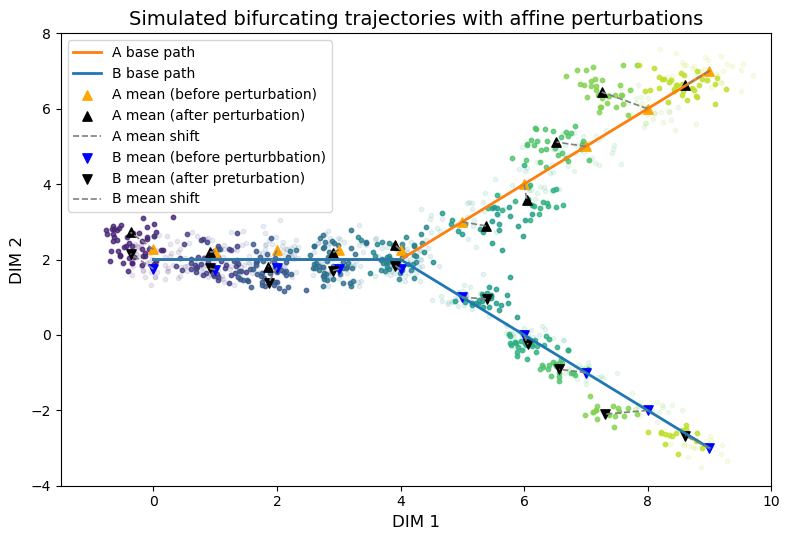

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch

# ---------------------- Affine (one-knob strength) --------------------------
def make_affine(strength=0.50, rotation_max_deg=10, scale_max=0.20, b_sigma_max=0.30):
    th = np.deg2rad(np.random.uniform(-rotation_max_deg*strength, rotation_max_deg*strength))
    c, s = np.cos(th), np.sin(th)
    R = np.array([[c, -s], [s, c]])
    s1 = 1.0 + strength*np.random.uniform(-scale_max, scale_max)
    s2 = 1.0 + strength*np.random.uniform(-scale_max, scale_max)
    A  = R @ np.diag([s1, s2]) @ R.T
    b  = np.random.randn(2) * (b_sigma_max*strength)
    return A, b

# ---------------------- Configuration ---------------------------------------
seed = 23
np.random.seed(seed)

x   = np.arange(10)              # 0..9
NUM = len(x)

yA_base = np.where(x <= 4, 2.0, x - 2)        # upper comp path
yB_base = np.where(x <= 4, 2.0, -x + 6.0)     # lower comp path

colors = plt.cm.viridis(np.linspace(0.1, 0.9, NUM))

n_per_gauss  = 50
dataset_size = 500
pi_A         = 0.5

delta_pre  = 0.25
delta_post = 0.00

# y-only jitter for t in {0..4}
y_only_jitter_pre = 0.03

sig_x_A, sig_y_A = 0.32, 0.30
sig_x_B, sig_y_B = 0.22, 0.20
cov_A = np.diag([sig_x_A**2, sig_y_A**2])
cov_B = np.diag([sig_x_B**2, sig_y_B**2])

strength = 0.5
per_time_affine = True

datasets_acc = []
Ysamplers_acc = []

# ---------------------- Main generation loop --------------------------------
plt.close('all')
plt.figure(figsize=(8, 5.5))
plt.title('Simulated bifurcating trajectories with affine perturbations', fontsize=14)

plt.plot(x, yA_base, color='tab:orange', linewidth=2.0, label='A base path')
plt.plot(x, yB_base, color='tab:blue',   linewidth=2.0, label='B base path')

if not per_time_affine:
    A_global, b_global = make_affine(strength=strength)

for i in range(NUM):
    muA_center = np.array([x[i], yA_base[i]])
    muB_center = np.array([x[i], yB_base[i]])

    dA = +delta_pre  if i <= 4 else +delta_post
    dB = -delta_pre  if i <= 4 else -delta_post

    # pre-affine mean (with early y-jitter)
    if i <= 4:
        jitter_y_A = np.random.randn() * y_only_jitter_pre
        jitter_y_B = np.random.randn() * y_only_jitter_pre
    else:
        jitter_y_A = 0.0
        jitter_y_B = 0.0

    mu_A = muA_center + np.array([0.0, dA + jitter_y_A])
    mu_B = muB_center + np.array([0.0, dB - jitter_y_B])  # keep B slightly lower

    # small cloud for viz (pre-affine)
    counts_small = np.random.multinomial(n_per_gauss, [pi_A, 1 - pi_A])
    gt_A_small = np.random.multivariate_normal(mu_A, cov_A, counts_small[0])
    gt_B_small = np.random.multivariate_normal(mu_B, cov_B, counts_small[1])
    gt_small   = np.vstack([gt_A_small, gt_B_small])

    # full dataset (pre-affine)
    counts_full = np.random.multinomial(dataset_size, [pi_A, 1 - pi_A])
    gt_A = np.random.multivariate_normal(mu_A, cov_A, counts_full[0])
    gt_B = np.random.multivariate_normal(mu_B, cov_B, counts_full[1])
    gt_data = np.vstack([gt_A, gt_B])

    # affine
    if per_time_affine:
        A, b = make_affine(strength=strength)
    else:
        A, b = A_global, b_global

    # transform
    pt_small = (gt_small @ A.T) + b
    pt_data  = (gt_data  @ A.T) + b

    datasets_acc.append(torch.from_numpy(pt_data).float())

    # post-affine means (apply to the means too)
    mu_pt_A = A @ mu_A + b
    mu_pt_B = A @ mu_B + b

    col = colors[i]
    # clouds
    plt.scatter(gt_small[:,0], gt_small[:,1], color=col, s=10, alpha=0.10)
    plt.scatter(pt_small[:,0], pt_small[:,1], color=col, s=10, alpha=0.80)

    # ---- NEW: show pre-affine means in red and connect to post-affine means ----
    # A component
    if i == 0:
        plt.scatter(*mu_A,   color='orange',   marker='^', s=45, label='A mean (before perturbation)')
        plt.scatter(*mu_pt_A, color='black', marker='^', s=45, label='A mean (after perturbation)')
        plt.plot([mu_A[0], mu_pt_A[0]], [mu_A[1], mu_pt_A[1]],
                 linestyle='--', color='grey', linewidth=1.2, label='A mean shift')
        # B component
        plt.scatter(*mu_B,   color='blue',   marker='v', s=45, label='B mean (before perturbbation)')
        plt.scatter(*mu_pt_B, color='black', marker='v', s=45, label='B mean (after preturbation)')
        plt.plot([mu_B[0], mu_pt_B[0]], [mu_B[1], mu_pt_B[1]],
                 linestyle='--', color='grey', linewidth=1.2, label='B mean shift')
    else:
        plt.scatter(*mu_A,   color='orange',   marker='^', s=45)
        plt.scatter(*mu_pt_A, color='black', marker='^', s=45)
        plt.plot([mu_A[0], mu_pt_A[0]], [mu_A[1], mu_pt_A[1]],
                 linestyle='--', color='grey', linewidth=1.2)
        plt.scatter(*mu_B,   color='blue',   marker='v', s=45)
        plt.scatter(*mu_pt_B, color='black', marker='v', s=45)
        plt.plot([mu_B[0], mu_pt_B[0]], [mu_B[1], mu_pt_B[1]],
                 linestyle='--', color='grey', linewidth=1.2)

plt.legend()
plt.xlabel('DIM 1', fontsize=12); plt.ylabel('DIM 2', fontsize=12)

plt.xlim(-1.5, 10)   # set x-axis range
plt.ylim(-4, 8)   # set y-axis range

plt.tight_layout()
plt.show()


In [8]:
# loading the learned generators
size = 100
DIM = 2
dropout_rate = 0.05
G1 = Gnet(input_dim=DIM, output_dim=DIM, size=size, num_layers=4, dropout_rate=dropout_rate)
G2 = Gnet(input_dim=DIM, output_dim=DIM, size=size, num_layers=4, dropout_rate=dropout_rate)
G3 = Gnet(input_dim=DIM, output_dim=DIM, size=size, num_layers=4, dropout_rate=dropout_rate)
G4 = Gnet(input_dim=DIM, output_dim=DIM, size=size, num_layers=4, dropout_rate=dropout_rate)
G5 = Gnet(input_dim=DIM, output_dim=DIM, size=size, num_layers=4, dropout_rate=dropout_rate)
G6 = Gnet(input_dim=DIM, output_dim=DIM, size=size, num_layers=4, dropout_rate=dropout_rate)
G7 = Gnet(input_dim=DIM, output_dim=DIM, size=size, num_layers=4, dropout_rate=dropout_rate)
G8 = Gnet(input_dim=DIM, output_dim=DIM, size=size, num_layers=4, dropout_rate=dropout_rate)
Z_sampler = distributions.StandardNormalSampler(dim=DIM, device="cpu")

print('G params:', np.sum([np.prod(p.shape) for p in G1.parameters()]))


###########################################
# set path to the downloaded UOTReg folder
###########################################

result_folder = "/Users/binghao/Desktop/Research/OT-singlecell/UOTReg/"
G1.load_state_dict(torch.load(result_folder+"results/simu/noisy/cc/Gnew/G_100_acc_1.pth"))
G2.load_state_dict(torch.load(result_folder+"results/simu/noisy/cc/Gnew/G_100_acc_2.pth"))
G3.load_state_dict(torch.load(result_folder+"results/simu/noisy/cc/Gnew/G_100_acc_3.pth"))
G4.load_state_dict(torch.load(result_folder+"results/simu/noisy/cc/Gnew/G_100_acc_4.pth"))
G5.load_state_dict(torch.load(result_folder+"results/simu/noisy/cc/Gnew/G_100_acc_5.pth"))
G6.load_state_dict(torch.load(result_folder+"results/simu/noisy/cc/Gnew/G_100_acc_6.pth"))
G7.load_state_dict(torch.load(result_folder+"results/simu/noisy/cc/Gnew/G_100_acc_7.pth"))
G8.load_state_dict(torch.load(result_folder+"results/simu/noisy/cc/Gnew/G_100_acc_8.pth"))
Gs = [G1,G2, G3, G4, G5, G6, G7, G8]

G params: 30802


In [9]:
Ysamplers_acc_reg = []
# Ysamplers_nonaffine_reg = []
datasets_learned = []

for i in range(8):

    pt_data = Gs[i](Z_sampler.sample(500)).detach().numpy()

    meta_acc = pd.DataFrame(i, index=range(500), columns=['value'])
    dataset = tensorDataset(pd.DataFrame(pt_data),meta_acc)
    print(len(dataset))
    Ysamplers_acc_reg.append(tensorSampler(dataset, device="cpu"))
    datasets_learned.append(Ysamplers_acc_reg[i].sample(500).detach().numpy())

500
500
500
500
500
500
500
500


500
500
500
500
500
500
500
500
500
500


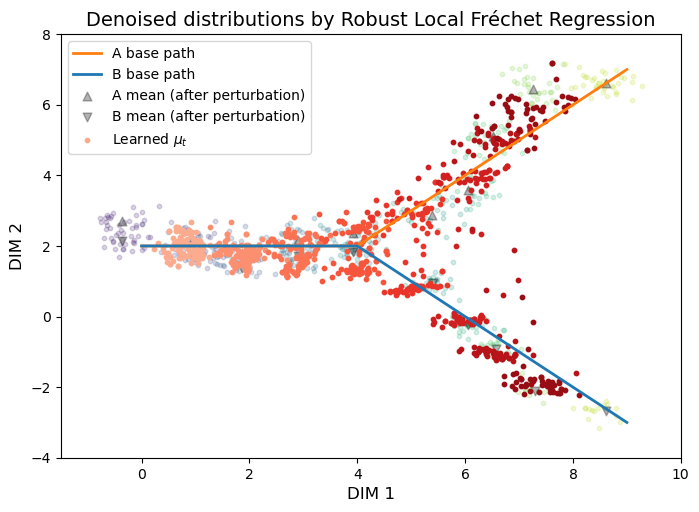

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch

# ---------------------- Affine (one-knob strength) --------------------------

def make_affine(strength=0.50, rotation_max_deg=10, scale_max=0.20, b_sigma_max=0.30):
    """
    Generate an affine map (A,b) with controllable 'strength':
      strength=0  -> A≈I, b≈0
      strength=1  -> full ranges of rotation/scale/translation
    """
    th = np.deg2rad(np.random.uniform(-rotation_max_deg*strength, rotation_max_deg*strength))
    c, s = np.cos(th), np.sin(th)
    R = np.array([[c, -s], [s, c]])

    s1 = 1.0 + strength*np.random.uniform(-scale_max, scale_max)
    s2 = 1.0 + strength*np.random.uniform(-scale_max, scale_max)

    A  = R @ np.diag([s1, s2]) @ R.T
    b  = np.random.randn(2) * (b_sigma_max*strength)
    return A, b

# ---------------------- Configuration ---------------------------------------

seed = 23
np.random.seed(seed)

x   = np.arange(10)              # 0..9
NUM = len(x)

yA_base = np.where(x <= 4, 2.0, x - 2)        # upper comp path
yB_base = np.where(x <= 4, 2.0, -x + 6.0) # lower comp path

colors = plt.cm.viridis(np.linspace(0.1, 0.9, NUM))

n_per_gauss  = 50
dataset_size = 500
pi_A         = 0.5

delta_pre  = 0.25
delta_post = 0.00

# >>> changed jitter logic
# Remove x-jitter entirely; only add small y-only jitter for t in {0..4}.
y_only_jitter_pre = 0.03  # magnitude for the early shared phase

sig_x_A, sig_y_A = 0.32, 0.30
sig_x_B, sig_y_B = 0.22, 0.20
cov_A = np.diag([sig_x_A**2, sig_y_A**2])
cov_B = np.diag([sig_x_B**2, sig_y_B**2])

strength = 0.5
per_time_affine = True

datasets_acc = []
Ysamplers_acc = []

# ---------------------- Main generation loop --------------------------------

plt.close('all')
plt.figure(figsize=(8, 5.5))
plt.title("Denoised distributions by Robust Local Fréchet Regression", fontsize=14)

plt.plot(x, yA_base, color='tab:orange', linewidth=2.0, label='A base path')
plt.plot(x, yB_base, color='tab:blue',   linewidth=2.0, label='B base path')

datasets_acc = []

if not per_time_affine:
    A_global, b_global = make_affine(strength=strength)

for i in range(NUM):
    muA_center = np.array([x[i], yA_base[i]])
    muB_center = np.array([x[i], yB_base[i]])

    dA = +delta_pre  if i <= 4 else +delta_post
    dB = -delta_pre  if i <= 4 else -delta_post

    # >>> changed jitter logic (no x-jitter; only y-perturbation for t<=4)
    if i <= 4:
        jitter_y_A = np.random.randn() * y_only_jitter_pre
        jitter_y_B = np.random.randn() * y_only_jitter_pre
    else:
        jitter_y_A = 0.0
        jitter_y_B = 0.0

    mu_A = muA_center + np.array([0.0, dA + jitter_y_A])
    mu_B = muB_center + np.array([0.0, dB - jitter_y_B])  # keep B slightly lower

    counts_small = np.random.multinomial(n_per_gauss, [pi_A, 1 - pi_A])
    gt_A_small = np.random.multivariate_normal(mu_A, cov_A, counts_small[0])
    gt_B_small = np.random.multivariate_normal(mu_B, cov_B, counts_small[1])
    gt_small   = np.vstack([gt_A_small, gt_B_small])

    counts_full = np.random.multinomial(dataset_size, [pi_A, 1 - pi_A])
    gt_A = np.random.multivariate_normal(mu_A, cov_A, counts_full[0])
    gt_B = np.random.multivariate_normal(mu_B, cov_B, counts_full[1])
    gt_data = np.vstack([gt_A, gt_B])
    comp_full = np.array([0]*counts_full[0] + [1]*counts_full[1])

    if per_time_affine:
        A, b = make_affine(strength=strength)
    else:
        A, b = A_global, b_global

    pt_small = (gt_small @ A.T) + b
    pt_data  = (gt_data  @ A.T) + b

    # pt_small = gt_small
    # pt_data  = gt_data

    # meta_acc = pd.DataFrame({
    #     'time':  i,
    #     'comp':  comp_full,
    # })
    # dataset = tensorDataset(pd.DataFrame(pt_data, columns=['x1','x2']), meta_acc)
    # print(f"time {i}: {len(dataset)} samples")
    # datasets_acc.append(dataset.X)

    datasets_acc.append(torch.from_numpy(pt_data).float())
    meta_acc= pd.DataFrame(i, index=range(dataset_size), columns=['value'])
    dataset = tensorDataset(pd.DataFrame(pt_data),meta_acc)
    print(len(dataset))
    Ysamplers_acc.append(tensorSampler(dataset, device="cpu"))

    mu_pt_A = A @ mu_A + b
    mu_pt_B = A @ mu_B + b

    col = colors[i]
    plt.scatter(gt_small[:,0], gt_small[:,1], color=col, s=10, alpha=0)
    plt.scatter(pt_small[:,0], pt_small[:,1], color=col, s=10, alpha=0.2)

    if i == 0:
        plt.scatter(*mu_pt_A, color='black', marker='^', s=40, label='A mean (after perturbation)', alpha = 0.3)
        plt.scatter(*mu_pt_B, color='black', marker='v', s=40, label='B mean (after perturbation)', alpha = 0.3)
    else:
        plt.scatter(*mu_pt_A, color='black', marker='^', s=40, alpha = 0.3)
        plt.scatter(*mu_pt_B, color='black', marker='v', s=40, alpha = 0.3)

import matplotlib.cm as cm
# --- overlay learned samples (second chunk) ---
ax = plt.gca()
reds = cm.Reds(np.linspace(0.3, 0.9, len(Ysamplers_acc_reg)))

for i, sampler in enumerate(Ysamplers_acc_reg):
    samples = sampler.sample(100).numpy()
    ax.scatter(
        samples[:, 0], samples[:, 1],
        color=reds[i], s=10,
        label='Learned $\mu_t$' if i == 0 else ''
    )

plt.xlim(-1.5, 10)   # set x-axis range
plt.ylim(-4, 8)   # set y-axis range
plt.xlabel('DIM 1', fontsize=12); plt.ylabel('DIM 2', fontsize=12)

plt.legend()
plt.show()


In [11]:
it = 0
BATCH_SIZE = 196
D_ITERS = 250
T_ITERS = 100
D_LR, T_LR = 3e-4, 3e-4

dropout_rate = 0.05
# Parameters for T and D
input_size = DIM # DIM
output_size = DIM
n_hidden = 5
task_specific_hidden_size_T = 256
task_specific_hidden_size_D = 256

# Initialize networks
T = FFNN(input_size, task_specific_hidden_size_T, n_hidden, output_size, bn=False, dropout_rate=dropout_rate)
D = FFNN(input_size, task_specific_hidden_size_D, n_hidden, 1, bn=False, dropout_rate=dropout_rate)

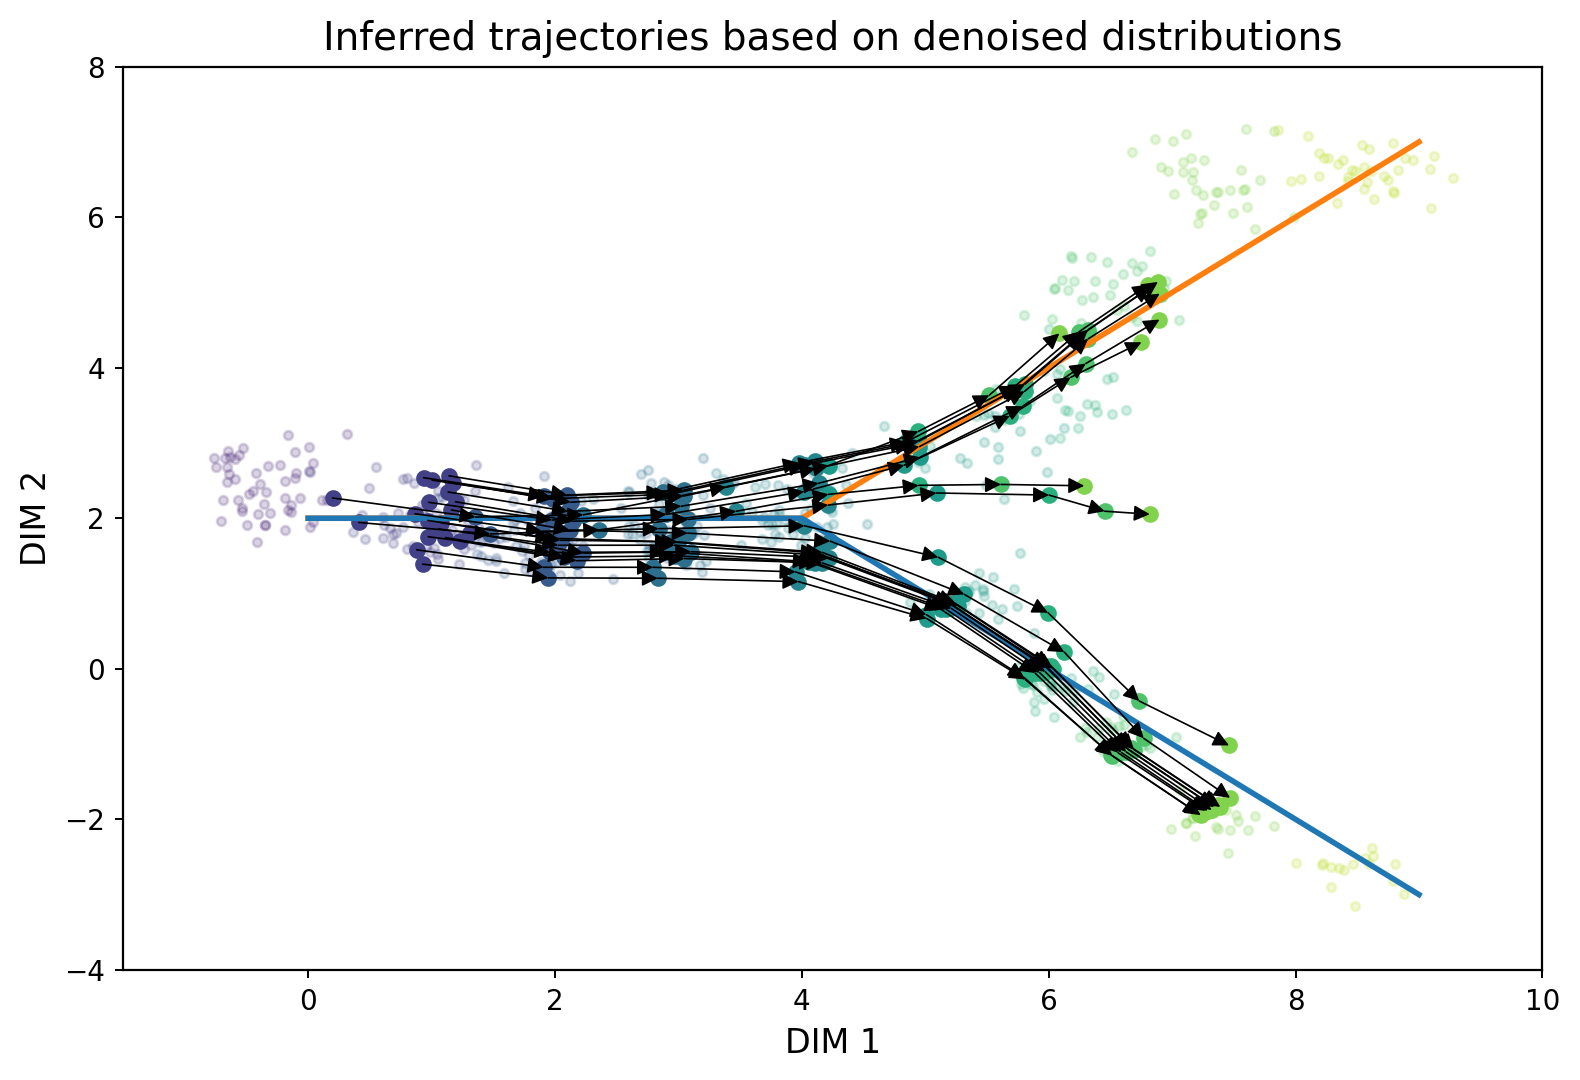

In [ ]:
# --- Consistent plotting style setup ---
plt.close('all')
fig, ax = plt.subplots(figsize=(8, 5.5), dpi=200)

np.random.seed(23)

# Title / labels to match older figs
ax.set_title('Inferred trajectories based on denoised distributions', fontsize=14)
ax.set_xlabel('DIM 1', fontsize=12)
ax.set_ylabel('DIM 2', fontsize=12)

# Axes cosmetics same as before
ax.set_facecolor('white')
for spine in ['top', 'right', 'left', 'bottom']:
    ax.spines[spine].set_visible(True)
    ax.spines[spine].set_linewidth(0.8)
ax.tick_params(axis='both', which='both', direction='out', length=3, width=0.7, labelsize=10)

# Base paths
ax.plot(x, yA_base, color='tab:orange', linewidth=2.0, label='A base path')
ax.plot(x, yB_base, color='tab:blue',   linewidth=2.0, label='B base path')

# =================== Part 1: clouds (use ax.* consistently) ==================
if not per_time_affine:
    A_global, b_global = make_affine(strength=strength)

for i in range(NUM):
    muA_center = np.array([x[i], yA_base[i]])
    muB_center = np.array([x[i], yB_base[i]])

    dA = +delta_pre  if i <= 4 else +delta_post
    dB = -delta_pre  if i <= 4 else -delta_post

    if i <= 4:
        jitter_y_A = np.random.randn() * y_only_jitter_pre
        jitter_y_B = np.random.randn() * y_only_jitter_pre
    else:
        jitter_y_A = jitter_y_B = 0.0

    mu_A = muA_center + np.array([0.0, dA + jitter_y_A])
    mu_B = muB_center + np.array([0.0, dB - jitter_y_B])

    counts_small = np.random.multinomial(n_per_gauss, [pi_A, 1 - pi_A])
    gt_A_small = np.random.multivariate_normal(mu_A, cov_A, counts_small[0])
    gt_B_small = np.random.multivariate_normal(mu_B, cov_B, counts_small[1])
    gt_small   = np.vstack([gt_A_small, gt_B_small])

    counts_full = np.random.multinomial(dataset_size, [pi_A, 1 - pi_A])
    gt_A = np.random.multivariate_normal(mu_A, cov_A, counts_full[0])
    gt_B = np.random.multivariate_normal(mu_B, cov_B, counts_full[1])
    gt_data = np.vstack([gt_A, gt_B])

    if per_time_affine:
        A, b = make_affine(strength=strength)
    else:
        A, b = A_global, b_global

    pt_small = (gt_small @ A.T) + b
    pt_data  = (gt_data  @ A.T) + b

    datasets_acc.append(torch.from_numpy(pt_data).float())
    # (skip sampler creation to keep focus on style)

    col = colors[i]
    ax.scatter(gt_small[:,0], gt_small[:,1], color=col, s=10, alpha=0.0)  # pre-affine (faint)
    ax.scatter(pt_small[:,0], pt_small[:,1], color=col, s=10, alpha=0.20)  # post-affine (light)

# =================== Part 2: overlay learned trajectories ====================
t0 = 1
muA_center_t0 = np.array([x[t0], yA_base[t0]])
muB_center_t0 = np.array([x[t0], yB_base[t0]])

dA0 = +delta_pre  if t0 <= 4 else +delta_post
dB0 = -delta_pre  if t0 <= 4 else -delta_post

jA0 = np.random.randn() * y_only_jitter_pre if t0 <= 4 else 0.0
jB0 = np.random.randn() * y_only_jitter_pre if t0 <= 4 else 0.0

mu_A_t0 = muA_center_t0 + np.array([0.0, dA0 + jA0])
mu_B_t0 = muB_center_t0 + np.array([0.0, dB0 - jB0])

# draw K initial points from mixture
K = 20
np.random.seed(seed)
choices = np.random.choice([0, 1], size=K, p=[pi_A, 1 - pi_A])
choices = [0,0,0,0,0,1,0,1,1,1,0,0,0,0,0,1,0,1,1,1]
pts = []
for c in choices:
    if c == 0:
        pts.append(np.random.multivariate_normal(mu_A_t0, cov_A, 1)[0])
    else:
        pts.append(np.random.multivariate_normal(mu_B_t0, cov_B, 1)[0])
current_data = np.stack(pts, axis=0)  # (K,2)

# build trajectory by applying learned maps T_1→2, T_2→3, ..., T_8→9
trajectory = []
data_t = torch.from_numpy(current_data).float()
trajectory.append(data_t.detach().numpy())

# ---- You must have a defined model class 'T' compatible with saved state_dicts
###########################################
# set path to the downloaded UOTReg folder
###########################################
result_folder = "/Users/binghao/Desktop/Research/OT-singlecell/UOTReg/"
T_paths = [result_folder + f"results/simu/noisy/cc/MapsRegNew/T_map_{i+1}_to_{i+2}.pt" for i in range(7)]

for path in T_paths:
    T.load_state_dict(torch.load(path))   # uses your predefined network instance T
    T.eval()
    with torch.no_grad():
        data_t = T(data_t)
    trajectory.append(data_t.detach().numpy())
    
colors_traj = colors[1:9]  # 8 steps
for step, (data, color) in enumerate(zip(trajectory, colors_traj)):
    ax.scatter(data[:, 0], data[:, 1], color=color, s=25,
               label=f'Trajectory step {step}' if step == 0 else '')
for t in range(len(trajectory) - 1):
    data_from = trajectory[t]
    data_to   = trajectory[t + 1]
    for p_start, p_end in zip(data_from, data_to):
        ax.annotate('', xy=p_end, xytext=p_start,
                    arrowprops=dict(arrowstyle='-|>',
                                    color='black', lw=0.6,
                                    mutation_scale=12, shrinkA=0, shrinkB=0,
                                    connectionstyle="arc3,rad=0"))

# Fixed limits so the “box” is the same across figures
ax.set_xlim(-1.5, 10)
ax.set_ylim(-4, 8)

plt.tight_layout()
plt.show()


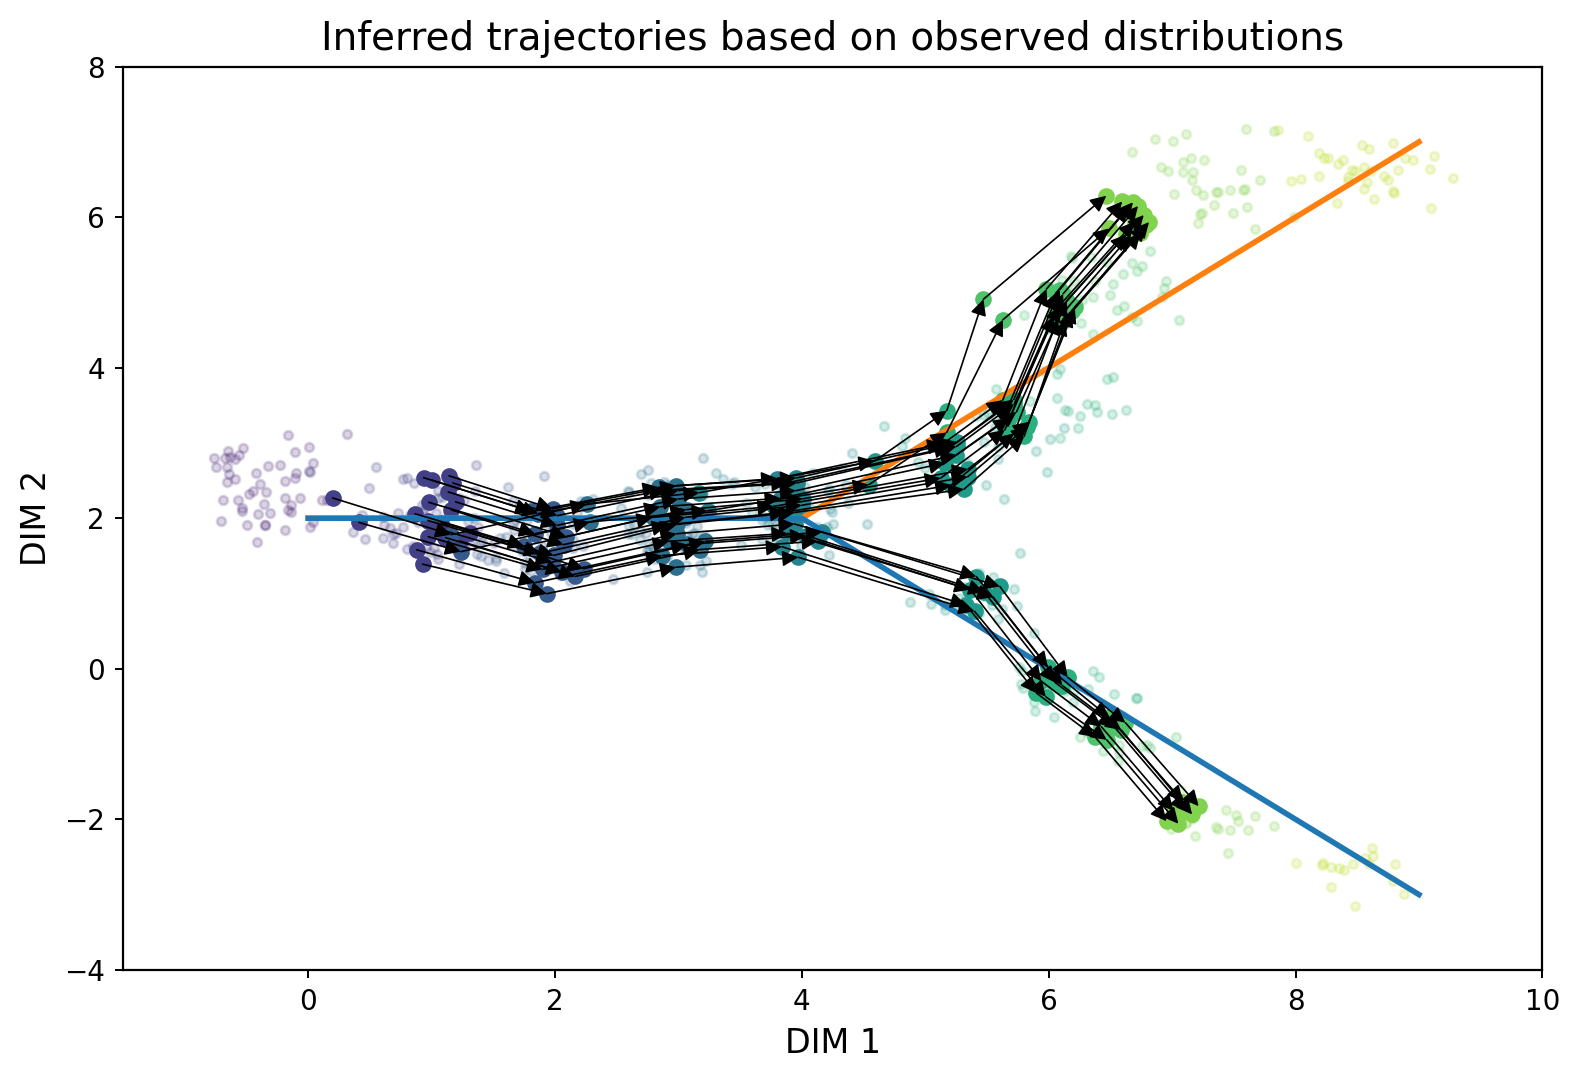

In [13]:
# --- Consistent plotting style setup ---
plt.close('all')
fig, ax = plt.subplots(figsize=(8, 5.5), dpi=200)

np.random.seed(23)

# Title / labels to match older figs
ax.set_title('Inferred trajectories based on observed distributions', fontsize=14)
ax.set_xlabel('DIM 1', fontsize=12)
ax.set_ylabel('DIM 2', fontsize=12)

# Axes cosmetics same as before
ax.set_facecolor('white')
for spine in ['top', 'right', 'left', 'bottom']:
    ax.spines[spine].set_visible(True)
    ax.spines[spine].set_linewidth(0.8)
ax.tick_params(axis='both', which='both', direction='out', length=3, width=0.7, labelsize=10)

# Base paths
ax.plot(x, yA_base, color='tab:orange', linewidth=2.0, label='A base path')
ax.plot(x, yB_base, color='tab:blue',   linewidth=2.0, label='B base path')

# =================== Part 1: clouds (use ax.* consistently) ==================
if not per_time_affine:
    A_global, b_global = make_affine(strength=strength)

for i in range(NUM):
    muA_center = np.array([x[i], yA_base[i]])
    muB_center = np.array([x[i], yB_base[i]])

    dA = +delta_pre  if i <= 4 else +delta_post
    dB = -delta_pre  if i <= 4 else -delta_post

    if i <= 4:
        jitter_y_A = np.random.randn() * y_only_jitter_pre
        jitter_y_B = np.random.randn() * y_only_jitter_pre
    else:
        jitter_y_A = jitter_y_B = 0.0

    mu_A = muA_center + np.array([0.0, dA + jitter_y_A])
    mu_B = muB_center + np.array([0.0, dB - jitter_y_B])

    counts_small = np.random.multinomial(n_per_gauss, [pi_A, 1 - pi_A])
    gt_A_small = np.random.multivariate_normal(mu_A, cov_A, counts_small[0])
    gt_B_small = np.random.multivariate_normal(mu_B, cov_B, counts_small[1])
    gt_small   = np.vstack([gt_A_small, gt_B_small])

    counts_full = np.random.multinomial(dataset_size, [pi_A, 1 - pi_A])
    gt_A = np.random.multivariate_normal(mu_A, cov_A, counts_full[0])
    gt_B = np.random.multivariate_normal(mu_B, cov_B, counts_full[1])
    gt_data = np.vstack([gt_A, gt_B])

    if per_time_affine:
        A, b = make_affine(strength=strength)
    else:
        A, b = A_global, b_global

    pt_small = (gt_small @ A.T) + b
    pt_data  = (gt_data  @ A.T) + b

    datasets_acc.append(torch.from_numpy(pt_data).float())
    # (skip sampler creation to keep focus on style)

    col = colors[i]
    ax.scatter(gt_small[:,0], gt_small[:,1], color=col, s=10, alpha=0.0)  # pre-affine (faint)
    ax.scatter(pt_small[:,0], pt_small[:,1], color=col, s=10, alpha=0.20)  # post-affine (light)

# =================== Part 2: overlay learned trajectories ====================

t0 = 1
muA_center_t0 = np.array([x[t0], yA_base[t0]])
muB_center_t0 = np.array([x[t0], yB_base[t0]])

dA0 = +delta_pre  if t0 <= 4 else +delta_post
dB0 = -delta_pre  if t0 <= 4 else -delta_post

jA0 = np.random.randn() * y_only_jitter_pre if t0 <= 4 else 0.0
jB0 = np.random.randn() * y_only_jitter_pre if t0 <= 4 else 0.0

mu_A_t0 = muA_center_t0 + np.array([0.0, dA0 + jA0])
mu_B_t0 = muB_center_t0 + np.array([0.0, dB0 - jB0])

# draw K initial points from mixture
K = 20
np.random.seed(seed)
choices = np.random.choice([0, 1], size=K, p=[pi_A, 1 - pi_A])
choices = [0,0,0,0,0,1,0,1,1,1,0,0,0,0,0,1,0,1,1,1]
pts = []
for c in choices:
    if c == 0:
        pts.append(np.random.multivariate_normal(mu_A_t0, cov_A, 1)[0])
    else:
        pts.append(np.random.multivariate_normal(mu_B_t0, cov_B, 1)[0])
current_data = np.stack(pts, axis=0)  # (K,2)


# build trajectory by applying learned maps T_1→2, T_2→3, ..., T_8→9
trajectory = []
data_t = torch.from_numpy(current_data).float()
trajectory.append(data_t.detach().numpy())

# ---- You must have a defined model class 'T' compatible with saved state_dicts
###########################################
# set path to the downloaded UOTReg folder
###########################################
result_folder = "/Users/binghao/Desktop/Research/OT-singlecell/UOTReg/"
T_paths = [result_folder + f"results/simu/noisy/cc/MapsDirectNew2/T_map_{i+1}_to_{i+2}.pt" for i in range(7)]

for path in T_paths:
    T.load_state_dict(torch.load(path))   # uses your predefined network instance T
    T.eval()
    with torch.no_grad():
        data_t = T(data_t)
    trajectory.append(data_t.detach().numpy())

colors_traj = colors[1:9]  # 8 steps
for step, (data, color) in enumerate(zip(trajectory, colors_traj)):
    ax.scatter(data[:, 0], data[:, 1], color=color, s=25,
               label=f'Trajectory step {step}' if step == 0 else '')
for t in range(len(trajectory) - 1):
    data_from = trajectory[t]
    data_to   = trajectory[t + 1]
    for p_start, p_end in zip(data_from, data_to):
        ax.annotate('', xy=p_end, xytext=p_start,
                    arrowprops=dict(arrowstyle='-|>',
                                    color='black', lw=0.6,
                                    mutation_scale=12, shrinkA=0, shrinkB=0,
                                    connectionstyle="arc3,rad=0"))

# Fixed limits so the “box” is the same across figures
ax.set_xlim(-1.5, 10)
ax.set_ylim(-4, 8)

plt.tight_layout()
plt.show()


In [14]:
###########################################
# set path to the downloaded UOTReg folder
###########################################
result_folder = "/Users/binghao/Desktop/Research/OT-singlecell/UOTReg/"
trajectory = np.load(result_folder+"results/simu/noisy/cc/mioflow_traj_nogae.npy") # (100,20,2)

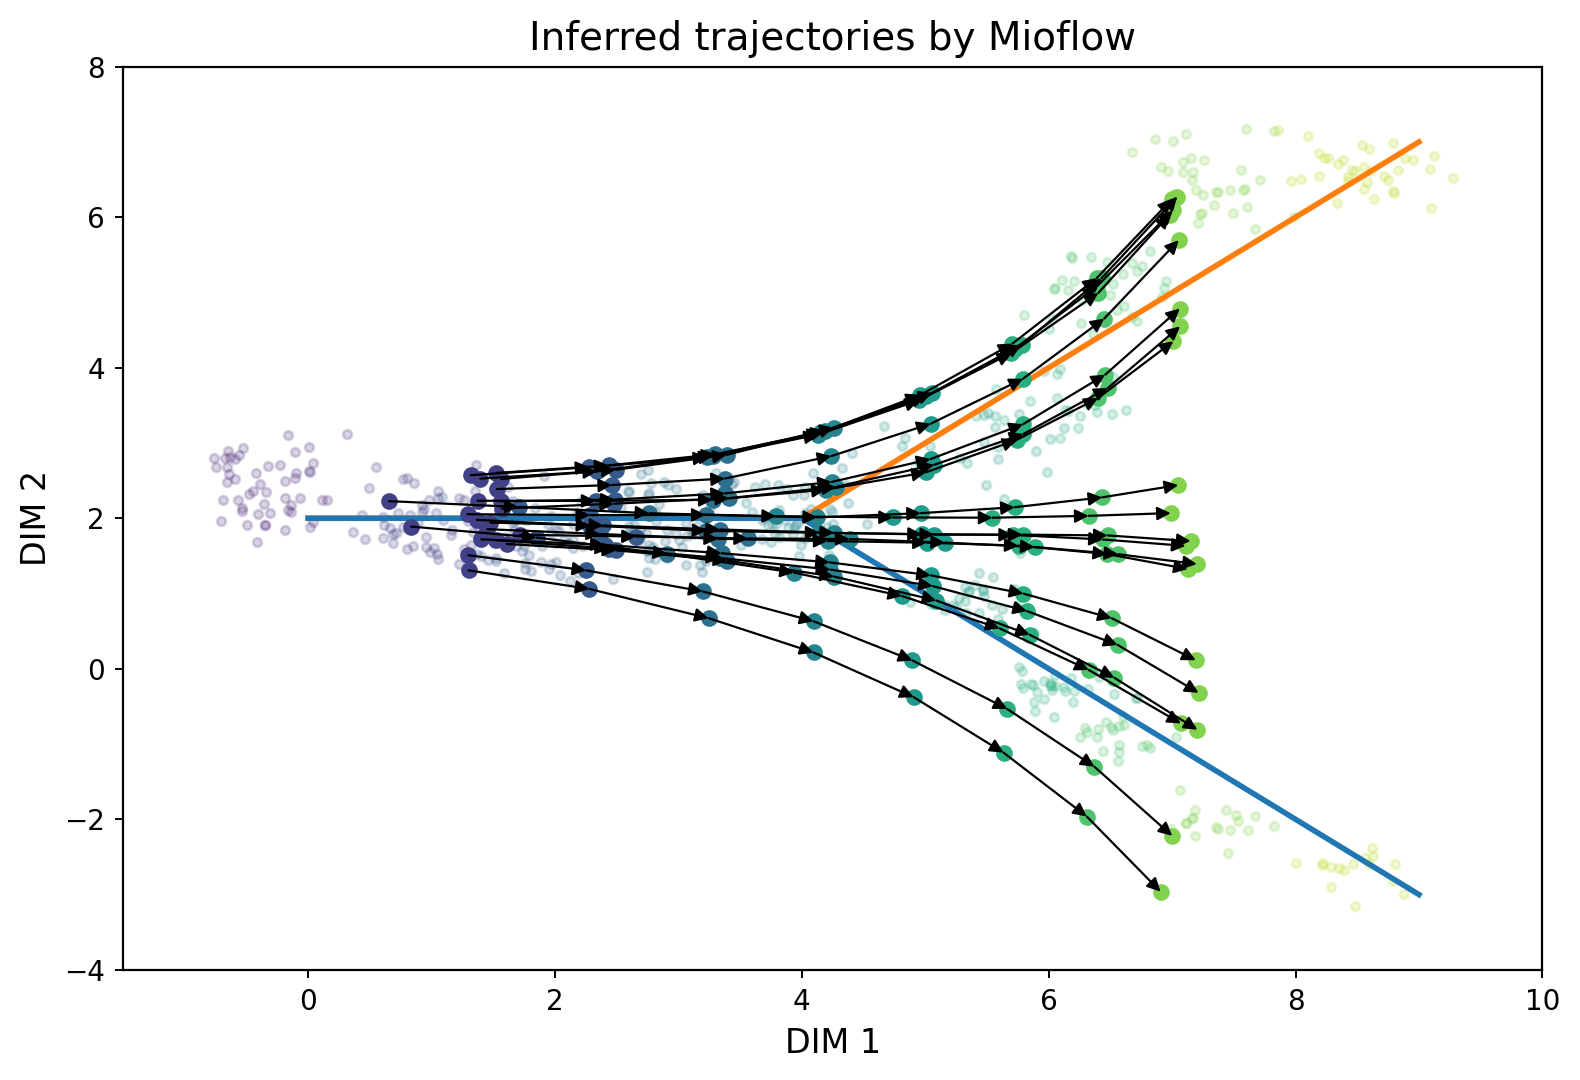

In [15]:
# --- Consistent plotting style setup ---
plt.close('all')
fig, ax = plt.subplots(figsize=(8, 5.5), dpi=200)

np.random.seed(23)

# Title / labels to match older figs
ax.set_title('Inferred trajectories by Mioflow', fontsize=14)
ax.set_xlabel('DIM 1', fontsize=12)
ax.set_ylabel('DIM 2', fontsize=12)

# Axes cosmetics same as before
ax.set_facecolor('white')
for spine in ['top', 'right', 'left', 'bottom']:
    ax.spines[spine].set_visible(True)
    ax.spines[spine].set_linewidth(0.8)
ax.tick_params(axis='both', which='both', direction='out', length=3, width=0.7, labelsize=10)

# Base paths
ax.plot(x, yA_base, color='tab:orange', linewidth=2.0, label='A base path')
ax.plot(x, yB_base, color='tab:blue',   linewidth=2.0, label='B base path')

# =================== Part 1: clouds (use ax.* consistently) ==================
if not per_time_affine:
    A_global, b_global = make_affine(strength=strength)

for i in range(NUM):
    muA_center = np.array([x[i], yA_base[i]])
    muB_center = np.array([x[i], yB_base[i]])

    dA = +delta_pre  if i <= 4 else +delta_post
    dB = -delta_pre  if i <= 4 else -delta_post

    if i <= 4:
        jitter_y_A = np.random.randn() * y_only_jitter_pre
        jitter_y_B = np.random.randn() * y_only_jitter_pre
    else:
        jitter_y_A = jitter_y_B = 0.0

    mu_A = muA_center + np.array([0.0, dA + jitter_y_A])
    mu_B = muB_center + np.array([0.0, dB - jitter_y_B])

    counts_small = np.random.multinomial(n_per_gauss, [pi_A, 1 - pi_A])
    gt_A_small = np.random.multivariate_normal(mu_A, cov_A, counts_small[0])
    gt_B_small = np.random.multivariate_normal(mu_B, cov_B, counts_small[1])
    gt_small   = np.vstack([gt_A_small, gt_B_small])

    counts_full = np.random.multinomial(dataset_size, [pi_A, 1 - pi_A])
    gt_A = np.random.multivariate_normal(mu_A, cov_A, counts_full[0])
    gt_B = np.random.multivariate_normal(mu_B, cov_B, counts_full[1])
    gt_data = np.vstack([gt_A, gt_B])

    if per_time_affine:
        A, b = make_affine(strength=strength)
    else:
        A, b = A_global, b_global

    pt_small = (gt_small @ A.T) + b
    pt_data  = (gt_data  @ A.T) + b

    datasets_acc.append(torch.from_numpy(pt_data).float())
    # (skip sampler creation to keep focus on style)

    col = colors[i]
    ax.scatter(gt_small[:,0], gt_small[:,1], color=col, s=10, alpha=0.0)  # pre-affine (faint)
    ax.scatter(pt_small[:,0], pt_small[:,1], color=col, s=10, alpha=0.20)  # post-affine (light)

# =================== Part 2: overlay stored trajectories ====================

###########################################
# set path to the downloaded UOTReg folder
###########################################
result_folder = "/Users/binghao/Desktop/Research/OT-singlecell/UOTReg/"
traj_full = np.load(result_folder + "results/simu/noisy/cc/mioflow_traj_nogae.npy")  # (100,20,2)
T_full, N, D = traj_full.shape
assert D == 2

# Reduce to 8 time points (times 1..8) by partitioning 100 steps into 8 bins
n_bins = 8
edges = np.linspace(0, T_full, n_bins + 1, dtype=int)  # 9 edges
traj_reduced = np.empty((n_bins, N, D), dtype=float)

for b in range(n_bins):
    seg = traj_full[edges[b]:edges[b+1], :, :]  # (~12-13 steps, N, 2)
    traj_reduced[b] = seg.mean(axis=0)          # (N,2) -> average per trajectory

# Colors for time 1..8 (match your earlier convention)
colors_8 = colors[1:9]  # 8 colors

# Scatter the reduced points at each time with its color
for t in range(n_bins):
    P = traj_reduced[t]  # (N,2)
    ax.scatter(P[:, 0], P[:, 1], s=25, color=colors_8[t], zorder=3,
               label=f'Time {t+1}' if t == 0 else None)

# Draw black arrows between consecutive times for each trajectory
for n in range(N):
    for t in range(n_bins - 1):
        p_start = traj_reduced[t, n]
        p_end   = traj_reduced[t + 1, n]
        ax.annotate(
            '',
            xy=p_end, xytext=p_start,
            arrowprops=dict(
                arrowstyle='-|>',
                color='black',
                lw=0.8,
                mutation_scale=10,
                shrinkA=0, shrinkB=0,
                connectionstyle="arc3,rad=0"
            ),
            zorder=4
        )

# Fixed limits so the “box” is the same across figures
ax.set_xlim(-1.5, 10)
ax.set_ylim(-4, 8)

plt.tight_layout()
plt.show()
